# Signate開始時のお約束

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'signate.json'", fields="files(id)").execute()
signate_api_key = results.get('files', [])

filename = "/root/.signate/signate.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=signate_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [3]:
!pip install signate

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=e3f34776d95f28b93c0666e6e715b79ba9f1f9e251142b33b51887bf5fe17738
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


In [4]:
!signate files --competition-id=1523

  fileId  name               title                     size  updated_at
--------  -----------------  ----------------------  ------  -------------------
    3939  train.csv          学習用データ            494008  2024-08-01 12:00:28
    3940  test.csv           評価用データ            488363  2024-08-01 12:00:38
    3944  sample_submit.csv  応募用サンプルファイル   86893  2024-08-01 12:00:49
    4057  tutorial.ipynb     チュートリアルコード    323126  2024-08-01 12:01:00


In [5]:
!signate download --competition-id=1523

sample_submit.csv

tutorial.ipynb

test.csv

train.csv


Download completed.


In [6]:
!pip install kanjize

In [7]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 13.9 MB/s eta 0:00:00


In [8]:
!pip install shap

In [9]:
# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# データフレーム読み込み
train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")

In [579]:
# データ結合(番号を振り直す)
all_df = pd.concat([train_df,test_df],axis=0,ignore_index=True)
max_row = len(all_df)

<ipython-input-580-0d12c417dce0>:50: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all_df["Age"] = all_df["Age"].replace(-1,all_df.loc[all_df["Age"]>0,"Age"].median())


<Axes: >

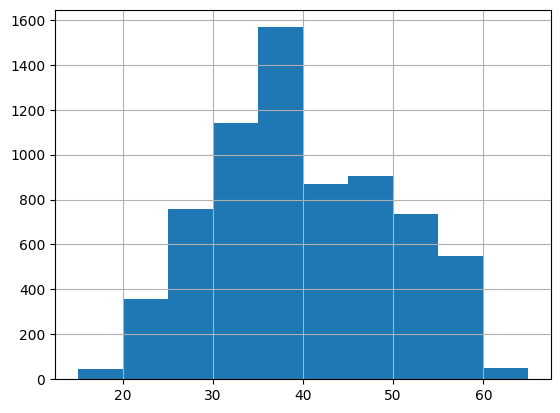

In [580]:
#####################
# "Age"(年齢)の処理 #
#####################
import unicodedata # 全角を半角に変換
from kanjize import kanji2number # 漢字を数値に変換
import re

# 漢字の判定用
p = re.compile('[一二三四五六七八九十]+')

# nanを-1歳で補完
all_df["Age"] = all_df["Age"].fillna("-1歳")

# Ageの処理
for i in range(max_row):

  # 末尾文字の取得
  tail = all_df.loc[i,"Age"][-1:]

  # 先頭文字が漢字の場合
  if(p.search(all_df.loc[i,"Age"][0])!=None):
    tmp = all_df.loc[i,"Age"][:-1]
    all_df.loc[i,"Age"] = kanji2number(tmp)
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

  # 末尾文字が歳、才、際の場合
  elif((tail=="歳")or(tail=="才")or(tail=="際")):
    all_df.loc[i,"Age"] = all_df.loc[i,"Age"][:-1]
    # 全角を半角に直す
    all_df.loc[i,"Age"] = unicodedata.normalize("NFKC", all_df.loc[i,"Age"])
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

  # 代の場合
  elif(tail == "代"):
    tmp = all_df.loc[i,"Age"][:-1]

    # 「代」は○5歳に変換する
    tmp = int(tmp)
    # 10歳で分けて5足す
    tmp = tmp//10 * 10
    all_df.loc[i,"Age"] = tmp + 5
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

    # 数値変換し5足す
    # tmp = int(tmp)
    # all_df.loc[i,"Age"] = tmp + 5
    # all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

# 「-1」はそれ以外の中央値を代入
all_df["Age"] = all_df["Age"].replace(-1,all_df.loc[all_df["Age"]>0,"Age"].median())

# int型にキャストする
all_df["Age"] = all_df["Age"].astype(int)

# ヒストグラムの表示
all_df["Age"].hist()

In [581]:
# 年代のラベリングを追加する
# all_df["AgeTeen"] = all_df["Age"]
# all_df["AgeTeen"] = all_df["AgeTeen"] // 10

<Axes: >

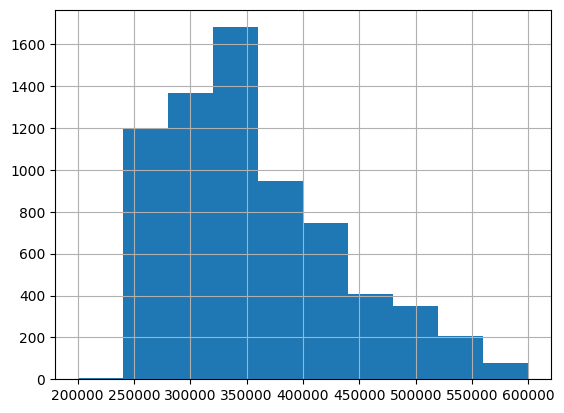

In [582]:
#########################
# "MonthlyIncome"の処理 #
#########################
import re

# 漢字の判定用
p = re.compile('[月]+')

# nanを-1で補完
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].fillna("-1")

for i in range(max_row):

  # 先頭文字の取得
  head = all_df.loc[i,"MonthlyIncome"][:1]

  # 先頭文字が漢字の場合
  if(p.search(head[0])!=None):
    tmp = all_df.loc[i,"MonthlyIncome"][2:-2]
    all_df.loc[i,"MonthlyIncome"] = float(tmp)*10000

# float型にキャストする
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].astype(float)

# 「-1」はそれ以外の中央値を代入
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].replace(-1,all_df.loc[all_df["MonthlyIncome"]>0,"MonthlyIncome"].median())

# 分布の確認
all_df["MonthlyIncome"].hist()

<Axes: >

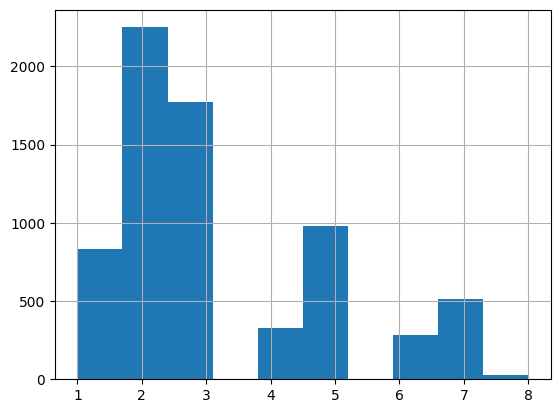

In [583]:
#########################
# "NumberOfTrips"の処理 #
#########################
# nanは-1で補完
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].fillna("-1")

# 一旦オブジェクト型に変更
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].astype("object")

for i in range(max_row):

  # 先頭文字の取得(半角)
  head = all_df.loc[i,"NumberOfTrips"][:1]

  if(head == "年"):
    all_df.loc[i,"NumberOfTrips"] = all_df.loc[i,"NumberOfTrips"][2:3]

  elif(head == "半"):
    all_df.loc[i,"NumberOfTrips"] = all_df.loc[i,"NumberOfTrips"][3:4]

  elif(head == "四"):
    all_df.loc[i,"NumberOfTrips"] = all_df.loc[i,"NumberOfTrips"][4:5]

# int型に変更
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].astype("int")

# 「-1」はそれ以外の中央値を代入
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].replace(-1,all_df.loc[all_df["NumberOfTrips"]>0,"NumberOfTrips"].median())

# ヒストグラムの確認
all_df["NumberOfTrips"].hist()

In [584]:
# 旅行回数を階層化
# all_df["Weight"] = 1
# all_df.loc[all_df["NumberOfTrips"]>=3,"Weight"] = 3
# all_df.loc[all_df["NumberOfTrips"]>=2,"Weight"] = 2

In [585]:
#########################
# "TypeofContact"の処理 #
#########################
# 欠損を埋める
all_df["TypeofContact"] = all_df["TypeofContact"].fillna("Self Enquiry")

# 分類の確認
all_df["TypeofContact"].value_counts()

,count
TypeofContact,
Self Enquiry,4462
Company Invited,2516


In [586]:
# 連絡手段の順序
Self = all_df.loc[all_df["TypeofContact"]=="Self Enquiry","NumberOfTrips"].median()
Company = all_df.loc[all_df["TypeofContact"]=="Company Invited","NumberOfTrips"].median()

print(Self)
print(Company)

all_df.loc[all_df["TypeofContact"]=="Self Enquiry","TypeofContact"] = 1
all_df.loc[all_df["TypeofContact"]=="Company Invited","TypeofContact"] = 2

# 旅行回数で割り当てる
# all_df.loc[all_df["TypeofContact"]=="Self Enquiry","TypeofContact"] = 3
# all_df.loc[all_df["TypeofContact"]=="Company Invited","TypeofContact"] = 2

all_df["TypeofContact"] = all_df["TypeofContact"].astype("int")

all_df["TypeofContact"].value_counts()

3.0
2.0


,count
TypeofContact,
1,4462
2,2516


In [587]:
#########################
# "CityTier"の処理 #
#########################
# 分類の確認
all_df["CityTier"].value_counts()
# all_df["CityTier"].isnull().sum()

,count
CityTier,
2,3160
1,2991
3,827


<Axes: >

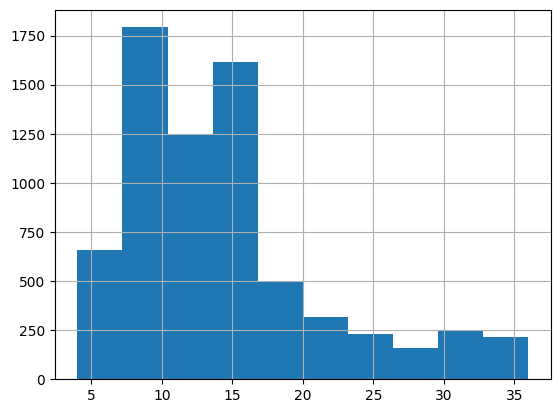

In [588]:
#########################
# "DurationOfPitch"の処理 #
#########################
# nanを-1分で補完
all_df["DurationOfPitch"] = all_df["DurationOfPitch"].fillna("-1分")

# 秒を分に変換 #
for i in range(max_row):

  tail = str(all_df.loc[i,"DurationOfPitch"])[-1:]

  if(tail == "秒"):
    tmp = all_df.loc[i,"DurationOfPitch"][:-1]
    all_df.loc[i,"DurationOfPitch"] = float(tmp) / 60.0
  elif(tail == "分"):
    all_df.loc[i,"DurationOfPitch"] = all_df.loc[i,"DurationOfPitch"][:-1]

all_df["DurationOfPitch"] = all_df["DurationOfPitch"].astype("float64")

# 「-1」はそれ以外の中央値を代入
all_df["DurationOfPitch"] = all_df["DurationOfPitch"].replace(-1,all_df.loc[all_df["DurationOfPitch"]>0,"DurationOfPitch"].median())

# 分布の確認
all_df["DurationOfPitch"].hist()

In [589]:
####################
# "Occupation"の処理 #
####################
# 個人事業主/会社員/大企業の3択のためホットエンコードにする
all_df["Occupation"].value_counts()
# all_df["Occupation"].isnull().sum()

,count
Occupation,
Small Business,3456
Salaried,2801
Large Business,721


In [590]:
print(all_df.loc[all_df["Occupation"]=="Small Business","NumberOfTrips"].median())
print(all_df.loc[all_df["Occupation"]=="Salaried","NumberOfTrips"].median())
print(all_df.loc[all_df["Occupation"]=="Large Business","NumberOfTrips"].median())

3.0
3.0
3.0


In [591]:
# 「Occupation」をラベルエンコード(特徴見当たらず)
all_df["Occupation_LE"] = 1
all_df.loc[all_df["Occupation"]=="Large Business","Occupation_LE"] = 3
all_df.loc[all_df["Occupation"]=="Salaried","Occupation_LE"] = 2
all_df.loc[all_df["Occupation"]=="Small Business","Occupation_LE"] = 1
# all_df.loc[all_df["Occupation"]=="Large Business","Occupation_LE"] = 3
# all_df.loc[all_df["Occupation"]=="Salaried","Occupation_LE"] = 1
# all_df.loc[all_df["Occupation"]=="Small Business","Occupation_LE"] = 2

In [592]:
# 元の列を削除
all_df = all_df.drop("Occupation", axis=1)

In [593]:
##################
# "Genger"の処理 #
##################
# all_df["Gender"].isnull().sum()
# 先頭文字がMかmならMaleになる
for i in range(max_row):

  # 先頭文字の取得(半角)
  head = unicodedata.normalize("NFKC", all_df.loc[i,"Gender"][:1])

  if(head == "m"):
    all_df.loc[i,"Gender"] = "Male"
  else:
    all_df.loc[i,"Gender"] = "Female"

In [594]:
# 分類の確認
all_df["Gender"].value_counts()

,count
Gender,
Female,5946
Male,1032


In [595]:
# ターゲットエンコーディング
# 男性の成約率が女性の1.5倍
print(all_df.loc[all_df["Gender"]=="Female","ProdTaken"].mean())
print(all_df.loc[all_df["Gender"]=="Male","ProdTaken"].mean())

0.13767629281396912
0.17025440313111545


In [596]:
# 「Gender」をラベルエンコード
all_df["Gender_LE"] = 1
# all_df.loc[all_df["Gender"]=="Female","Gender_LE"]=2
# all_df.loc[all_df["Gender"]=="Male","Gender_LE"]=3
all_df.loc[all_df["Gender"]=="Female","Gender_LE"]=2
all_df.loc[all_df["Gender"]=="Male","Gender_LE"]=1

In [597]:
# 元の列を削除
all_df = all_df.drop("Gender", axis=1)

In [598]:
##################################
# "NumberOfPersonVisiting"の処理 #
##################################
all_df["NumberOfPersonVisiting"].value_counts()
# all_df["NumberOfPersonVisiting"].isnull().sum()

,count
NumberOfPersonVisiting,
2.0,3163
3.0,2773
1.0,686
4.0,356


In [599]:
##################################
# "NumberOfFollowups"の処理 #
##################################
# all_df["NumberOfFollowups"].value_counts()
# all_df["NumberOfFollowups"].isnull().sum()
all_df["NumberOfFollowups"] = all_df["NumberOfFollowups"].fillna(-1)
all_df["NumberOfFollowups"] = all_df["NumberOfFollowups"].replace(-1,all_df.loc[all_df["NumberOfFollowups"]>0,"NumberOfFollowups"].median())

# 100回以上は記録違いとして100で割る
all_df.loc[all_df["NumberOfFollowups"]>=100,"NumberOfFollowups"] = all_df.loc[all_df["NumberOfFollowups"]>=100,"NumberOfFollowups"] / 100

In [600]:
# 分布の確認
all_df["NumberOfFollowups"].value_counts()

,count
NumberOfFollowups,
4.0,2834
3.0,2561
5.0,1122
2.0,213
1.0,178
6.0,70


In [601]:
##########################
# "ProductPitched"の処理 #
##########################
# ind_name = all_df["ProductPitched"].value_counts().index.values
# all_df["ProductPitched"].isnull().sum()

# ギリシャ文字をアルファベットに変換
greek_string = "αβγδεζηθικλμνξοπρστυφχψωвꓢѕꭰտᗞı𐊡"
alphabet_string = "abgdezhqiklmnxoprstufcywbssdsdib"

def greek_to_alphabet(text):
    result = ""
    for char in text:
        if char in greek_string:
            result += alphabet_string[greek_string.index(char)]
        else:
            result += char  # ギリシャ文字以外の文字はそのまま
    return result

In [602]:
# Basic, Standard, Deluxe, Super Deluxe, kingに分ける
prefix = 0
others = []
# すべて小文字に変換し判定
for i in range(len(all_df)):
  prefix = unicodedata.normalize("NFKC", greek_to_alphabet(all_df.loc[i,"ProductPitched"][:2].lower())).lower()

  if(prefix == "ba"):
    all_df.loc[i,"ProductPitched"] = "Basic"

  elif(prefix == "st"):
    all_df.loc[i,"ProductPitched"] = "Standard"

  elif(prefix == "de"):
    all_df.loc[i,"ProductPitched"] = "Deluxe"

  elif(prefix == "su"):
    all_df.loc[i,"ProductPitched"] = "SuperDeluxe"

  elif(prefix == "ki"):
    all_df.loc[i,"ProductPitched"] = "King"

  else:
    others.append(i)

In [603]:
# 分布の確認
all_df["ProductPitched"].value_counts()

,count
ProductPitched,
Basic,2347
Deluxe,2091
Standard,1614
SuperDeluxe,640
King,286


In [604]:
# 商品ランクの順序
Basic = all_df.loc[all_df["ProductPitched"]=="Basic","MonthlyIncome"].median()
Deluxe = all_df.loc[all_df["ProductPitched"]=="Deluxe","MonthlyIncome"].median()
Standard = all_df.loc[all_df["ProductPitched"]=="Standard","MonthlyIncome"].median()
SuperDeluxe = all_df.loc[all_df["ProductPitched"]=="SuperDeluxe","MonthlyIncome"].median()
King = all_df.loc[all_df["ProductPitched"]=="King","MonthlyIncome"].median()

# Basicを基準とした商品ランクの間隔
base = Deluxe - Basic # これを「2」とする
print(round((Standard - Basic)/base*2))
print(round((SuperDeluxe - Basic)/base*2))
print(round((King - Basic)/base*2))

5
10
11


In [605]:
# 「ProductPitched」をラベルエンコード
# all_df["ProductPitched_LE"] = 1
# all_df.loc[all_df["ProductPitched"]=="King","ProductPitched_LE"]=10
# all_df.loc[all_df["ProductPitched"]=="SuperDeluxe","ProductPitched_LE"]=8
# all_df.loc[all_df["ProductPitched"]=="Standard","ProductPitched_LE"]=6
# all_df.loc[all_df["ProductPitched"]=="Deluxe","ProductPitched_LE"]=4
# all_df.loc[all_df["ProductPitched"]=="Basic","ProductPitched_LE"]=2

all_df["ProductPitched_LE"] = 1
all_df.loc[all_df["ProductPitched"]=="King","ProductPitched_LE"]=5
all_df.loc[all_df["ProductPitched"]=="SuperDeluxe","ProductPitched_LE"]=4
all_df.loc[all_df["ProductPitched"]=="Deluxe","ProductPitched_LE"]=3
all_df.loc[all_df["ProductPitched"]=="Standard","ProductPitched_LE"]=2
all_df.loc[all_df["ProductPitched"]=="Basic","ProductPitched_LE"]=1

In [606]:
# 元の列を削除
all_df = all_df.drop("ProductPitched", axis=1)

In [607]:
#################################
# "PreferredPropertyStar"の処理 #
#################################
# all_df["PreferredPropertyStar"].isnull().sum()

# 2引いて揃える
# all_df["PreferredPropertyStar"] = all_df["PreferredPropertyStar"] - 2

all_df["PreferredPropertyStar"].value_counts()

,count
PreferredPropertyStar,
3.0,4328
4.0,2254
5.0,396


In [608]:
#########################
# "Passport"の処理 #
#########################
# all_df["Passport"].isnull().sum()
all_df["Passport"].value_counts()

,count
Passport,
0,6288
1,690


<Axes: >

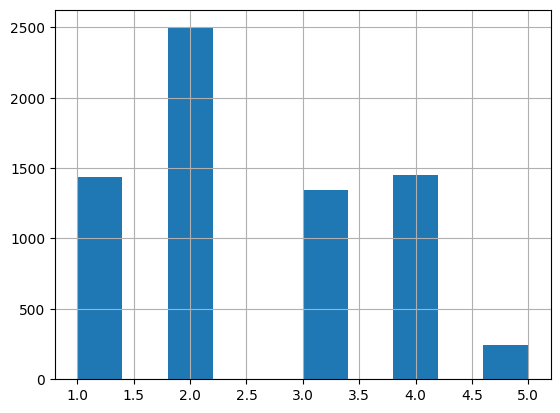

In [609]:
##################################
# "PitchSatisfactionScore"の処理 #
##################################
# all_df["PitchSatisfactionScore"].isnull().sum()
# all_df["PitchSatisfactionScore"].value_counts()
all_df["PitchSatisfactionScore"].hist()

In [610]:
#########################
# "Designation"の処理 #
#########################
# all_df["Designation"].isnull().sum()
# all_df["Designation"].value_counts()

In [611]:
# ギリシャ文字をアルファベットに変換
greek_string = "αβγδεζηθικλμνξοπρστυφχψωвꓢѕꭰտᗞı𐊡Аае"
alphabet_string = "abgdezhqiklmnxoprstufcywbssdsdibaae"

def greek_to_alphabet(text):
    result = ""
    for char in text:
        if char in greek_string:
            result += alphabet_string[greek_string.index(char)]
        else:
            result += char  # ギリシャ文字以外の文字はそのまま
    return result

In [612]:
# 文字を変換する
prefix = 0
for i in range(len(all_df)):
  prefix = unicodedata.normalize("NFKC", greek_to_alphabet(all_df.loc[i,"Designation"][:1].lower())).lower()

  # Executive: 取締役、執行役員
  if(prefix == "e"):
    all_df.loc[i,"Designation"] = "Executive"

  # Vice President: 本部長
  elif(prefix == "v"):
    all_df.loc[i,"Designation"] = "VP"

  # Associate Vice President: 本部長補佐
  elif(prefix == "a"):
    all_df.loc[i,"Designation"] = "AVP"

  # Senior Manager: 次長
  elif(prefix == "s"):
    all_df.loc[i,"Designation"] = "Senior Manager"

  # Manager: 課長
  elif(prefix == "m"):
    all_df.loc[i,"Designation"] = "Manager"

In [613]:
# 分類の確認
all_df["Designation"].value_counts()

,count
Designation,
Executive,2330
Manager,2117
Senior Manager,1632
AVP,635
VP,264


300000.0
506745.0
474960.0
386752.5
336195.0


<Axes: >

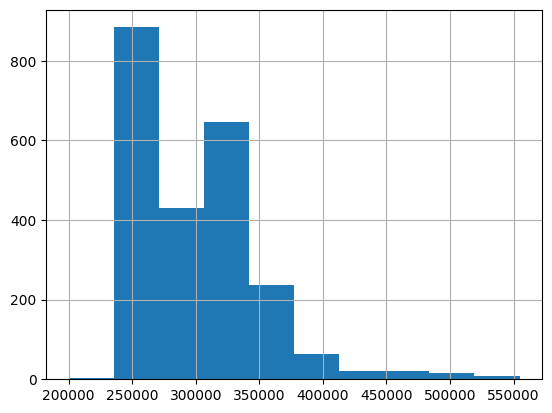

In [614]:
# 最頻値で確認
print(all_df.loc[all_df["Designation"]=="Executive","MonthlyIncome"].median())
print(all_df.loc[all_df["Designation"]=="VP","MonthlyIncome"].median())
print(all_df.loc[all_df["Designation"]=="AVP","MonthlyIncome"].median())
print(all_df.loc[all_df["Designation"]=="Senior Manager","MonthlyIncome"].median())
print(all_df.loc[all_df["Designation"]=="Manager","MonthlyIncome"].median())

all_df.loc[all_df["Designation"]=="Executive","MonthlyIncome"].hist()

In [615]:
Executive = all_df.loc[all_df["Designation"]=="Executive","MonthlyIncome"].median()
VP = all_df.loc[all_df["Designation"]=="VP","MonthlyIncome"].median()
AVP = all_df.loc[all_df["Designation"]=="AVP","MonthlyIncome"].median()
Senior = all_df.loc[all_df["Designation"]=="Senior Manager","MonthlyIncome"].median()
Manager = all_df.loc[all_df["Designation"]=="Manager","MonthlyIncome"].median()

print(round((Manager - Executive)/Executive*10))
print(round((Senior - Executive)/Executive*10))
print(round((AVP - Executive)/Executive*10))
print(round((VP - Executive)/Executive*10))

1
3
6
7


In [616]:
# 「Dsignation」をラベルエンコード
# 社長はほとんどが個人事業主のため給料安い。そのため低く見積もる
# all_df["Designation_LE"] = 1
# all_df.loc[all_df["Designation"]=="VP","Designation_LE"] = 10
# all_df.loc[all_df["Designation"]=="AVP","Designation_LE"] = 8
# all_df.loc[all_df["Designation"]=="Senior Manager","Designation_LE"] = 6
# all_df.loc[all_df["Designation"]=="Manager","Designation_LE"] = 4
# all_df.loc[all_df["Designation"]=="Executive","Designation_LE"] = 2

In [617]:
all_df["Designation_LE"] = 1
all_df.loc[all_df["Designation"]=="Executive","Designation_LE"] = 5
all_df.loc[all_df["Designation"]=="VP","Designation_LE"] = 4
all_df.loc[all_df["Designation"]=="AVP","Designation_LE"] = 3
all_df.loc[all_df["Designation"]=="Senior Manager","Designation_LE"] = 2
all_df.loc[all_df["Designation"]=="Manager","Designation_LE"] = 1

In [618]:
# 元の列を削除
all_df = all_df.drop("Designation", axis=1)

In [619]:
#########################
# "customer_info"の処理 #
#########################
import re

# 項目名
cont = []

# 区切り文字で分割する
for i in range(max_row):
  tmp = re.split("[ 　,、\n\t/／\u3000]",all_df.loc[i,"customer_info"])
  tmp = list(filter(None, tmp))
  if(type(tmp)==list):
    for j in range(len(tmp)):
      if(tmp[j] not in cont):
        cont.append(tmp[j])

# キーワード抽出
c_car = [] # 車関係
c_child = [] # 子供関係
c_married = [] # 婚姻関係
c_other = [] # その他

for i in range(len(cont)):
  # 「車あり」、「車所持」、「自家用車あり」、「車保有」、「乗用車所持」、「自動車保有」
  # 「車なし」、「車未所持」、「自家用車なし」、「車保有なし」、「乗用車なし」、「自動車未所有」
  if((cont[i][0:1] == "車") or (cont[i][0:1] == "自") or (cont[i][0:1] == "乗")):
    c_car.append(cont[i])
  # 「こども1人」、「1児」、「子供1人」、「子供有り(1人)」、「子供有り」
  # 「こども2人」、「2児」、「子供2人」、「子供有り(2人)」
  # 「こども3人」、「3児」「子供3人」、「子供有り(3人)」
  # 「子供なし」、「子供無し」、「無子」、「子供ゼロ」、「非児童家庭」
  # 「子育て状況不明」、「子の数不詳」、「子供の数不明」
  elif((cont[i][0:1] == "子") or (cont[i][0:1] == "こ") or (cont[i][-1:] == "児") or (cont[i][-1:] == "子") or (cont[i][-1:] == "庭")):
    c_child.append(cont[i])
  # 「結婚済み」、「離婚済み」、「未婚」、「独身」
  elif((cont[i][0:1] == "結") or (cont[i][0:1] == "離") or (cont[i][0:1] == "独") or (cont[i][0:1] == "離") or (cont[i][0:1] == "未")):
    c_married.append(cont[i])
  # 「1人」、「2人」、「3人」、「不明」、「わからない」
  else:
    c_other.append(cont[i])

In [620]:
# 新たなカラムを追加
all_df["CarHolder"] = 0 # 車所有
all_df["NumofChild"] = 0 # 子供の数
all_df["Married"] = "Single" # 婚姻歴

# 車
c_car_hold = ["車あり","車所持","自家用車あり","車保有","乗用車所持","自動車保有"]

# 子供
c_child_1 = ["こども1人","1児""子供1人","子供有り(1人)","子供有り"]
c_child_2 = ["こども2人","2児""子供2人","子供有り(2人)"]
c_child_3 = ["こども3人","3児""子供3人","子供有り(3人)"]

# 婚姻状況
c_pair = ["結婚済み"]
c_batu = ["離婚済み"]

# 区切り文字で分割する
for i in range(max_row):
  tmp = re.split("[ 　,、\n\t/／\u3000]",all_df.loc[i,"customer_info"])
  tmp = list(filter(None, tmp))
  if(type(tmp)==list):
    for j in range(len(tmp)):
      # 車の情報
      if(tmp[j] in c_car_hold):
        all_df.loc[i, "CarHolder"] = 1
      # 子供の情報
      if(tmp[j] in c_child_1):
        all_df.loc[i, "NumofChild"] = 1
      if(tmp[j] in c_child_2):
        all_df.loc[i, "NumofChild"] = 2
      if(tmp[j] in c_child_3):
        all_df.loc[i, "NumofChild"] = 3
      # 婚姻歴
      if(tmp[j] in c_pair):
        all_df.loc[i, "Married"] = "Married"
      if(tmp[j] in c_batu):
        all_df.loc[i, "Married"] = "Divorce"

# 使用済みカラム抹消
all_df = all_df.drop("customer_info", axis=1)

In [621]:
# 「CarHolder」をラベルエンコード
# all_df["CarHolder_LE"] = all_df["CarHolder"] + 1

In [622]:
# 車保有率
all_df["CarHolder"].value_counts()

,count
CarHolder,
0,4408
1,2570


In [623]:
# all_df = all_df.drop("CarHolder", axis=1)

In [624]:
# 子供の数
all_df["NumofChild"].value_counts()

,count
NumofChild,
0,5015
1,1347
2,571
3,45


In [625]:
# 「Married」をラベルエンコード
all_df["Married_LE"] = 1
all_df.loc[all_df["Married"]=="Married","Married_LE"]=3
all_df.loc[all_df["Married"]=="Divorce","Married_LE"]=2
all_df.loc[all_df["Married"]=="Single","Married_LE"]=1

In [626]:
# 婚姻歴
all_df["Married"].value_counts()

,count
Married,
Married,2846
Single,2444
Divorce,1688


In [627]:
all_df = all_df.drop("Married", axis=1)

# 特徴量エンジニアリング

In [387]:
# Logを取る
# all_df["MonthlyIncomeLOG"] = np.log1p(all_df["MonthlyIncome"])
# all_df["AgeLOG"] = np.log1p(all_df["Age"])

# # 削除する
# all_df = all_df.drop("Age", axis=1)
# all_df = all_df.drop("MonthlyIncome", axis=1)

In [628]:
# 検討の結果、重要度が低いものを抹消する
# Occupation_LE, NumberOfFollowups, PreferredPropertyStar,Gender_LE
# all_df = all_df.drop("Gender_LE", axis=1)
all_df = all_df.drop("NumofChild", axis=1)
# all_df = all_df.drop("CarHolder", axis=1)
# all_df = all_df.drop("Occupation_LE", axis=1)
# all_df = all_df.drop("NumberOfFollowups", axis=1)
all_df = all_df.drop("PreferredPropertyStar", axis=1)

In [518]:
# all_df = all_df.drop("NumberOfFollowups", axis=1)

In [389]:
# クロス特徴量
# all_df["Designation_LE_ProductPitched_LE"] = all_df["Designation_LE"] * all_df["ProductPitched_LE"]

In [ ]:
all_df.columns

Index(['id', 'CityTier', 'DurationOfPitch', 'NumberOfPersonVisiting',
       'NumberOfFollowups', 'PreferredPropertyStar', 'NumberOfTrips',
       'Passport', 'PitchSatisfactionScore', 'ProdTaken', 'NumofChild',
       'Designation_LE', 'Occupation_LE', 'CarHolder_LE', 'ProductPitched_LE',
       'Married_LE', 'TypeofContact_LE', 'MonthlyIncomeLOG', 'AgeLOG',
       'Designation_LE_ProductPitched_LE'],
      dtype='object')

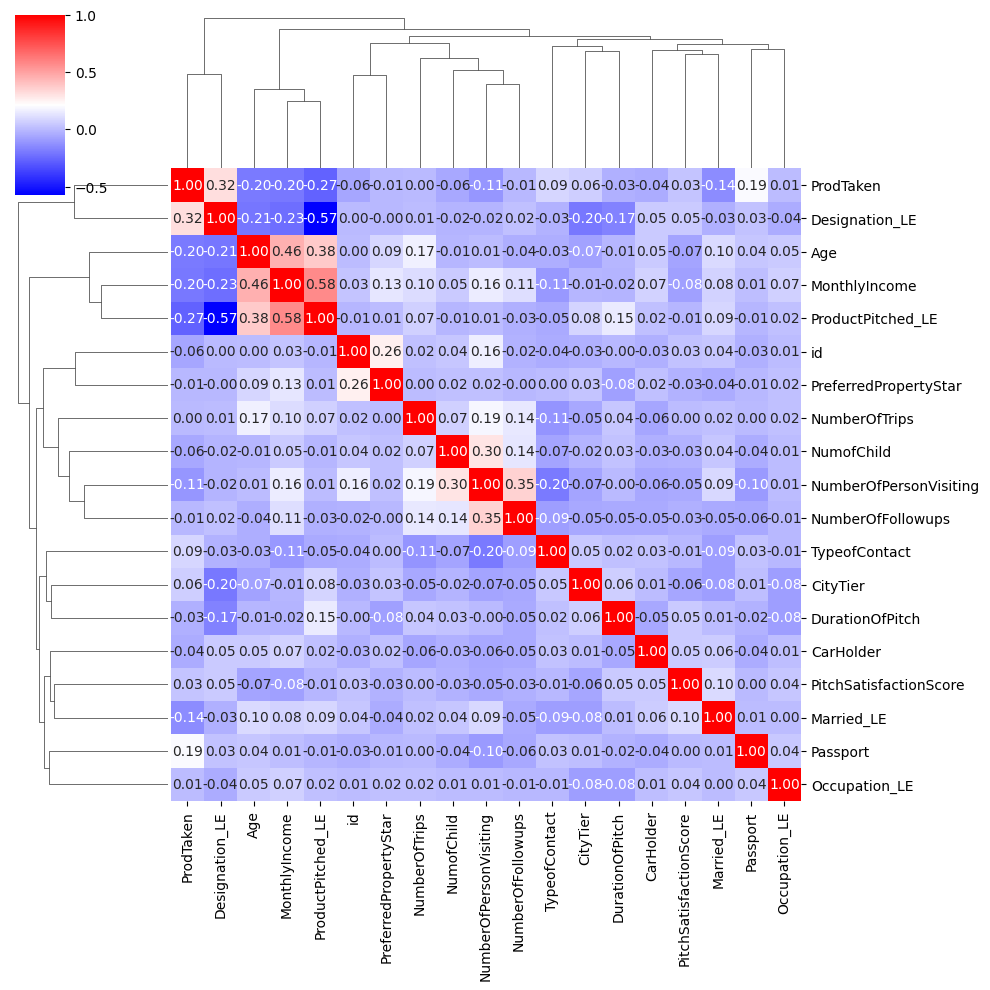

In [449]:
import seaborn as sns
import matplotlib.pyplot as plt

all_df_corr = all_df.corr()

# sns.heatmap(all_df_corr,annot=True,cmap="bwr")
# sns.heatmap(all_df_corr,annot=False,cmap="bwr")
# plt.show()
sns.clustermap(all_df_corr,annot=True,fmt=".2f",cmap="bwr")
plt.show()

# ここで一つの区切り

# ここから学習

In [629]:
# 取り除く変数
RMV = ["id","ProdTaken"]
RMV2 = ["id"]

FEATURES = [c for c in all_df.columns if c not in RMV2]
TARGET = "ProdTaken"

In [630]:
CATS = []
for c in FEATURES:
  if all_df[c].dtype == "object":
    CATS.append(c)

In [631]:
# カラムを制限
all_df2 = all_df[FEATURES]

# 結合を戻す
train = all_df2.iloc[:len(train_df)].copy()
test = all_df2.iloc[len(train_df):].reset_index(drop=True).copy()

# 対象の列のみ取り込み
test = test.drop(TARGET,axis=1)
FEATURES = test.columns

In [632]:
# Optunaを使用する
import optuna
import lightgbm as lgb
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
import lightgbm as lgb
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold

FOLDS = 3 # 分割数
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=26)

def objective(trial):

  lgbm_params = {
      'objective': 'binary',
      "device": "cpu",
      'metric': 'auc',
      'verbose': -1,              # ログ出力の制御
      'boosting_type': 'gbdt',
      # 'learning_rate': 0.01,

      'num_leaves': trial.suggest_int('num_leaves', 16, 256),
      'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
      'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
      'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1),
      'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
      'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0,log=True),
      'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0,log=True),
      'max_depth': trial.suggest_int('max_depth', 3, 12),

      # 'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
      }

  for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    # インデックスに割り振る

    x_train = train.loc[train_index, FEATURES].copy()
    y_train = train.loc[train_index, TARGET]
    x_valid = train.loc[test_index, FEATURES].copy()
    y_valid = train.loc[test_index, TARGET]
    # x_test = test[FEATURES].copy()

    # データセット作成
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

    # 学習
    model_lgb = lgb.train(lgbm_params,
                          lgb_train,
                          num_boost_round = 2000,
                          valid_sets = [lgb_train, lgb_eval],
                          valid_names = ["train", "valid"],
                          callbacks = [
                              lgb.early_stopping(stopping_rounds=100, verbose=False),
                              # lgb.record_evaluation(evaluations_result),
                              lgb.log_evaluation(100),])

    oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)

  score = roc_auc_score(train[TARGET],oof_lgb)

  return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2025-05-24 00:29:56,157] A new study created in memory with name: no-name-db563554-e86a-498b-9687-b330cc77dd11
<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.905505	valid's auc: 0.816202
#########################
### Fold 2
#########################
[100]	train's auc: 0.897229	valid's auc: 0.846153
#########################
### Fold 3
#########################


[I 2025-05-24 00:29:59,188] Trial 0 finished with value: 0.8201145374923337 and parameters: {'num_leaves': 26, 'min_data_in_leaf': 32, 'feature_fraction': 0.8125530692289844, 'bagging_fraction': 0.6075761871760725, 'bagging_freq': 7, 'lambda_l1': 0.001880461580847472, 'lambda_l2': 5.284604391531304e-05, 'max_depth': 3}. Best is trial 0 with value: 0.8201145374923337.


[100]	train's auc: 0.90485	valid's auc: 0.809449
#########################
### Fold 1
#########################


<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.986936	valid's auc: 0.811042
#########################
### Fold 2
#########################
[100]	train's auc: 0.987313	valid's auc: 0.832612
#########################
### Fold 3
#########################
[100]	train's auc: 0.986139	valid's auc: 0.813148


[I 2025-05-24 00:29:59,838] Trial 1 finished with value: 0.8276604816062149 and parameters: {'num_leaves': 201, 'min_data_in_leaf': 60, 'feature_fraction': 0.5560071473153823, 'bagging_fraction': 0.9670554556121027, 'bagging_freq': 4, 'lambda_l1': 0.049237126692720234, 'lambda_l2': 0.0012700059455804217, 'max_depth': 12}. Best is trial 1 with value: 0.8276604816062149.
<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.939145	valid's auc: 0.819942
#########################
### Fold 2
#########################
[100]	train's auc: 0.938041	valid's auc: 0.84402
#########################
### Fold 3
#########################
[100]	train's auc: 0.939442	valid's auc: 0.814714


[I 2025-05-24 00:30:00,366] Trial 2 finished with value: 0.8270549096719354 and parameters: {'num_leaves': 119, 'min_data_in_leaf': 99, 'feature_fraction': 0.6255586125935517, 'bagging_fraction': 0.7895380293826514, 'bagging_freq': 1, 'lambda_l1': 3.9255885580700666e-07, 'lambda_l2': 6.144207263926578e-05, 'max_depth': 8}. Best is trial 1 with value: 0.8276604816062149.
<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.908496	valid's auc: 0.817797
#########################
### Fold 2
#########################
[100]	train's auc: 0.907959	valid's auc: 0.845543
#########################
### Fold 3
#########################
[100]	train's auc: 0.90693	valid's auc: 0.820805


[I 2025-05-24 00:30:00,920] Trial 3 finished with value: 0.8302354232345946 and parameters: {'num_leaves': 54, 'min_data_in_leaf': 89, 'feature_fraction': 0.5493584349524836, 'bagging_fraction': 0.5229472163827192, 'bagging_freq': 6, 'lambda_l1': 1.7370185411260412e-08, 'lambda_l2': 1.5587098919343594e-05, 'max_depth': 6}. Best is trial 3 with value: 0.8302354232345946.
<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.993576	valid's auc: 0.80915
#########################
### Fold 2
#########################
[100]	train's auc: 0.993793	valid's auc: 0.826189
#########################
### Fold 3
#########################


[I 2025-05-24 00:30:01,467] Trial 4 finished with value: 0.8077805065688246 and parameters: {'num_leaves': 178, 'min_data_in_leaf': 47, 'feature_fraction': 0.8609831579281668, 'bagging_fraction': 0.8741062918071778, 'bagging_freq': 5, 'lambda_l1': 4.682371455050915e-06, 'lambda_l2': 0.1031532180202063, 'max_depth': 11}. Best is trial 3 with value: 0.8302354232345946.


[100]	train's auc: 0.994539	valid's auc: 0.805854
#########################
### Fold 1
#########################


<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.999765	valid's auc: 0.802963
#########################
### Fold 2
#########################
[100]	train's auc: 0.9999	valid's auc: 0.824183
#########################
### Fold 3
#########################


[I 2025-05-24 00:30:02,390] Trial 5 finished with value: 0.8098648710444485 and parameters: {'num_leaves': 189, 'min_data_in_leaf': 22, 'feature_fraction': 0.9668076462176465, 'bagging_fraction': 0.8404136999327201, 'bagging_freq': 6, 'lambda_l1': 5.1127518777615254e-05, 'lambda_l2': 0.5196869879598569, 'max_depth': 12}. Best is trial 3 with value: 0.8302354232345946.


[100]	train's auc: 0.99995	valid's auc: 0.800662
#########################
### Fold 1
#########################


<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.895104	valid's auc: 0.819706
#########################
### Fold 2
#########################


[I 2025-05-24 00:30:02,876] Trial 6 finished with value: 0.8291806319198616 and parameters: {'num_leaves': 229, 'min_data_in_leaf': 80, 'feature_fraction': 0.8763170872163433, 'bagging_fraction': 0.9091022799107016, 'bagging_freq': 3, 'lambda_l1': 1.7069491951271905e-08, 'lambda_l2': 1.188976532239958, 'max_depth': 3}. Best is trial 3 with value: 0.8302354232345946.


[100]	train's auc: 0.895692	valid's auc: 0.85321
#########################
### Fold 3
#########################
[100]	train's auc: 0.901699	valid's auc: 0.813785
#########################
### Fold 1
#########################


<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.900097	valid's auc: 0.820038
#########################
### Fold 2
#########################
[100]	train's auc: 0.898815	valid's auc: 0.848322


[I 2025-05-24 00:30:03,366] Trial 7 finished with value: 0.8291648285434532 and parameters: {'num_leaves': 230, 'min_data_in_leaf': 70, 'feature_fraction': 0.610683106308961, 'bagging_fraction': 0.9664152626437048, 'bagging_freq': 2, 'lambda_l1': 0.0012767926646012166, 'lambda_l2': 0.0001537021144535435, 'max_depth': 3}. Best is trial 3 with value: 0.8302354232345946.


#########################
### Fold 3
#########################
[100]	train's auc: 0.903297	valid's auc: 0.813894
#########################
### Fold 1
#########################


<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.988389	valid's auc: 0.811398
#########################
### Fold 2
#########################
[100]	train's auc: 0.990131	valid's auc: 0.828063
#########################
### Fold 3
#########################
[100]	train's auc: 0.990943	valid's auc: 0.807488


[I 2025-05-24 00:30:03,947] Trial 8 finished with value: 0.822439987518695 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 14, 'feature_fraction': 0.5428153750144178, 'bagging_fraction': 0.5917983547692915, 'bagging_freq': 1, 'lambda_l1': 3.632910743614351e-05, 'lambda_l2': 6.042949327056824e-08, 'max_depth': 6}. Best is trial 3 with value: 0.8302354232345946.
<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.996896	valid's auc: 0.817029
#########################
### Fold 2
#########################
[100]	train's auc: 0.996393	valid's auc: 0.83199
#########################
### Fold 3
#########################
[100]	train's auc: 0.997804	valid's auc: 0.806492


[I 2025-05-24 00:30:04,612] Trial 9 finished with value: 0.8093178052270844 and parameters: {'num_leaves': 235, 'min_data_in_leaf': 19, 'feature_fraction': 0.570935000205339, 'bagging_fraction': 0.9782445559551126, 'bagging_freq': 3, 'lambda_l1': 5.606154756260894e-05, 'lambda_l2': 8.136377247097419e-05, 'max_depth': 7}. Best is trial 3 with value: 0.8302354232345946.
<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.855757	valid's auc: 0.825694
[200]	train's auc: 0.866087	valid's auc: 0.827742
#########################
### Fold 2
#########################
[100]	train's auc: 0.847793	valid's auc: 0.857543
[200]	train's auc: 0.857287	valid's auc: 0.858394
#########################
### Fold 3
#########################
[100]	train's auc: 0.862752	valid's auc: 0.810196


[I 2025-05-24 00:30:05,383] Trial 10 finished with value: 0.8328312118701513 and parameters: {'num_leaves': 89, 'min_data_in_leaf': 97, 'feature_fraction': 0.6887121701326917, 'bagging_fraction': 0.5099100648790983, 'bagging_freq': 7, 'lambda_l1': 6.68820557317467, 'lambda_l2': 1.1238778101121487e-07, 'max_depth': 9}. Best is trial 10 with value: 0.8328312118701513.


[200]	train's auc: 0.872648	valid's auc: 0.813451
#########################
### Fold 1
#########################


<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.874743	valid's auc: 0.827821
#########################
### Fold 2
#########################
[100]	train's auc: 0.869209	valid's auc: 0.860183
[200]	train's auc: 0.887388	valid's auc: 0.855923
#########################
### Fold 3
#########################
[100]	train's auc: 0.87413	valid's auc: 0.812328
[200]	train's auc: 0.893273	valid's auc: 0.817046


[I 2025-05-24 00:30:06,184] Trial 11 finished with value: 0.834495610023779 and parameters: {'num_leaves': 89, 'min_data_in_leaf': 100, 'feature_fraction': 0.7012163958562468, 'bagging_fraction': 0.5045469780527205, 'bagging_freq': 7, 'lambda_l1': 3.508717560989415, 'lambda_l2': 6.618685466740334e-08, 'max_depth': 9}. Best is trial 11 with value: 0.834495610023779.


[300]	train's auc: 0.904743	valid's auc: 0.821534
[400]	train's auc: 0.913803	valid's auc: 0.81738
#########################
### Fold 1
#########################


<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.894602	valid's auc: 0.824492
#########################
### Fold 2
#########################
[100]	train's auc: 0.893279	valid's auc: 0.849392
#########################
### Fold 3
#########################
[100]	train's auc: 0.897057	valid's auc: 0.815589
[200]	train's auc: 0.921179	valid's auc: 0.816566


[I 2025-05-24 00:30:06,864] Trial 12 finished with value: 0.8296537244859531 and parameters: {'num_leaves': 112, 'min_data_in_leaf': 100, 'feature_fraction': 0.6948899612772124, 'bagging_fraction': 0.6785788474642205, 'bagging_freq': 7, 'lambda_l1': 2.530308621673362, 'lambda_l2': 1.116467167939467e-08, 'max_depth': 9}. Best is trial 11 with value: 0.834495610023779.
<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.853851	valid's auc: 0.825044
[200]	train's auc: 0.853897	valid's auc: 0.82525
#########################
### Fold 2
#########################
[100]	train's auc: 0.840776	valid's auc: 0.85541
[200]	train's auc: 0.850717	valid's auc: 0.858056
#########################
### Fold 3
#########################
[100]	train's auc: 0.857335	valid's auc: 0.806109
[200]	train's auc: 0.863852	valid's auc: 0.80971


[I 2025-05-24 00:30:07,651] Trial 13 finished with value: 0.8289513148409171 and parameters: {'num_leaves': 91, 'min_data_in_leaf': 82, 'feature_fraction': 0.7158331029876097, 'bagging_fraction': 0.5010328631589798, 'bagging_freq': 6, 'lambda_l1': 8.66201042110601, 'lambda_l2': 7.624087555573422e-07, 'max_depth': 10}. Best is trial 11 with value: 0.834495610023779.


[300]	train's auc: 0.867122	valid's auc: 0.811532
#########################
### Fold 1
#########################


<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.951433	valid's auc: 0.822431
[200]	train's auc: 0.985461	valid's auc: 0.817797
#########################
### Fold 2
#########################
[100]	train's auc: 0.953439	valid's auc: 0.830516
#########################
### Fold 3
#########################
[100]	train's auc: 0.952383	valid's auc: 0.810998


[I 2025-05-24 00:30:08,343] Trial 14 finished with value: 0.8260048257459194 and parameters: {'num_leaves': 150, 'min_data_in_leaf': 71, 'feature_fraction': 0.7727397571691625, 'bagging_fraction': 0.6884001558516639, 'bagging_freq': 7, 'lambda_l1': 0.1797908710013651, 'lambda_l2': 5.845161140696168e-07, 'max_depth': 9}. Best is trial 11 with value: 0.834495610023779.
<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.916806	valid's auc: 0.820274
[200]	train's auc: 0.949171	valid's auc: 0.816546
#########################
### Fold 2
#########################
[100]	train's auc: 0.916365	valid's auc: 0.842932
#########################
### Fold 3
#########################
[100]	train's auc: 0.916071	valid's auc: 0.81353


[I 2025-05-24 00:30:11,829] Trial 15 finished with value: 0.8280216055692443 and parameters: {'num_leaves': 83, 'min_data_in_leaf': 89, 'feature_fraction': 0.6698805226725225, 'bagging_fraction': 0.5753559500558616, 'bagging_freq': 5, 'lambda_l1': 0.18854527093928344, 'lambda_l2': 9.29180544663857e-07, 'max_depth': 10}. Best is trial 11 with value: 0.834495610023779.
<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.971577	valid's auc: 0.805235
#########################
### Fold 2
#########################


[I 2025-05-24 00:30:12,383] Trial 16 finished with value: 0.8169111594701902 and parameters: {'num_leaves': 151, 'min_data_in_leaf': 51, 'feature_fraction': 0.7545658030545488, 'bagging_fraction': 0.6529189141668975, 'bagging_freq': 5, 'lambda_l1': 0.014028974108906684, 'lambda_l2': 1.1610059430424914e-08, 'max_depth': 8}. Best is trial 11 with value: 0.834495610023779.


[100]	train's auc: 0.96994	valid's auc: 0.833893
#########################
### Fold 3
#########################
[100]	train's auc: 0.964961	valid's auc: 0.808453


<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.91824	valid's auc: 0.827114
#########################
### Fold 2
#########################
[100]	train's auc: 0.917994	valid's auc: 0.843875
#########################
### Fold 3
#########################
[100]	train's auc: 0.920487	valid's auc: 0.812127


[I 2025-05-24 00:30:12,912] Trial 17 finished with value: 0.829688693659282 and parameters: {'num_leaves': 73, 'min_data_in_leaf': 90, 'feature_fraction': 0.6457739593751208, 'bagging_fraction': 0.7432836955668884, 'bagging_freq': 7, 'lambda_l1': 1.063646875428883, 'lambda_l2': 0.004092759748111972, 'max_depth': 6}. Best is trial 11 with value: 0.834495610023779.
<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.962757	valid's auc: 0.819054
#########################
### Fold 2
#########################


[I 2025-05-24 00:30:13,468] Trial 18 finished with value: 0.8210637488029783 and parameters: {'num_leaves': 23, 'min_data_in_leaf': 38, 'feature_fraction': 0.8194513386628641, 'bagging_fraction': 0.537566952544739, 'bagging_freq': 6, 'lambda_l1': 0.766453451022989, 'lambda_l2': 4.861628912600952e-06, 'max_depth': 10}. Best is trial 11 with value: 0.834495610023779.


[100]	train's auc: 0.963001	valid's auc: 0.820727
#########################
### Fold 3
#########################
[100]	train's auc: 0.958315	valid's auc: 0.806965


<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.929405	valid's auc: 0.829996
#########################
### Fold 2
#########################
[100]	train's auc: 0.934306	valid's auc: 0.831017
#########################
### Fold 3
#########################
[100]	train's auc: 0.93738	valid's auc: 0.807974


[I 2025-05-24 00:30:14,035] Trial 19 finished with value: 0.8297825051915774 and parameters: {'num_leaves': 119, 'min_data_in_leaf': 65, 'feature_fraction': 0.9328043951372273, 'bagging_fraction': 0.6301765170797471, 'bagging_freq': 4, 'lambda_l1': 0.009488240150296312, 'lambda_l2': 9.845279343602832e-08, 'max_depth': 5}. Best is trial 11 with value: 0.834495610023779.
<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.861628	valid's auc: 0.825144
[200]	train's auc: 0.870191	valid's auc: 0.824733
#########################
### Fold 2
#########################
[100]	train's auc: 0.849326	valid's auc: 0.855887
[200]	train's auc: 0.862395	valid's auc: 0.856286
#########################
### Fold 3
#########################
[100]	train's auc: 0.863545	valid's auc: 0.808174
[200]	train's auc: 0.870375	valid's auc: 0.812382
[300]	train's auc: 0.876495	valid's auc: 0.815358


[I 2025-05-24 00:30:14,983] Trial 20 finished with value: 0.8318742669923282 and parameters: {'num_leaves': 65, 'min_data_in_leaf': 80, 'feature_fraction': 0.5032012202403964, 'bagging_fraction': 0.5607046925409165, 'bagging_freq': 4, 'lambda_l1': 6.8532010869824775, 'lambda_l2': 0.012727120406991015, 'max_depth': 9}. Best is trial 11 with value: 0.834495610023779.


[400]	train's auc: 0.882991	valid's auc: 0.817204
[500]	train's auc: 0.886411	valid's auc: 0.818789
[600]	train's auc: 0.889871	valid's auc: 0.819014


<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.859885	valid's auc: 0.826522
[200]	train's auc: 0.868416	valid's auc: 0.828516
#########################
### Fold 2
#########################
[100]	train's auc: 0.846777	valid's auc: 0.856975
[200]	train's auc: 0.860237	valid's auc: 0.856443
#########################
### Fold 3
#########################
[100]	train's auc: 0.862764	valid's auc: 0.808799
[200]	train's auc: 0.868305	valid's auc: 0.814581


[I 2025-05-24 00:30:15,909] Trial 21 finished with value: 0.8336711445141436 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 100, 'feature_fraction': 0.5134462244523972, 'bagging_fraction': 0.5446706297646176, 'bagging_freq': 4, 'lambda_l1': 6.614690003657005, 'lambda_l2': 0.01941580043287871, 'max_depth': 9}. Best is trial 11 with value: 0.834495610023779.


[300]	train's auc: 0.873943	valid's auc: 0.817502
[400]	train's auc: 0.880372	valid's auc: 0.81823
[500]	train's auc: 0.884373	valid's auc: 0.817313


<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.899315	valid's auc: 0.82402
#########################
### Fold 2
#########################
[100]	train's auc: 0.895817	valid's auc: 0.850413
#########################
### Fold 3
#########################
[100]	train's auc: 0.90598	valid's auc: 0.817653


[I 2025-05-24 00:30:16,493] Trial 22 finished with value: 0.8307115419791476 and parameters: {'num_leaves': 102, 'min_data_in_leaf': 99, 'feature_fraction': 0.7258627172639869, 'bagging_fraction': 0.5010033297282191, 'bagging_freq': 3, 'lambda_l1': 0.39895743319917576, 'lambda_l2': 0.05068162746164633, 'max_depth': 8}. Best is trial 11 with value: 0.834495610023779.


[200]	train's auc: 0.934039	valid's auc: 0.807366
#########################
### Fold 1
#########################
[100]	train's auc: 0.855728	valid's auc: 0.824733


<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[200]	train's auc: 0.863627	valid's auc: 0.827174
#########################
### Fold 2
#########################
[100]	train's auc: 0.843117	valid's auc: 0.855627
[200]	train's auc: 0.8518	valid's auc: 0.857355
#########################
### Fold 3
#########################
[100]	train's auc: 0.857823	valid's auc: 0.806686


[I 2025-05-24 00:30:17,219] Trial 23 finished with value: 0.8311506740980643 and parameters: {'num_leaves': 43, 'min_data_in_leaf': 92, 'feature_fraction': 0.5914852834928227, 'bagging_fraction': 0.5585381197919769, 'bagging_freq': 6, 'lambda_l1': 8.553331024515339, 'lambda_l2': 0.0012383933299700005, 'max_depth': 11}. Best is trial 11 with value: 0.834495610023779.


[200]	train's auc: 0.863219	valid's auc: 0.809783
#########################
### Fold 1
#########################


<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.943293	valid's auc: 0.821652
#########################
### Fold 2
#########################
[100]	train's auc: 0.944243	valid's auc: 0.841428
#########################
### Fold 3
#########################
[100]	train's auc: 0.944359	valid's auc: 0.815066


[I 2025-05-24 00:30:17,849] Trial 24 finished with value: 0.8313678864631641 and parameters: {'num_leaves': 136, 'min_data_in_leaf': 76, 'feature_fraction': 0.5064160710953394, 'bagging_fraction': 0.7108092351658196, 'bagging_freq': 2, 'lambda_l1': 0.055952446494392245, 'lambda_l2': 9.275231172859695e-08, 'max_depth': 7}. Best is trial 11 with value: 0.834495610023779.
<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.899652	valid's auc: 0.822498
#########################
### Fold 2
#########################
[100]	train's auc: 0.898989	valid's auc: 0.848032
#########################
### Fold 3
#########################
[100]	train's auc: 0.902252	valid's auc: 0.811113


[I 2025-05-24 00:30:18,422] Trial 25 finished with value: 0.8270905513293665 and parameters: {'num_leaves': 91, 'min_data_in_leaf': 94, 'feature_fraction': 0.6686960938861867, 'bagging_fraction': 0.6112605930138626, 'bagging_freq': 5, 'lambda_l1': 1.5956904679547836, 'lambda_l2': 5.841420779892432e-06, 'max_depth': 9}. Best is trial 11 with value: 0.834495610023779.
<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.886964	valid's auc: 0.825198
[200]	train's auc: 0.912843	valid's auc: 0.830673
#########################
### Fold 2
#########################
[100]	train's auc: 0.883434	valid's auc: 0.851422
#########################
### Fold 3
#########################


[I 2025-05-24 00:30:19,175] Trial 26 finished with value: 0.8286113741271157 and parameters: {'num_leaves': 42, 'min_data_in_leaf': 85, 'feature_fraction': 0.7756827556515596, 'bagging_fraction': 0.552857893492854, 'bagging_freq': 7, 'lambda_l1': 0.07276125769872419, 'lambda_l2': 9.539384604930865, 'max_depth': 11}. Best is trial 11 with value: 0.834495610023779.


[100]	train's auc: 0.887867	valid's auc: 0.813336
[200]	train's auc: 0.917095	valid's auc: 0.813318
#########################
### Fold 1
#########################


<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.898296	valid's auc: 0.824757
#########################
### Fold 2
#########################
[100]	train's auc: 0.892126	valid's auc: 0.850987
#########################
### Fold 3
#########################
[100]	train's auc: 0.89597	valid's auc: 0.819445


[I 2025-05-24 00:30:19,829] Trial 27 finished with value: 0.8326509861306878 and parameters: {'num_leaves': 74, 'min_data_in_leaf': 95, 'feature_fraction': 0.6442081463089717, 'bagging_fraction': 0.6421684723560181, 'bagging_freq': 2, 'lambda_l1': 2.1961591521538253, 'lambda_l2': 0.0008831924730073943, 'max_depth': 10}. Best is trial 11 with value: 0.834495610023779.


[200]	train's auc: 0.925924	valid's auc: 0.815801
#########################
### Fold 1
#########################


<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.915288	valid's auc: 0.821199
#########################
### Fold 2
#########################
[100]	train's auc: 0.913853	valid's auc: 0.843059
#########################
### Fold 3
#########################


[I 2025-05-24 00:30:20,408] Trial 28 finished with value: 0.8302011265453684 and parameters: {'num_leaves': 17, 'min_data_in_leaf': 86, 'feature_fraction': 0.69182120488621, 'bagging_fraction': 0.5266147213774868, 'bagging_freq': 6, 'lambda_l1': 0.017702840154785567, 'lambda_l2': 0.02147670015044241, 'max_depth': 8}. Best is trial 11 with value: 0.834495610023779.


[100]	train's auc: 0.916283	valid's auc: 0.818601
#########################
### Fold 1
#########################


<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.93395	valid's auc: 0.822105
#########################
### Fold 2
#########################
[100]	train's auc: 0.943134	valid's auc: 0.834177
#########################
### Fold 3
#########################


[I 2025-05-24 00:30:20,980] Trial 29 finished with value: 0.8260377774669406 and parameters: {'num_leaves': 42, 'min_data_in_leaf': 72, 'feature_fraction': 0.8034803555265115, 'bagging_fraction': 0.5993395163445201, 'bagging_freq': 7, 'lambda_l1': 0.0027846929113083704, 'lambda_l2': 1.5827757007281865e-05, 'max_depth': 7}. Best is trial 11 with value: 0.834495610023779.


[100]	train's auc: 0.935679	valid's auc: 0.817629
[200]	train's auc: 0.973355	valid's auc: 0.806947
#########################
### Fold 1
#########################


<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.968944	valid's auc: 0.803591
#########################
### Fold 2
#########################
[100]	train's auc: 0.973435	valid's auc: 0.815549
#########################
### Fold 3
#########################
[100]	train's auc: 0.968895	valid's auc: 0.806024


[I 2025-05-24 00:30:21,620] Trial 30 finished with value: 0.8149475058909608 and parameters: {'num_leaves': 133, 'min_data_in_leaf': 38, 'feature_fraction': 0.8304053651290816, 'bagging_fraction': 0.5010561243818942, 'bagging_freq': 7, 'lambda_l1': 0.0005698900140344666, 'lambda_l2': 4.565504472395713e-08, 'max_depth': 9}. Best is trial 11 with value: 0.834495610023779.
<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.892437	valid's auc: 0.827452
#########################
### Fold 2
#########################
[100]	train's auc: 0.88592	valid's auc: 0.847869
#########################
### Fold 3
#########################
[100]	train's auc: 0.890406	valid's auc: 0.818164


[I 2025-05-24 00:30:25,116] Trial 31 finished with value: 0.8291890379711424 and parameters: {'num_leaves': 71, 'min_data_in_leaf': 95, 'feature_fraction': 0.644667013144317, 'bagging_fraction': 0.6348436261734365, 'bagging_freq': 2, 'lambda_l1': 2.8463040640853463, 'lambda_l2': 0.0011225455484931805, 'max_depth': 10}. Best is trial 11 with value: 0.834495610023779.


[200]	train's auc: 0.913779	valid's auc: 0.817307
#########################
### Fold 1
#########################


<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.912706	valid's auc: 0.824963
#########################
### Fold 2
#########################
[100]	train's auc: 0.909302	valid's auc: 0.843948


[I 2025-05-24 00:30:25,769] Trial 32 finished with value: 0.8321802472589547 and parameters: {'num_leaves': 84, 'min_data_in_leaf': 100, 'feature_fraction': 0.7312172007105293, 'bagging_fraction': 0.5787737690146529, 'bagging_freq': 3, 'lambda_l1': 0.2885142312066704, 'lambda_l2': 0.00038017953655464264, 'max_depth': 10}. Best is trial 11 with value: 0.834495610023779.


#########################
### Fold 3
#########################
[100]	train's auc: 0.914716	valid's auc: 0.816512


<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.881825	valid's auc: 0.829646
[200]	train's auc: 0.905786	valid's auc: 0.827114
#########################
### Fold 2
#########################
[100]	train's auc: 0.878459	valid's auc: 0.854521
#########################
### Fold 3
#########################
[100]	train's auc: 0.888057	valid's auc: 0.817089
[200]	train's auc: 0.906717	valid's auc: 0.821267
[300]	train's auc: 0.921451	valid's auc: 0.822524


[I 2025-05-24 00:30:26,523] Trial 33 finished with value: 0.834316056768418 and parameters: {'num_leaves': 105, 'min_data_in_leaf': 95, 'feature_fraction': 0.5891130148062957, 'bagging_fraction': 0.544527050935355, 'bagging_freq': 4, 'lambda_l1': 2.586527128756747, 'lambda_l2': 0.006291455283619241, 'max_depth': 11}. Best is trial 11 with value: 0.834495610023779.
<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.90004	valid's auc: 0.825911
#########################
### Fold 2
#########################
[100]	train's auc: 0.897643	valid's auc: 0.85434
#########################
### Fold 3
#########################
[100]	train's auc: 0.903501	valid's auc: 0.815832


[I 2025-05-24 00:30:27,165] Trial 34 finished with value: 0.8272775019098548 and parameters: {'num_leaves': 112, 'min_data_in_leaf': 94, 'feature_fraction': 0.532363379664702, 'bagging_fraction': 0.5423215926170151, 'bagging_freq': 4, 'lambda_l1': 0.7327377515671637, 'lambda_l2': 0.006444707727934868, 'max_depth': 12}. Best is trial 11 with value: 0.834495610023779.


[200]	train's auc: 0.933129	valid's auc: 0.8167
#########################
### Fold 1
#########################


<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.858998	valid's auc: 0.826763
[200]	train's auc: 0.865773	valid's auc: 0.826733
#########################
### Fold 2
#########################
[100]	train's auc: 0.846742	valid's auc: 0.858304


[I 2025-05-24 00:30:27,805] Trial 35 finished with value: 0.8328251595132291 and parameters: {'num_leaves': 101, 'min_data_in_leaf': 60, 'feature_fraction': 0.6001660766129846, 'bagging_fraction': 0.523849267241668, 'bagging_freq': 4, 'lambda_l1': 7.873569423410037, 'lambda_l2': 0.23985188845633554, 'max_depth': 11}. Best is trial 11 with value: 0.834495610023779.


[200]	train's auc: 0.854014	valid's auc: 0.858243
#########################
### Fold 3
#########################
[100]	train's auc: 0.863982	valid's auc: 0.812771


<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.949717	valid's auc: 0.815779
#########################
### Fold 2
#########################


[I 2025-05-24 00:30:28,323] Trial 36 finished with value: 0.8278840825702881 and parameters: {'num_leaves': 56, 'min_data_in_leaf': 85, 'feature_fraction': 0.5720975723423986, 'bagging_fraction': 0.8022826376524915, 'bagging_freq': 5, 'lambda_l1': 1.8197327882980047e-07, 'lambda_l2': 0.0030990185107180627, 'max_depth': 8}. Best is trial 11 with value: 0.834495610023779.


[100]	train's auc: 0.949066	valid's auc: 0.842322
#########################
### Fold 3
#########################
[100]	train's auc: 0.949173	valid's auc: 0.805465


<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.910683	valid's auc: 0.819634
#########################
### Fold 2
#########################
[100]	train's auc: 0.910153	valid's auc: 0.843875
#########################
### Fold 3
#########################
[100]	train's auc: 0.912639	valid's auc: 0.813652


[I 2025-05-24 00:30:28,922] Trial 37 finished with value: 0.8270955949601351 and parameters: {'num_leaves': 100, 'min_data_in_leaf': 100, 'feature_fraction': 0.6286766720960075, 'bagging_fraction': 0.5945780363968195, 'bagging_freq': 5, 'lambda_l1': 0.0969892331376982, 'lambda_l2': 2.5226731680423753e-07, 'max_depth': 12}. Best is trial 11 with value: 0.834495610023779.
<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.880727	valid's auc: 0.827615
#########################
### Fold 2
#########################
[100]	train's auc: 0.87571	valid's auc: 0.854147
[200]	train's auc: 0.898951	valid's auc: 0.849144
#########################
### Fold 3
#########################
[100]	train's auc: 0.886767	valid's auc: 0.816475
[200]	train's auc: 0.903409	valid's auc: 0.821024
[300]	train's auc: 0.915833	valid's auc: 0.822554


[I 2025-05-24 00:30:29,816] Trial 38 finished with value: 0.8351539719601028 and parameters: {'num_leaves': 131, 'min_data_in_leaf': 78, 'feature_fraction': 0.5324014161274282, 'bagging_fraction': 0.5307606899822889, 'bagging_freq': 4, 'lambda_l1': 3.2973740001233454, 'lambda_l2': 0.06953914416554341, 'max_depth': 11}. Best is trial 38 with value: 0.8351539719601028.


[400]	train's auc: 0.927829	valid's auc: 0.820295
#########################
### Fold 1
#########################


<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.910386	valid's auc: 0.825797
#########################
### Fold 2
#########################
[100]	train's auc: 0.908723	valid's auc: 0.852074
#########################
### Fold 3
#########################
[100]	train's auc: 0.912675	valid's auc: 0.821704


[I 2025-05-24 00:30:30,484] Trial 39 finished with value: 0.8323382810230365 and parameters: {'num_leaves': 165, 'min_data_in_leaf': 75, 'feature_fraction': 0.5290889715671503, 'bagging_fraction': 0.5697034240485832, 'bagging_freq': 4, 'lambda_l1': 0.5173984124874068, 'lambda_l2': 1.1573141123303816, 'max_depth': 11}. Best is trial 38 with value: 0.8351539719601028.


[200]	train's auc: 0.945058	valid's auc: 0.823125
#########################
### Fold 1
#########################


<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.926266	valid's auc: 0.824365
#########################
### Fold 2
#########################
[100]	train's auc: 0.921964	valid's auc: 0.847512
#########################
### Fold 3
#########################
[100]	train's auc: 0.931992	valid's auc: 0.809965


[I 2025-05-24 00:30:31,163] Trial 40 finished with value: 0.829310085109588 and parameters: {'num_leaves': 214, 'min_data_in_leaf': 88, 'feature_fraction': 0.5793762765742294, 'bagging_fraction': 0.6174105861656676, 'bagging_freq': 3, 'lambda_l1': 0.004103312219431899, 'lambda_l2': 0.03176368072847764, 'max_depth': 12}. Best is trial 38 with value: 0.8351539719601028.


[200]	train's auc: 0.963771	valid's auc: 0.809225
#########################
### Fold 1
#########################
[100]	train's auc: 0.879746	valid's auc: 0.828177


<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.876228	valid's auc: 0.856697
[200]	train's auc: 0.898738	valid's auc: 0.851821
#########################
### Fold 3
#########################
[100]	train's auc: 0.886045	valid's auc: 0.815892
[200]	train's auc: 0.904028	valid's auc: 0.821157
[300]	train's auc: 0.917744	valid's auc: 0.821704
[400]	train's auc: 0.930176	valid's auc: 0.818449


[I 2025-05-24 00:30:32,042] Trial 41 finished with value: 0.8350799987088305 and parameters: {'num_leaves': 127, 'min_data_in_leaf': 94, 'feature_fraction': 0.5553114378922946, 'bagging_fraction': 0.5329797309282601, 'bagging_freq': 4, 'lambda_l1': 2.6687656705934395, 'lambda_l2': 0.09596865558251114, 'max_depth': 11}. Best is trial 38 with value: 0.8351539719601028.
<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.882792	valid's auc: 0.826933
#########################
### Fold 2
#########################
[100]	train's auc: 0.876998	valid's auc: 0.853337
#########################
### Fold 3
#########################
[100]	train's auc: 0.888643	valid's auc: 0.820769
[200]	train's auc: 0.907975	valid's auc: 0.825269
[300]	train's auc: 0.921453	valid's auc: 0.827054


[I 2025-05-24 00:30:32,906] Trial 42 finished with value: 0.834287812436114 and parameters: {'num_leaves': 130, 'min_data_in_leaf': 81, 'feature_fraction': 0.5397893882192657, 'bagging_fraction': 0.5404912732520509, 'bagging_freq': 4, 'lambda_l1': 2.9204796422486763, 'lambda_l2': 0.11625305293329596, 'max_depth': 11}. Best is trial 38 with value: 0.8351539719601028.


[400]	train's auc: 0.932904	valid's auc: 0.82519
#########################
### Fold 1
#########################


<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.891825	valid's auc: 0.826208
#########################
### Fold 2
#########################
[100]	train's auc: 0.892109	valid's auc: 0.850056
#########################
### Fold 3
#########################
[100]	train's auc: 0.896705	valid's auc: 0.81466
[200]	train's auc: 0.921158	valid's auc: 0.814532


[I 2025-05-24 00:30:33,553] Trial 43 finished with value: 0.8314875886334048 and parameters: {'num_leaves': 131, 'min_data_in_leaf': 79, 'feature_fraction': 0.5590026432978931, 'bagging_fraction': 0.5805532818347783, 'bagging_freq': 3, 'lambda_l1': 2.4209731281597815, 'lambda_l2': 0.1462310536196502, 'max_depth': 11}. Best is trial 38 with value: 0.8351539719601028.
<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.929775	valid's auc: 0.823126
#########################
### Fold 2
#########################
[100]	train's auc: 0.933719	valid's auc: 0.843386
#########################
### Fold 3
#########################
[100]	train's auc: 0.936366	valid's auc: 0.814392


[I 2025-05-24 00:30:34,129] Trial 44 finished with value: 0.8306873325514585 and parameters: {'num_leaves': 158, 'min_data_in_leaf': 63, 'feature_fraction': 0.5483809564132764, 'bagging_fraction': 0.525683838772874, 'bagging_freq': 4, 'lambda_l1': 4.250399049973827e-06, 'lambda_l2': 0.45198768094949615, 'max_depth': 11}. Best is trial 38 with value: 0.8351539719601028.
<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.92243	valid's auc: 0.82402
#########################
### Fold 2
#########################
[100]	train's auc: 0.921877	valid's auc: 0.845174
#########################
### Fold 3
#########################


[I 2025-05-24 00:30:34,771] Trial 45 finished with value: 0.8259560706484899 and parameters: {'num_leaves': 173, 'min_data_in_leaf': 82, 'feature_fraction': 0.6123591768369798, 'bagging_fraction': 0.9386102415174464, 'bagging_freq': 4, 'lambda_l1': 1.2146624628029101, 'lambda_l2': 5.188110515939517, 'max_depth': 12}. Best is trial 38 with value: 0.8351539719601028.


[100]	train's auc: 0.923084	valid's auc: 0.813937
#########################
### Fold 1
#########################


<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.971919	valid's auc: 0.813271
#########################
### Fold 2
#########################
[100]	train's auc: 0.970316	valid's auc: 0.835362
#########################
### Fold 3
#########################
[100]	train's auc: 0.972105	valid's auc: 0.814872


[I 2025-05-24 00:30:38,301] Trial 46 finished with value: 0.8257946744638958 and parameters: {'num_leaves': 120, 'min_data_in_leaf': 68, 'feature_fraction': 0.5318000287131809, 'bagging_fraction': 0.855739665242372, 'bagging_freq': 5, 'lambda_l1': 0.030376412790957458, 'lambda_l2': 0.07072512043303912, 'max_depth': 11}. Best is trial 38 with value: 0.8351539719601028.
<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.905539	valid's auc: 0.824377
#########################
### Fold 2
#########################
[100]	train's auc: 0.900472	valid's auc: 0.844697
#########################
### Fold 3
#########################
[100]	train's auc: 0.907126	valid's auc: 0.819081


[I 2025-05-24 00:30:38,912] Trial 47 finished with value: 0.8305138316530197 and parameters: {'num_leaves': 142, 'min_data_in_leaf': 90, 'feature_fraction': 0.5641346218575045, 'bagging_fraction': 0.5255344931990281, 'bagging_freq': 3, 'lambda_l1': 0.16051025920790474, 'lambda_l2': 1.2735891039484133, 'max_depth': 12}. Best is trial 38 with value: 0.8351539719601028.
<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.917372	valid's auc: 0.826244
[200]	train's auc: 0.949885	valid's auc: 0.820618
#########################
### Fold 2
#########################
[100]	train's auc: 0.915202	valid's auc: 0.843265
#########################
### Fold 3
#########################


[I 2025-05-24 00:30:39,605] Trial 48 finished with value: 0.830700782233508 and parameters: {'num_leaves': 126, 'min_data_in_leaf': 76, 'feature_fraction': 0.5977084423121185, 'bagging_fraction': 0.5520402373214193, 'bagging_freq': 5, 'lambda_l1': 0.5008980675015297, 'lambda_l2': 0.23492853186566728, 'max_depth': 10}. Best is trial 38 with value: 0.8351539719601028.


[100]	train's auc: 0.917016	valid's auc: 0.817423
#########################
### Fold 1
#########################


<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.897755	valid's auc: 0.822183
[200]	train's auc: 0.928062	valid's auc: 0.819289
#########################
### Fold 2
#########################
[100]	train's auc: 0.897882	valid's auc: 0.848467
#########################
### Fold 3
#########################
[100]	train's auc: 0.905259	valid's auc: 0.813257


[I 2025-05-24 00:30:40,338] Trial 49 finished with value: 0.8271823454093544 and parameters: {'num_leaves': 112, 'min_data_in_leaf': 54, 'feature_fraction': 0.6246538168083615, 'bagging_fraction': 0.6799353443305164, 'bagging_freq': 4, 'lambda_l1': 2.5496245688289654, 'lambda_l2': 0.008519640840864089, 'max_depth': 4}. Best is trial 38 with value: 0.8351539719601028.


[200]	train's auc: 0.92985	valid's auc: 0.816093
#########################
### Fold 1
#########################


<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.952275	valid's auc: 0.820002
#########################
### Fold 2
#########################
[100]	train's auc: 0.951963	valid's auc: 0.840358


[I 2025-05-24 00:30:40,957] Trial 50 finished with value: 0.8283739872389416 and parameters: {'num_leaves': 253, 'min_data_in_leaf': 84, 'feature_fraction': 0.5828293965194261, 'bagging_fraction': 0.7979958504280439, 'bagging_freq': 3, 'lambda_l1': 0.0001121790532477826, 'lambda_l2': 0.0027382232004835535, 'max_depth': 10}. Best is trial 38 with value: 0.8351539719601028.


#########################
### Fold 3
#########################
[100]	train's auc: 0.953345	valid's auc: 0.812722


<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.864809	valid's auc: 0.829198
[200]	train's auc: 0.876062	valid's auc: 0.828739
#########################
### Fold 2
#########################
[100]	train's auc: 0.855473	valid's auc: 0.858086
[200]	train's auc: 0.872111	valid's auc: 0.855742
#########################
### Fold 3
#########################
[100]	train's auc: 0.87052	valid's auc: 0.811514
[200]	train's auc: 0.880248	valid's auc: 0.818376


[I 2025-05-24 00:30:41,767] Trial 51 finished with value: 0.835342267508796 and parameters: {'num_leaves': 191, 'min_data_in_leaf': 96, 'feature_fraction': 0.5121066978285114, 'bagging_fraction': 0.5437128766476028, 'bagging_freq': 4, 'lambda_l1': 5.000004265031409, 'lambda_l2': 0.018358303013095698, 'max_depth': 11}. Best is trial 51 with value: 0.835342267508796.


[300]	train's auc: 0.888932	valid's auc: 0.819579
#########################
### Fold 1
#########################


<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.878229	valid's auc: 0.829126
[200]	train's auc: 0.895327	valid's auc: 0.829138
#########################
### Fold 2
#########################
[100]	train's auc: 0.872241	valid's auc: 0.856159
#########################
### Fold 3
#########################
[100]	train's auc: 0.879116	valid's auc: 0.817386


[I 2025-05-24 00:30:42,433] Trial 52 finished with value: 0.8327841379829781 and parameters: {'num_leaves': 182, 'min_data_in_leaf': 92, 'feature_fraction': 0.5265942672589736, 'bagging_fraction': 0.5163074764262238, 'bagging_freq': 1, 'lambda_l1': 2.8683486619166896, 'lambda_l2': 0.10060966974801303, 'max_depth': 11}. Best is trial 51 with value: 0.835342267508796.


[200]	train's auc: 0.898509	valid's auc: 0.817902
#########################
### Fold 1
#########################
[100]	train's auc: 0.874013	valid's auc: 0.825235


<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.86431	valid's auc: 0.857506
[200]	train's auc: 0.885283	valid's auc: 0.854376
#########################
### Fold 3
#########################
[100]	train's auc: 0.876545	valid's auc: 0.814824
[200]	train's auc: 0.890068	valid's auc: 0.818522


[I 2025-05-24 00:30:43,250] Trial 53 finished with value: 0.833339609851623 and parameters: {'num_leaves': 197, 'min_data_in_leaf': 96, 'feature_fraction': 0.548377090548594, 'bagging_fraction': 0.587413241924164, 'bagging_freq': 4, 'lambda_l1': 4.432808503316295, 'lambda_l2': 0.04360037685752527, 'max_depth': 11}. Best is trial 51 with value: 0.835342267508796.


[300]	train's auc: 0.900111	valid's auc: 0.818388
#########################
### Fold 1
#########################


<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.893112	valid's auc: 0.8266
#########################
### Fold 2
#########################
[100]	train's auc: 0.886025	valid's auc: 0.855271
[200]	train's auc: 0.914393	valid's auc: 0.849392
#########################
### Fold 3
#########################
[100]	train's auc: 0.896488	valid's auc: 0.815704


[I 2025-05-24 00:30:44,045] Trial 54 finished with value: 0.8338870119110383 and parameters: {'num_leaves': 140, 'min_data_in_leaf': 88, 'feature_fraction': 0.5138128516497774, 'bagging_fraction': 0.5380011381083234, 'bagging_freq': 4, 'lambda_l1': 1.2476522653574906, 'lambda_l2': 0.7576433954853397, 'max_depth': 12}. Best is trial 51 with value: 0.835342267508796.


[200]	train's auc: 0.920126	valid's auc: 0.818844
[300]	train's auc: 0.937542	valid's auc: 0.818358
#########################
### Fold 1
#########################


<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.923199	valid's auc: 0.823295
#########################
### Fold 2
#########################
[100]	train's auc: 0.922665	valid's auc: 0.841476
#########################
### Fold 3
#########################
[100]	train's auc: 0.922966	valid's auc: 0.814635


[I 2025-05-24 00:30:44,689] Trial 55 finished with value: 0.8291154009619212 and parameters: {'num_leaves': 157, 'min_data_in_leaf': 92, 'feature_fraction': 0.5499900933691326, 'bagging_fraction': 0.6599418644683728, 'bagging_freq': 5, 'lambda_l1': 0.23950271720817165, 'lambda_l2': 0.0002698484304703599, 'max_depth': 10}. Best is trial 51 with value: 0.835342267508796.
<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.870044	valid's auc: 0.82654
#########################
### Fold 2
#########################
[100]	train's auc: 0.859602	valid's auc: 0.858262
[200]	train's auc: 0.880091	valid's auc: 0.857512
#########################
### Fold 3
#########################
[100]	train's auc: 0.870526	valid's auc: 0.813354
[200]	train's auc: 0.883054	valid's auc: 0.820356
[300]	train's auc: 0.892015	valid's auc: 0.822178


[I 2025-05-24 00:30:45,538] Trial 56 finished with value: 0.8351694390944597 and parameters: {'num_leaves': 111, 'min_data_in_leaf': 97, 'feature_fraction': 0.5027606096938082, 'bagging_fraction': 0.5648800067734133, 'bagging_freq': 4, 'lambda_l1': 4.192986496638095, 'lambda_l2': 2.566359998242116, 'max_depth': 11}. Best is trial 51 with value: 0.835342267508796.
<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.850641	valid's auc: 0.825579
[200]	train's auc: 0.856742	valid's auc: 0.827942
[300]	train's auc: 0.860265	valid's auc: 0.82909
[400]	train's auc: 0.862054	valid's auc: 0.82967
#########################
### Fold 2
#########################
[100]	train's auc: 0.835266	valid's auc: 0.855675
[200]	train's auc: 0.842976	valid's auc: 0.858334
#########################
### Fold 3
#########################
[100]	train's auc: 0.856413	valid's auc: 0.808365
[200]	train's auc: 0.862323	valid's auc: 0.81138


[I 2025-05-24 00:30:46,581] Trial 57 finished with value: 0.8306402586642851 and parameters: {'num_leaves': 108, 'min_data_in_leaf': 96, 'feature_fraction': 0.5030938503199811, 'bagging_fraction': 0.5145591138527431, 'bagging_freq': 5, 'lambda_l1': 9.346161242952784, 'lambda_l2': 3.569281687557729e-05, 'max_depth': 12}. Best is trial 51 with value: 0.835342267508796.


[300]	train's auc: 0.863491	valid's auc: 0.812789
#########################
### Fold 1
#########################


<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.898533	valid's auc: 0.81741
#########################
### Fold 2
#########################
[100]	train's auc: 0.897373	valid's auc: 0.848666
#########################
### Fold 3
#########################
[100]	train's auc: 0.90332	valid's auc: 0.814647


[I 2025-05-24 00:30:47,198] Trial 58 finished with value: 0.8278971960102863 and parameters: {'num_leaves': 146, 'min_data_in_leaf': 90, 'feature_fraction': 0.9060695930720178, 'bagging_fraction': 0.6127537290454893, 'bagging_freq': 6, 'lambda_l1': 1.1074377750051718, 'lambda_l2': 2.740650405689324, 'max_depth': 10}. Best is trial 51 with value: 0.835342267508796.


[200]	train's auc: 0.935557	valid's auc: 0.807142
#########################
### Fold 1
#########################


<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.869003	valid's auc: 0.826262
[200]	train's auc: 0.879057	valid's auc: 0.824546
#########################
### Fold 2
#########################
[100]	train's auc: 0.8605	valid's auc: 0.855536
#########################
### Fold 3
#########################


[I 2025-05-24 00:30:50,928] Trial 59 finished with value: 0.8330551490762759 and parameters: {'num_leaves': 95, 'min_data_in_leaf': 98, 'feature_fraction': 0.5187716591017059, 'bagging_fraction': 0.565536137433303, 'bagging_freq': 3, 'lambda_l1': 4.843505003507876, 'lambda_l2': 0.32753367559375196, 'max_depth': 11}. Best is trial 51 with value: 0.835342267508796.


[100]	train's auc: 0.871666	valid's auc: 0.812874
[200]	train's auc: 0.882372	valid's auc: 0.816992


<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.911937	valid's auc: 0.825277
#########################
### Fold 2
#########################
[100]	train's auc: 0.906581	valid's auc: 0.850485
#########################
### Fold 3
#########################
[100]	train's auc: 0.917566	valid's auc: 0.81288


[I 2025-05-24 00:30:51,540] Trial 60 finished with value: 0.8342279613509938 and parameters: {'num_leaves': 119, 'min_data_in_leaf': 87, 'feature_fraction': 0.5005707890579336, 'bagging_fraction': 0.565430310738545, 'bagging_freq': 4, 'lambda_l1': 0.14079092306109908, 'lambda_l2': 0.02032257257233096, 'max_depth': 9}. Best is trial 51 with value: 0.835342267508796.
<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.874613	valid's auc: 0.828975
#########################
### Fold 2
#########################
[100]	train's auc: 0.867098	valid's auc: 0.857077
#########################
### Fold 3
#########################
[100]	train's auc: 0.877471	valid's auc: 0.814757
[200]	train's auc: 0.890828	valid's auc: 0.819864
[300]	train's auc: 0.902158	valid's auc: 0.821164


[I 2025-05-24 00:30:52,416] Trial 61 finished with value: 0.8336644196731189 and parameters: {'num_leaves': 123, 'min_data_in_leaf': 92, 'feature_fraction': 0.5367219342292896, 'bagging_fraction': 0.5375060428396522, 'bagging_freq': 4, 'lambda_l1': 3.926160507581688, 'lambda_l2': 0.1205002404597646, 'max_depth': 11}. Best is trial 51 with value: 0.835342267508796.


[400]	train's auc: 0.911848	valid's auc: 0.820623
#########################
### Fold 1
#########################


<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.900299	valid's auc: 0.826987
#########################
### Fold 2
#########################
[100]	train's auc: 0.898505	valid's auc: 0.854014
#########################
### Fold 3
#########################
[100]	train's auc: 0.902895	valid's auc: 0.820781
[200]	train's auc: 0.932747	valid's auc: 0.823216


[I 2025-05-24 00:30:53,088] Trial 62 finished with value: 0.835747775422589 and parameters: {'num_leaves': 104, 'min_data_in_leaf': 81, 'feature_fraction': 0.5678381884040189, 'bagging_fraction': 0.5460703137597361, 'bagging_freq': 4, 'lambda_l1': 0.4478864452408769, 'lambda_l2': 2.7706370487489393, 'max_depth': 11}. Best is trial 62 with value: 0.835747775422589.
<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.94043	valid's auc: 0.828842
#########################
### Fold 2
#########################
[100]	train's auc: 0.946582	valid's auc: 0.84767
#########################
### Fold 3
#########################


[I 2025-05-24 00:30:53,851] Trial 63 finished with value: 0.831674539213893 and parameters: {'num_leaves': 106, 'min_data_in_leaf': 25, 'feature_fraction': 0.5611616180647068, 'bagging_fraction': 0.5005260881901972, 'bagging_freq': 4, 'lambda_l1': 0.5934731333595943, 'lambda_l2': 2.810646269873952, 'max_depth': 10}. Best is trial 62 with value: 0.835747775422589.


[100]	train's auc: 0.942794	valid's auc: 0.821291
[200]	train's auc: 0.974438	valid's auc: 0.817083
#########################
### Fold 1
#########################


<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.887327	valid's auc: 0.82483
#########################
### Fold 2
#########################
[100]	train's auc: 0.882336	valid's auc: 0.854576


[I 2025-05-24 00:30:54,384] Trial 64 finished with value: 0.8324142717266164 and parameters: {'num_leaves': 84, 'min_data_in_leaf': 97, 'feature_fraction': 0.6680125614016462, 'bagging_fraction': 0.5534088942159344, 'bagging_freq': 4, 'lambda_l1': 1.5055945213277009, 'lambda_l2': 2.8922718999915915, 'max_depth': 12}. Best is trial 62 with value: 0.835747775422589.


#########################
### Fold 3
#########################
[100]	train's auc: 0.888097	valid's auc: 0.813202


<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.860465	valid's auc: 0.821646
[200]	train's auc: 0.864328	valid's auc: 0.821555
#########################
### Fold 2
#########################
[100]	train's auc: 0.848803	valid's auc: 0.856467
[200]	train's auc: 0.85507	valid's auc: 0.858117
#########################
### Fold 3
#########################
[100]	train's auc: 0.866077	valid's auc: 0.809467


[I 2025-05-24 00:30:55,158] Trial 65 finished with value: 0.8303484005638109 and parameters: {'num_leaves': 95, 'min_data_in_leaf': 78, 'feature_fraction': 0.5630854374965208, 'bagging_fraction': 0.7667754538581055, 'bagging_freq': 4, 'lambda_l1': 9.766660491786826, 'lambda_l2': 0.011641638278377959, 'max_depth': 11}. Best is trial 62 with value: 0.835747775422589.


[200]	train's auc: 0.871219	valid's auc: 0.813919
#########################
### Fold 1
#########################


<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.938406	valid's auc: 0.818625
[200]	train's auc: 0.971265	valid's auc: 0.814788
#########################
### Fold 2
#########################
[100]	train's auc: 0.944129	valid's auc: 0.844745
#########################
### Fold 3
#########################
[100]	train's auc: 0.942344	valid's auc: 0.812176
[200]	train's auc: 0.973896	valid's auc: 0.821473


[I 2025-05-24 00:30:56,251] Trial 66 finished with value: 0.8280740593292374 and parameters: {'num_leaves': 115, 'min_data_in_leaf': 11, 'feature_fraction': 0.5860441874791943, 'bagging_fraction': 0.5973760454394907, 'bagging_freq': 3, 'lambda_l1': 0.31579225638496927, 'lambda_l2': 8.830416418845694, 'max_depth': 10}. Best is trial 62 with value: 0.835747775422589.


[300]	train's auc: 0.988911	valid's auc: 0.8165
#########################
### Fold 1
#########################
[100]	train's auc: 0.894646	valid's auc: 0.830824


<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.891386	valid's auc: 0.851343
#########################
### Fold 3
#########################


[I 2025-05-24 00:30:56,949] Trial 67 finished with value: 0.8163600587482114 and parameters: {'num_leaves': 79, 'min_data_in_leaf': 83, 'feature_fraction': 0.5227665509922674, 'bagging_fraction': 0.5153733990249949, 'bagging_freq': 5, 'lambda_l1': 0.8008106915389753, 'lambda_l2': 1.2946165311417654, 'max_depth': 12}. Best is trial 62 with value: 0.835747775422589.


[100]	train's auc: 0.896297	valid's auc: 0.817465
[200]	train's auc: 0.921824	valid's auc: 0.817769


<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.965506	valid's auc: 0.816637
#########################
### Fold 2
#########################
[100]	train's auc: 0.964352	valid's auc: 0.83292
#########################
### Fold 3
#########################
[100]	train's auc: 0.967306	valid's auc: 0.809959


[I 2025-05-24 00:30:57,600] Trial 68 finished with value: 0.823509909725734 and parameters: {'num_leaves': 106, 'min_data_in_leaf': 48, 'feature_fraction': 0.9714221003986941, 'bagging_fraction': 0.5778900259840839, 'bagging_freq': 4, 'lambda_l1': 0.03456014514560624, 'lambda_l2': 0.49972501561301563, 'max_depth': 9}. Best is trial 62 with value: 0.835747775422589.
<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.873219	valid's auc: 0.830159
#########################
### Fold 2
#########################
[100]	train's auc: 0.864026	valid's auc: 0.853748
#########################
### Fold 3
#########################
[100]	train's auc: 0.874746	valid's auc: 0.814277
[200]	train's auc: 0.887917	valid's auc: 0.817423
[300]	train's auc: 0.898018	valid's auc: 0.819718


[I 2025-05-24 00:30:58,395] Trial 69 finished with value: 0.8332044405470255 and parameters: {'num_leaves': 213, 'min_data_in_leaf': 93, 'feature_fraction': 0.6003567310395405, 'bagging_fraction': 0.5322410282829311, 'bagging_freq': 3, 'lambda_l1': 4.57444885189825, 'lambda_l2': 2.154453276128307e-06, 'max_depth': 11}. Best is trial 62 with value: 0.835747775422589.
<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.907124	valid's auc: 0.816776
#########################
### Fold 2
#########################
[100]	train's auc: 0.902109	valid's auc: 0.846884
#########################
### Fold 3
#########################
[100]	train's auc: 0.901957	valid's auc: 0.814526


[I 2025-05-24 00:30:58,974] Trial 70 finished with value: 0.8266504104842962 and parameters: {'num_leaves': 138, 'min_data_in_leaf': 98, 'feature_fraction': 0.6143702303615308, 'bagging_fraction': 0.5589955747543334, 'bagging_freq': 5, 'lambda_l1': 1.2171917513259939e-05, 'lambda_l2': 0.002382077787844977, 'max_depth': 5}. Best is trial 62 with value: 0.835747775422589.
<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.89502	valid's auc: 0.826492
[200]	train's auc: 0.925815	valid's auc: 0.824854
#########################
### Fold 2
#########################
[100]	train's auc: 0.89469	valid's auc: 0.853253
#########################
### Fold 3
#########################


[I 2025-05-24 00:30:59,726] Trial 71 finished with value: 0.8334707442516058 and parameters: {'num_leaves': 126, 'min_data_in_leaf': 71, 'feature_fraction': 0.5448568921907766, 'bagging_fraction': 0.5406303415970106, 'bagging_freq': 4, 'lambda_l1': 2.067177530752759, 'lambda_l2': 0.05430040291979687, 'max_depth': 11}. Best is trial 62 with value: 0.835747775422589.


[100]	train's auc: 0.902995	valid's auc: 0.820095
[200]	train's auc: 0.926954	valid's auc: 0.824989
[300]	train's auc: 0.944608	valid's auc: 0.824218


<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.871852	valid's auc: 0.828896
#########################
### Fold 2
#########################
[100]	train's auc: 0.861021	valid's auc: 0.853591
[200]	train's auc: 0.879892	valid's auc: 0.8537
#########################
### Fold 3
#########################


[I 2025-05-24 00:31:00,526] Trial 72 finished with value: 0.8350988282637 and parameters: {'num_leaves': 127, 'min_data_in_leaf': 81, 'feature_fraction': 0.574876538710741, 'bagging_fraction': 0.5117798759702998, 'bagging_freq': 4, 'lambda_l1': 4.37024639912838, 'lambda_l2': 0.189638505096487, 'max_depth': 11}. Best is trial 62 with value: 0.835747775422589.


[100]	train's auc: 0.877047	valid's auc: 0.817945
[200]	train's auc: 0.888219	valid's auc: 0.821528
[300]	train's auc: 0.898933	valid's auc: 0.821528


<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.865784	valid's auc: 0.827573
#########################
### Fold 2
#########################
[100]	train's auc: 0.854446	valid's auc: 0.856352
[200]	train's auc: 0.870337	valid's auc: 0.856328
#########################
### Fold 3
#########################
[100]	train's auc: 0.869618	valid's auc: 0.816275


[I 2025-05-24 00:31:04,140] Trial 73 finished with value: 0.8350537718288339 and parameters: {'num_leaves': 96, 'min_data_in_leaf': 87, 'feature_fraction': 0.5750196491658885, 'bagging_fraction': 0.5104941142981292, 'bagging_freq': 4, 'lambda_l1': 5.383191698126534, 'lambda_l2': 0.22132940099641052, 'max_depth': 10}. Best is trial 62 with value: 0.835747775422589.


[200]	train's auc: 0.877915	valid's auc: 0.820787
[300]	train's auc: 0.887021	valid's auc: 0.821516
#########################
### Fold 1
#########################


<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.893627	valid's auc: 0.828806
#########################
### Fold 2
#########################
[100]	train's auc: 0.886649	valid's auc: 0.856914
#########################
### Fold 3
#########################
[100]	train's auc: 0.897462	valid's auc: 0.820174
[200]	train's auc: 0.92146	valid's auc: 0.820234


[I 2025-05-24 00:31:04,760] Trial 74 finished with value: 0.8346765082473451 and parameters: {'num_leaves': 92, 'min_data_in_leaf': 87, 'feature_fraction': 0.571237366937853, 'bagging_fraction': 0.5071630389949762, 'bagging_freq': 4, 'lambda_l1': 1.334363726677933, 'lambda_l2': 0.20466740042952167, 'max_depth': 10}. Best is trial 62 with value: 0.835747775422589.
<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.90713	valid's auc: 0.827301
#########################
### Fold 2
#########################
[100]	train's auc: 0.904403	valid's auc: 0.85031
#########################
### Fold 3
#########################
[100]	train's auc: 0.913281	valid's auc: 0.82171


[I 2025-05-24 00:31:05,362] Trial 75 finished with value: 0.8280824653805183 and parameters: {'num_leaves': 94, 'min_data_in_leaf': 73, 'feature_fraction': 0.5719549326036428, 'bagging_fraction': 0.5140315830919802, 'bagging_freq': 4, 'lambda_l1': 0.8556471109686573, 'lambda_l2': 0.21760944233643448, 'max_depth': 10}. Best is trial 62 with value: 0.835747775422589.


[200]	train's auc: 0.942742	valid's auc: 0.820866
#########################
### Fold 1
#########################
[100]	train's auc: 0.883775	valid's auc: 0.821839


<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.879858	valid's auc: 0.855802
#########################
### Fold 3
#########################


[I 2025-05-24 00:31:05,930] Trial 76 finished with value: 0.8296554056962093 and parameters: {'num_leaves': 116, 'min_data_in_leaf': 79, 'feature_fraction': 0.5174864908540063, 'bagging_fraction': 0.9997609466074484, 'bagging_freq': 4, 'lambda_l1': 5.770205615544943, 'lambda_l2': 0.6909407429007269, 'max_depth': 10}. Best is trial 62 with value: 0.835747775422589.


[100]	train's auc: 0.885683	valid's auc: 0.815097
#########################
### Fold 1
#########################


<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.900528	valid's auc: 0.824951
#########################
### Fold 2
#########################
[100]	train's auc: 0.899004	valid's auc: 0.849386
#########################
### Fold 3
#########################


[I 2025-05-24 00:31:06,499] Trial 77 finished with value: 0.8321345183399865 and parameters: {'num_leaves': 153, 'min_data_in_leaf': 85, 'feature_fraction': 0.5736199781145553, 'bagging_fraction': 0.5097164491670114, 'bagging_freq': 3, 'lambda_l1': 0.41377215309496884, 'lambda_l2': 1.675634879242433, 'max_depth': 12}. Best is trial 62 with value: 0.835747775422589.


[100]	train's auc: 0.902858	valid's auc: 0.816008
#########################
### Fold 1
#########################


<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.926052	valid's auc: 0.822939
#########################
### Fold 2
#########################
[100]	train's auc: 0.931404	valid's auc: 0.841235
#########################
### Fold 3
#########################
[100]	train's auc: 0.927067	valid's auc: 0.815929


[I 2025-05-24 00:31:07,220] Trial 78 finished with value: 0.8296315325105714 and parameters: {'num_leaves': 63, 'min_data_in_leaf': 67, 'feature_fraction': 0.630745398674663, 'bagging_fraction': 0.7187381697449707, 'bagging_freq': 4, 'lambda_l1': 1.7779748250025278, 'lambda_l2': 0.030132102790709027, 'max_depth': 11}. Best is trial 62 with value: 0.835747775422589.
<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.86902	valid's auc: 0.830304
[200]	train's auc: 0.883674	valid's auc: 0.828836
#########################
### Fold 2
#########################
[100]	train's auc: 0.859174	valid's auc: 0.856836
#########################
### Fold 3
#########################
[100]	train's auc: 0.872686	valid's auc: 0.815054
[200]	train's auc: 0.883281	valid's auc: 0.818352
[300]	train's auc: 0.892731	valid's auc: 0.819864


[I 2025-05-24 00:31:08,143] Trial 79 finished with value: 0.8336065860403059 and parameters: {'num_leaves': 86, 'min_data_in_leaf': 87, 'feature_fraction': 0.5530007090435337, 'bagging_fraction': 0.5278001144456501, 'bagging_freq': 4, 'lambda_l1': 4.086629738892086, 'lambda_l2': 4.775121906950668, 'max_depth': 10}. Best is trial 62 with value: 0.835747775422589.


[400]	train's auc: 0.902259	valid's auc: 0.820004
#########################
### Fold 1
#########################


<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.860324	valid's auc: 0.819111
#########################
### Fold 2
#########################
[100]	train's auc: 0.849645	valid's auc: 0.860606
[200]	train's auc: 0.854759	valid's auc: 0.861826
[300]	train's auc: 0.856169	valid's auc: 0.862437
#########################
### Fold 3
#########################


[I 2025-05-24 00:31:08,966] Trial 80 finished with value: 0.8320975317143503 and parameters: {'num_leaves': 165, 'min_data_in_leaf': 90, 'feature_fraction': 0.5370177938591049, 'bagging_fraction': 0.8936158241745673, 'bagging_freq': 5, 'lambda_l1': 9.94565832196331, 'lambda_l2': 0.07389113046482244, 'max_depth': 11}. Best is trial 62 with value: 0.835747775422589.


[100]	train's auc: 0.86676	valid's auc: 0.813752
[200]	train's auc: 0.870913	valid's auc: 0.816527


<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.891118	valid's auc: 0.825718
#########################
### Fold 2
#########################
[100]	train's auc: 0.887903	valid's auc: 0.852848
#########################
### Fold 3
#########################
[100]	train's auc: 0.895673	valid's auc: 0.818218


[I 2025-05-24 00:31:09,636] Trial 81 finished with value: 0.8335954900526151 and parameters: {'num_leaves': 77, 'min_data_in_leaf': 82, 'feature_fraction': 0.6041153048885715, 'bagging_fraction': 0.5042974299128113, 'bagging_freq': 4, 'lambda_l1': 1.688800987972295, 'lambda_l2': 0.19241906128893518, 'max_depth': 9}. Best is trial 62 with value: 0.835747775422589.


[200]	train's auc: 0.920064	valid's auc: 0.816475
#########################
### Fold 1
#########################


<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.867244	valid's auc: 0.828081
[200]	train's auc: 0.880912	valid's auc: 0.826812
#########################
### Fold 2
#########################
[100]	train's auc: 0.8575	valid's auc: 0.858104
[200]	train's auc: 0.875197	valid's auc: 0.8546
#########################
### Fold 3
#########################
[100]	train's auc: 0.871181	valid's auc: 0.813463
[200]	train's auc: 0.880464	valid's auc: 0.817896
[300]	train's auc: 0.889349	valid's auc: 0.81916


[I 2025-05-24 00:31:10,576] Trial 82 finished with value: 0.8335998611992813 and parameters: {'num_leaves': 68, 'min_data_in_leaf': 90, 'feature_fraction': 0.7040442073298206, 'bagging_fraction': 0.5238022899311819, 'bagging_freq': 4, 'lambda_l1': 5.269062146534428, 'lambda_l2': 0.3807047436264421, 'max_depth': 10}. Best is trial 62 with value: 0.835747775422589.


[400]	train's auc: 0.898409	valid's auc: 0.817629
#########################
### Fold 1
#########################


<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.922958	valid's auc: 0.823966
[200]	train's auc: 0.96328	valid's auc: 0.815458
#########################
### Fold 2
#########################
[100]	train's auc: 0.923784	valid's auc: 0.842878
#########################
### Fold 3
#########################
[100]	train's auc: 0.930721	valid's auc: 0.810919


[I 2025-05-24 00:31:11,325] Trial 83 finished with value: 0.8267173226524924 and parameters: {'num_leaves': 98, 'min_data_in_leaf': 77, 'feature_fraction': 0.8557204517721891, 'bagging_fraction': 0.5560588439476529, 'bagging_freq': 4, 'lambda_l1': 3.267712437952256e-08, 'lambda_l2': 0.6842039223647165, 'max_depth': 11}. Best is trial 62 with value: 0.835747775422589.
<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.90334	valid's auc: 0.816395
#########################
### Fold 2
#########################
[100]	train's auc: 0.899172	valid's auc: 0.846588
#########################
### Fold 3
#########################
[100]	train's auc: 0.901266	valid's auc: 0.807433


[I 2025-05-24 00:31:11,958] Trial 84 finished with value: 0.8187409887130268 and parameters: {'num_leaves': 90, 'min_data_in_leaf': 100, 'feature_fraction': 0.7553189649318662, 'bagging_fraction': 0.5507767756273017, 'bagging_freq': 5, 'lambda_l1': 0.8141244178439775, 'lambda_l2': 1.9424538407464956e-08, 'max_depth': 10}. Best is trial 62 with value: 0.835747775422589.


[200]	train's auc: 0.933661	valid's auc: 0.810512
#########################
### Fold 1
#########################


<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.880664	valid's auc: 0.825766
#########################
### Fold 2
#########################
[100]	train's auc: 0.875832	valid's auc: 0.851984
#########################
### Fold 3
#########################
[100]	train's auc: 0.885711	valid's auc: 0.81186


[I 2025-05-24 00:31:12,768] Trial 85 finished with value: 0.8286234788409602 and parameters: {'num_leaves': 111, 'min_data_in_leaf': 74, 'feature_fraction': 0.5821531934894477, 'bagging_fraction': 0.5728944504619156, 'bagging_freq': 3, 'lambda_l1': 3.3732245090122834, 'lambda_l2': 1.9263953597015933, 'max_depth': 8}. Best is trial 62 with value: 0.835747775422589.


[200]	train's auc: 0.903767	valid's auc: 0.811204
#########################
### Fold 1
#########################


<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.878735	valid's auc: 0.829362
[200]	train's auc: 0.901129	valid's auc: 0.828129
#########################
### Fold 2
#########################
[100]	train's auc: 0.870275	valid's auc: 0.85573
[200]	train's auc: 0.894301	valid's auc: 0.851881
#########################
### Fold 3
#########################
[100]	train's auc: 0.881723	valid's auc: 0.819075
[200]	train's auc: 0.898036	valid's auc: 0.822797
[300]	train's auc: 0.913672	valid's auc: 0.821413


[I 2025-05-24 00:31:13,641] Trial 86 finished with value: 0.8362931600296969 and parameters: {'num_leaves': 127, 'min_data_in_leaf': 94, 'feature_fraction': 0.5112311739735781, 'bagging_fraction': 0.5160506254027448, 'bagging_freq': 4, 'lambda_l1': 1.3669236872758923, 'lambda_l2': 4.981400766100151, 'max_depth': 9}. Best is trial 86 with value: 0.8362931600296969.
<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.890404	valid's auc: 0.825168
[200]	train's auc: 0.920551	valid's auc: 0.824655
#########################
### Fold 2
#########################
[100]	train's auc: 0.885996	valid's auc: 0.853754
[200]	train's auc: 0.9161	valid's auc: 0.849422
#########################
### Fold 3
#########################
[100]	train's auc: 0.895868	valid's auc: 0.817672
[200]	train's auc: 0.919583	valid's auc: 0.817896
[300]	train's auc: 0.939116	valid's auc: 0.816293


[I 2025-05-24 00:31:17,323] Trial 87 finished with value: 0.8331856109921562 and parameters: {'num_leaves': 132, 'min_data_in_leaf': 84, 'feature_fraction': 0.5097736548238754, 'bagging_fraction': 0.5172884194270762, 'bagging_freq': 4, 'lambda_l1': 0.10166211245555366, 'lambda_l2': 4.5550084992625335, 'max_depth': 11}. Best is trial 86 with value: 0.8362931600296969.
<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.905792	valid's auc: 0.82222
#########################
### Fold 2
#########################
[100]	train's auc: 0.904352	valid's auc: 0.847633
#########################
### Fold 3
#########################


[I 2025-05-24 00:31:17,956] Trial 88 finished with value: 0.834038993318198 and parameters: {'num_leaves': 145, 'min_data_in_leaf': 81, 'feature_fraction': 0.522467521296093, 'bagging_fraction': 0.5361697028069013, 'bagging_freq': 4, 'lambda_l1': 0.25323031925868056, 'lambda_l2': 1.0126204197916522, 'max_depth': 12}. Best is trial 86 with value: 0.8362931600296969.


[100]	train's auc: 0.910054	valid's auc: 0.819706
#########################
### Fold 1
#########################


<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.87378	valid's auc: 0.827374
[200]	train's auc: 0.890392	valid's auc: 0.826534
#########################
### Fold 2
#########################
[100]	train's auc: 0.867422	valid's auc: 0.856407
#########################
### Fold 3
#########################
[100]	train's auc: 0.8765	valid's auc: 0.816056
[200]	train's auc: 0.892992	valid's auc: 0.820975
[300]	train's auc: 0.906862	valid's auc: 0.819062


[I 2025-05-24 00:31:18,766] Trial 89 finished with value: 0.8344922476032666 and parameters: {'num_leaves': 124, 'min_data_in_leaf': 94, 'feature_fraction': 0.5605734104090625, 'bagging_fraction': 0.5017718745686418, 'bagging_freq': 3, 'lambda_l1': 1.4826812727408278, 'lambda_l2': 9.433023223719209, 'max_depth': 9}. Best is trial 86 with value: 0.8362931600296969.
<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.906537	valid's auc: 0.821724
#########################
### Fold 2
#########################
[100]	train's auc: 0.903581	valid's auc: 0.854243
#########################
### Fold 3
#########################
[100]	train's auc: 0.912052	valid's auc: 0.813658


[I 2025-05-24 00:31:19,337] Trial 90 finished with value: 0.8322743950333014 and parameters: {'num_leaves': 129, 'min_data_in_leaf': 87, 'feature_fraction': 0.5306466338223894, 'bagging_fraction': 0.5842930924123418, 'bagging_freq': 4, 'lambda_l1': 0.4790066761276257, 'lambda_l2': 0.3865969563646724, 'max_depth': 11}. Best is trial 86 with value: 0.8362931600296969.
<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.859786	valid's auc: 0.829368
#########################
### Fold 2
#########################
[100]	train's auc: 0.845896	valid's auc: 0.85782
#########################
### Fold 3
#########################
[100]	train's auc: 0.864044	valid's auc: 0.811374
[200]	train's auc: 0.871636	valid's auc: 0.816099
[300]	train's auc: 0.875849	valid's auc: 0.818158


[I 2025-05-24 00:31:20,091] Trial 91 finished with value: 0.8316261203585147 and parameters: {'num_leaves': 102, 'min_data_in_leaf': 96, 'feature_fraction': 0.5466295380986929, 'bagging_fraction': 0.5279431428374104, 'bagging_freq': 5, 'lambda_l1': 6.794432750842771, 'lambda_l2': 0.09297531336879857, 'max_depth': 7}. Best is trial 86 with value: 0.8362931600296969.
<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.880644	valid's auc: 0.828842
#########################
### Fold 2
#########################
[100]	train's auc: 0.873736	valid's auc: 0.85454
#########################
### Fold 3
#########################
[100]	train's auc: 0.88535	valid's auc: 0.81551


[I 2025-05-24 00:31:20,822] Trial 92 finished with value: 0.8327619460075963 and parameters: {'num_leaves': 115, 'min_data_in_leaf': 93, 'feature_fraction': 0.5127809027424185, 'bagging_fraction': 0.5157041809251716, 'bagging_freq': 4, 'lambda_l1': 2.3577355034147627, 'lambda_l2': 0.03273441804168941, 'max_depth': 9}. Best is trial 86 with value: 0.8362931600296969.


[200]	train's auc: 0.901494	valid's auc: 0.819166
[300]	train's auc: 0.916626	valid's auc: 0.820198
#########################
### Fold 1
#########################


<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.897546	valid's auc: 0.826872
[200]	train's auc: 0.926276	valid's auc: 0.826763
#########################
### Fold 2
#########################
[100]	train's auc: 0.893559	valid's auc: 0.849428
#########################
### Fold 3
#########################
[100]	train's auc: 0.900633	valid's auc: 0.815862


[I 2025-05-24 00:31:21,669] Trial 93 finished with value: 0.8320625625410215 and parameters: {'num_leaves': 121, 'min_data_in_leaf': 98, 'feature_fraction': 0.5888188509967323, 'bagging_fraction': 0.5481320704642876, 'bagging_freq': 4, 'lambda_l1': 0.8449824636590207, 'lambda_l2': 0.14579382426057816, 'max_depth': 10}. Best is trial 86 with value: 0.8362931600296969.


[200]	train's auc: 0.927234	valid's auc: 0.815595
#########################
### Fold 1
#########################


<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.874738	valid's auc: 0.828087
#########################
### Fold 2
#########################
[100]	train's auc: 0.863265	valid's auc: 0.858123
[200]	train's auc: 0.887303	valid's auc: 0.8546
#########################
### Fold 3
#########################
[100]	train's auc: 0.87644	valid's auc: 0.813512
[200]	train's auc: 0.890266	valid's auc: 0.816828


[I 2025-05-24 00:31:22,447] Trial 94 finished with value: 0.8343402661961071 and parameters: {'num_leaves': 135, 'min_data_in_leaf': 89, 'feature_fraction': 0.5006709665620513, 'bagging_fraction': 0.5634902068839837, 'bagging_freq': 4, 'lambda_l1': 3.8959660321201497, 'lambda_l2': 0.2358397502991721, 'max_depth': 8}. Best is trial 86 with value: 0.8362931600296969.


[300]	train's auc: 0.902542	valid's auc: 0.817435
#########################
### Fold 1
#########################


<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.889523	valid's auc: 0.824558
#########################
### Fold 2
#########################
[100]	train's auc: 0.884429	valid's auc: 0.847023
#########################
### Fold 3
#########################
[100]	train's auc: 0.889971	valid's auc: 0.816943
[200]	train's auc: 0.915427	valid's auc: 0.818006


[I 2025-05-24 00:31:23,125] Trial 95 finished with value: 0.830289558204844 and parameters: {'num_leaves': 108, 'min_data_in_leaf': 91, 'feature_fraction': 0.5669397289109038, 'bagging_fraction': 0.5340844414641615, 'bagging_freq': 5, 'lambda_l1': 1.2207872862516727, 'lambda_l2': 2.34709990349234, 'max_depth': 10}. Best is trial 86 with value: 0.8362931600296969.
<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.860994	valid's auc: 0.825452
[200]	train's auc: 0.870142	valid's auc: 0.827712
#########################
### Fold 2
#########################
[100]	train's auc: 0.850872	valid's auc: 0.855398
[200]	train's auc: 0.861669	valid's auc: 0.854141
#########################
### Fold 3
#########################
[100]	train's auc: 0.865274	valid's auc: 0.814377
[200]	train's auc: 0.876346	valid's auc: 0.816372
[300]	train's auc: 0.879242	valid's auc: 0.81871


[I 2025-05-24 00:31:24,020] Trial 96 finished with value: 0.8339986442720494 and parameters: {'num_leaves': 89, 'min_data_in_leaf': 95, 'feature_fraction': 0.5400465495558029, 'bagging_fraction': 0.5003630950457973, 'bagging_freq': 6, 'lambda_l1': 5.981673833497816, 'lambda_l2': 0.013025808078070454, 'max_depth': 11}. Best is trial 86 with value: 0.8362931600296969.


[400]	train's auc: 0.884353	valid's auc: 0.819536
#########################
### Fold 1
#########################


<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.874853	valid's auc: 0.827495
[200]	train's auc: 0.894081	valid's auc: 0.823585
#########################
### Fold 2
#########################
[100]	train's auc: 0.871805	valid's auc: 0.850389
#########################
### Fold 3
#########################
[100]	train's auc: 0.878689	valid's auc: 0.813081


[I 2025-05-24 00:31:24,784] Trial 97 finished with value: 0.8303504180161181 and parameters: {'num_leaves': 101, 'min_data_in_leaf': 86, 'feature_fraction': 0.6199060592450437, 'bagging_fraction': 0.545403038525258, 'bagging_freq': 2, 'lambda_l1': 2.7252540799183294, 'lambda_l2': 5.426478060931151, 'max_depth': 9}. Best is trial 86 with value: 0.8362931600296969.


[200]	train's auc: 0.898024	valid's auc: 0.818006
[300]	train's auc: 0.912817	valid's auc: 0.816008
#########################
### Fold 1
#########################


<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.921736	valid's auc: 0.8237
#########################
### Fold 2
#########################
[100]	train's auc: 0.920237	valid's auc: 0.845373


[I 2025-05-24 00:31:25,338] Trial 98 finished with value: 0.8324156166948213 and parameters: {'num_leaves': 147, 'min_data_in_leaf': 97, 'feature_fraction': 0.9983905851178652, 'bagging_fraction': 0.6041231766949386, 'bagging_freq': 1, 'lambda_l1': 0.00622693823867195, 'lambda_l2': 0.8040161301671516, 'max_depth': 10}. Best is trial 86 with value: 0.8362931600296969.


#########################
### Fold 3
#########################
[100]	train's auc: 0.925289	valid's auc: 0.810961


<ipython-input-632-ce4e5eef9ae8>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.902184	valid's auc: 0.823615
#########################
### Fold 2
#########################
[100]	train's auc: 0.896362	valid's auc: 0.849077
#########################
### Fold 3
#########################
[100]	train's auc: 0.905643	valid's auc: 0.818048


[I 2025-05-24 00:31:26,019] Trial 99 finished with value: 0.8273144885354909 and parameters: {'num_leaves': 79, 'min_data_in_leaf': 88, 'feature_fraction': 0.5245603226557183, 'bagging_fraction': 0.5204295487598323, 'bagging_freq': 4, 'lambda_l1': 0.3663624486104226, 'lambda_l2': 0.06124147528982639, 'max_depth': 11}. Best is trial 86 with value: 0.8362931600296969.


[200]	train's auc: 0.933528	valid's auc: 0.820502
[300]	train's auc: 0.954679	valid's auc: 0.813099


In [633]:
for i, trial in enumerate(study.best_trials):
  # print(i)
  print(trial.params)
  print([j for j in trial.values])

{'num_leaves': 127, 'min_data_in_leaf': 94, 'feature_fraction': 0.5112311739735781, 'bagging_fraction': 0.5160506254027448, 'bagging_freq': 4, 'lambda_l1': 1.3669236872758923, 'lambda_l2': 4.981400766100151, 'max_depth': 9}
[0.8362931600296969]


In [516]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
from sklearn.metrics import mean_squared_error

lgbm_params = {
    'objective': 'binary',
    "device": "cpu",
    # 'metric': 'rmse',
    'metric': 'auc',
    'verbose': -1,              # ログ出力の制御
    'boosting_type': 'gbdt',
    'num_leaves': 145,
    'min_data_in_leaf': 61,
    'feature_fraction': 0.7164586968637875,
    'bagging_fraction': 0.605174317665256,
    'bagging_freq': 1,
    'lambda_l1': 7.25881756773836e-07,
    'lambda_l2': 0.0025680955556161614,
    'max_depth': 3
    # 'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),
    # 'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
    }

In [517]:
%%time
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold

FOLDS = 3 # 分割数
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=26)
# kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_lgb = np.zeros(len(train))
pred_lgb = np.zeros(len(test))
models = []
evaluations_result = {}

for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):
# for i, (train_index, test_index) in enumerate(kf.split(train)):

  print("#"*25)
  print(f"### Fold {i+1}")
  print("#"*25)

  # インデックスに割り振る

  x_train = train.loc[train_index, FEATURES].copy()
  y_train = train.loc[train_index, TARGET]
  x_valid = train.loc[test_index, FEATURES].copy()
  y_valid = train.loc[test_index, TARGET]
  # x_test = test[FEATURES].copy()

  # データセット作成
  lgb_train = lgb.Dataset(x_train, y_train)
  lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

  # 学習
  model_lgb = lgb.train(lgbm_params,
                        lgb_train,
                        num_boost_round = 2000,
                        valid_sets = [lgb_train, lgb_eval],
                        valid_names = ["train", "valid"],
                        callbacks = [
                            lgb.early_stopping(stopping_rounds=100, verbose=False),
                            lgb.record_evaluation(evaluations_result),
                            lgb.log_evaluation(100),])

  oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
  models.append(model_lgb)

from sklearn.metrics import roc_auc_score # AUC評価指標
# AUCの評価(第一引数にy_trueを入れる)
score = roc_auc_score(train[TARGET],oof_lgb)
print(score)

#########################
### Fold 1
#########################
[100]	train's auc: 0.895237	valid's auc: 0.826588
#########################
### Fold 2
#########################
[100]	train's auc: 0.892185	valid's auc: 0.859573
#########################
### Fold 3
#########################
[100]	train's auc: 0.901287	valid's auc: 0.82117
0.8371182980234347
CPU times: user 37.7 s, sys: 491 ms, total: 38.2 s
Wall time: 5.98 s


In [438]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
from sklearn.metrics import mean_squared_error

lgbm_params = {
    'objective': 'binary',
    "device": "cpu",
    # 'metric': 'rmse',
    'metric': 'auc',
    'verbose': -1,              # ログ出力の制御
    'boosting_type': 'gbdt',
    'num_leaves': 43,
    'min_data_in_leaf': 100,
    'feature_fraction': 0.772660050127409,
    'bagging_fraction': 0.5319976150820122,
    'bagging_freq': 2,
    'lambda_l1': 3.8553159079311344e-05,
    'lambda_l2': 0.014647950631911237,
    'max_depth': 4
    # 'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),
    # 'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
    }

In [439]:
%%time
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold

FOLDS = 3 # 分割数
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=26)
# kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_lgb = np.zeros(len(train))
pred_lgb = np.zeros(len(test))
models = []
evaluations_result = {}

for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):
# for i, (train_index, test_index) in enumerate(kf.split(train)):

  print("#"*25)
  print(f"### Fold {i+1}")
  print("#"*25)

  # インデックスに割り振る

  x_train = train.loc[train_index, FEATURES].copy()
  y_train = train.loc[train_index, TARGET]
  x_valid = train.loc[test_index, FEATURES].copy()
  y_valid = train.loc[test_index, TARGET]
  # x_test = test[FEATURES].copy()

  # データセット作成
  lgb_train = lgb.Dataset(x_train, y_train)
  lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

  # 学習
  model_lgb = lgb.train(lgbm_params,
                        lgb_train,
                        num_boost_round = 2000,
                        valid_sets = [lgb_train, lgb_eval],
                        valid_names = ["train", "valid"],
                        callbacks = [
                            lgb.early_stopping(stopping_rounds=100, verbose=False),
                            lgb.record_evaluation(evaluations_result),
                            lgb.log_evaluation(100),])

  oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
  models.append(model_lgb)

from sklearn.metrics import roc_auc_score # AUC評価指標
# AUCの評価(第一引数にy_trueを入れる)
score = roc_auc_score(train[TARGET],oof_lgb)
print(score)

#########################
### Fold 1
#########################
[100]	train's auc: 0.899675	valid's auc: 0.824939
#########################
### Fold 2
#########################
[100]	train's auc: 0.893076	valid's auc: 0.85066
#########################
### Fold 3
#########################
[100]	train's auc: 0.903077	valid's auc: 0.818467
0.8365006213753107
CPU times: user 28.8 s, sys: 400 ms, total: 29.2 s
Wall time: 4.44 s


In [440]:
from sklearn.metrics import roc_auc_score # AUC評価指標
# AUCの評価(第一引数にy_trueを入れる)
score = roc_auc_score(train[TARGET],oof_lgb)
print(score)

0.8365006213753107


In [445]:
%%time
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score # AUC評価指標

# SEEDごとのスコアを出す
def objective(seed):

  oof_lgb = np.zeros(len(train))
  pred_lgb = np.zeros(len(test))
  models = []
  evaluations_result = {}

  FOLDS = 3 # 分割数
  skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=seed)

  for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

  # インデックスに割り振る

    x_train = train.loc[train_index, FEATURES].copy()
    y_train = train.loc[train_index, TARGET]
    x_valid = train.loc[test_index, FEATURES].copy()
    y_valid = train.loc[test_index, TARGET]
    # x_test = test[FEATURES].copy()

    #データセット作成
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

    # 学習
    model_lgb = lgb.train(lgbm_params,
                          lgb_train,
                          num_boost_round = 2000,
                          valid_sets = [lgb_train, lgb_eval],
                          valid_names = ["train", "valid"],
                          callbacks = [
                              lgb.early_stopping(stopping_rounds=100, verbose=False),
                              lgb.record_evaluation(evaluations_result),
                              lgb.log_evaluation(100),])

    oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
    models.append(model_lgb)

  # AUCの評価(第一引数にy_trueを入れる)
  score = roc_auc_score(train[TARGET],oof_lgb)
  return score

CPU times: user 33 µs, sys: 0 ns, total: 33 µs
Wall time: 40.5 µs


In [446]:
# seedが0〜99まで試す
score_history = []

for i in range(100):
  score_history.append(objective(i))

#########################
### Fold 1
#########################
[100]	train's auc: 0.895527	valid's auc: 0.833368
#########################
### Fold 2
#########################
[100]	train's auc: 0.899009	valid's auc: 0.815585
#########################
### Fold 3
#########################
[100]	train's auc: 0.901507	valid's auc: 0.805836
#########################
### Fold 1
#########################
[100]	train's auc: 0.896447	valid's auc: 0.828461
#########################
### Fold 2
#########################
[100]	train's auc: 0.896032	valid's auc: 0.834691
#########################
### Fold 3
#########################
[100]	train's auc: 0.90051	valid's auc: 0.815006
#########################
### Fold 1
#########################
[100]	train's auc: 0.905566	valid's auc: 0.804685
#########################
### Fold 2
#########################
[100]	train's auc: 0.89412	valid's auc: 0.837059
#########################
### Fold 3
#########################
[100]	train's auc: 0.89674	valid's 

In [447]:
max_val = max(score_history)
max_index = score_history.index(max_val)
print(max_index)
print(max_val)

26
0.8365006213753107


In [441]:
# FOLD1
# lgb.plot_importance(models[0], figsize=(8,4), max_num_features=20, importance_type='gain')
importance0 = pd.DataFrame(models[0].feature_importance(importance_type="gain"),index=test.columns,columns=['importance'])
importance1 = pd.DataFrame(models[1].feature_importance(importance_type="gain"),index=test.columns,columns=['importance'])
importance2 = pd.DataFrame(models[2].feature_importance(importance_type="gain"),index=test.columns,columns=['importance'])

In [442]:
feature = (importance0+importance1+importance2)/3

In [443]:
feature.sort_values("importance", ascending=False)

,importance
Designation_LE,454.395737
MonthlyIncome,343.369979
Age,255.729133
ProductPitched_LE,227.216056
Passport,226.872040
Married_LE,203.481067
CityTier,132.793147
NumberOfTrips,109.076025
DurationOfPitch,106.039517
PitchSatisfactionScore,85.739318


/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


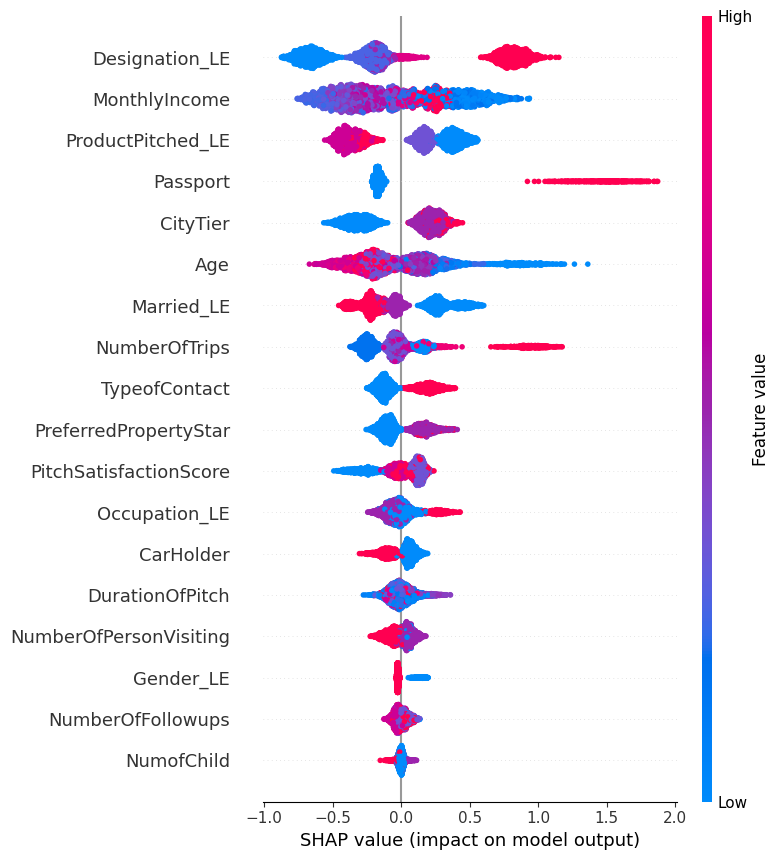

In [444]:
import shap
import lightgbm as lgb
import matplotlib.pyplot as plt

shap.initjs()
# 基本スコア
explainer = shap.TreeExplainer(model=models[0])

# 学習済みのモデル（例：lgb_model）
# 学習に使った特徴量データ（例：X_train）

# 横軸：SHAP値 (0からの貢献度、右=プラスの影響)
# 縦軸：特徴量 (上にあるほど重要)
# 色：その特徴の値 (赤=大きい値、青=小さい値)

# ① SHAPのexplainerを作成
explainer = shap.TreeExplainer(models[0])

# ② SHAP値を計算（X_trainは学習に使った特徴量データ）
shap_values = explainer.shap_values(train.drop("ProdTaken",axis=1))

# ③ summary plotで全体の重要度と分布を見る
shap.summary_plot(shap_values, train.drop("ProdTaken",axis=1))

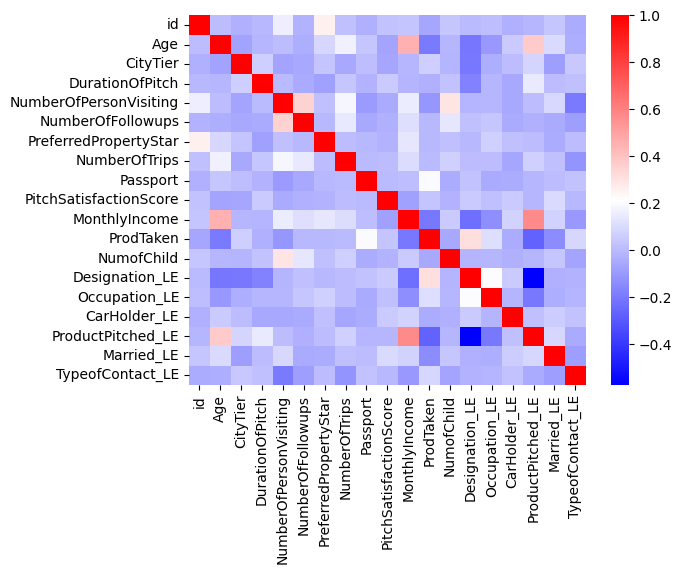

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

all_df_corr = all_df.corr()

# sns.heatmap(all_df_corr,annot=True,cmap="bwr")
sns.heatmap(all_df_corr,annot=False,cmap="bwr")
plt.show()

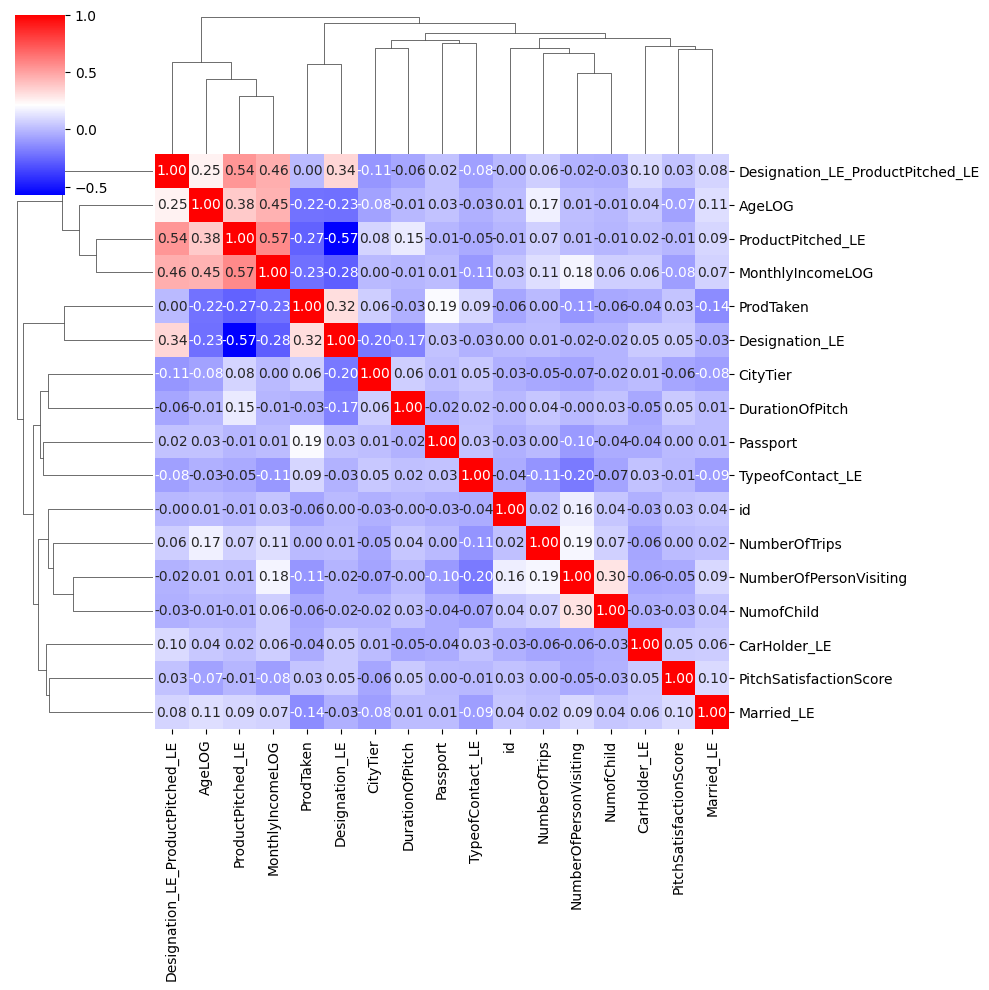

In [ ]:
all_df_corr = all_df.corr()
sns.clustermap(all_df_corr,annot=True,fmt=".2f",cmap="bwr")
plt.show()

In [ ]:
# Optunaを使用する
import optuna
import lightgbm as lgb
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
import lightgbm as lgb
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score

def objective(trial):

  lgbm_params = {
      'objective': 'binary',
      "device": "cpu",
      'metric': 'auc',
      # 'metric': 'rmse',
      'verbose': -1,              # ログ出力の制御
      'boosting_type': 'gbdt',
      'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回
      'num_leaves': trial.suggest_int('num_leaves', 2, 256), # 20回
      'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1),
      'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
      # 'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1), # 2回目
      'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0),
      'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0),
      'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 100),
      # 'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),
      # 'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
      # 'max_depth': trial.suggest_int('max_depth', 3, 12),
      }

  for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    # インデックスに割り振る

    x_train = train.loc[train_index, FEATURES].copy()
    y_train = train.loc[train_index, TARGET]
    x_valid = train.loc[test_index, FEATURES].copy()
    y_valid = train.loc[test_index, TARGET]
    # x_test = test[FEATURES].copy()

    # データセット作成
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

    # 学習
    model_lgb = lgb.train(lgbm_params,
                          lgb_train,
                          num_boost_round = 2000,
                          valid_sets = [lgb_train, lgb_eval],
                          valid_names = ["train", "valid"],
                          callbacks = [
                              lgb.early_stopping(stopping_rounds=100, verbose=False),
                              # lgb.record_evaluation(evaluations_result),
                              lgb.log_evaluation(100),])


    # y_pred = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)

    oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
    # models.append(model_lgb)
    # pred_lgb += model_lgb.predict(x_test, num_iteration = model_lgb.best_iteration)

  # pred_lgb = []
  # # 予測
  # for model in models:
  #   pred_lgb.append(model.predict(x_test, num_iteration = model.best_iteration))

  # pred_lgb = np.mean(np.expm1(pred_lgb), axis=0)

  # pred_lgb /= FOLDS
  # score = roc_auc_score(train[TARGET],oof_lgb)

  score = roc_auc_score(train[TARGET],oof_lgb)


  # mse = mean_squared_error(train[TARGET], oof_lgb)
  # rmse = np.sqrt(mse)  # MSEの平方根を取ってRMSEを計算


  return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2025-05-23 22:55:14,290] A new study created in memory with name: no-name-0c3dc397-40ea-4441-984f-74e39ab25c52
<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.858494	valid's auc: 0.824189
[200]	train's auc: 0.863499	valid's auc: 0.825053
#########################
### Fold 2
#########################
[100]	train's auc: 0.845671	valid's auc: 0.860733
[200]	train's auc: 0.851322	valid's auc: 0.860884
#########################
### Fold 3
#########################
[100]	train's auc: 0.865468	valid's auc: 0.806947
[200]	train's auc: 0.868444	valid's auc: 0.810494


[I 2025-05-23 22:55:15,007] Trial 0 finished with value: 0.8309307717965547 and parameters: {'feature_fraction': 0.47027857235761694, 'num_leaves': 118, 'bagging_fraction': 0.8216729149766329, 'bagging_freq': 2, 'lambda_l1': 8.866810416726697, 'lambda_l2': 7.928997700506864, 'min_data_in_leaf': 93}. Best is trial 0 with value: 0.8309307717965547.
<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.865239	valid's auc: 0.829718
#########################
### Fold 2
#########################
[100]	train's auc: 0.857475	valid's auc: 0.856944
#########################
### Fold 3
#########################
[100]	train's auc: 0.87106	valid's auc: 0.813761
[200]	train's auc: 0.885501	valid's auc: 0.813554
[300]	train's auc: 0.894223	valid's auc: 0.817241
[400]	train's auc: 0.901537	valid's auc: 0.817957


[I 2025-05-23 22:55:15,866] Trial 1 finished with value: 0.8313046729575313 and parameters: {'feature_fraction': 0.410278213052625, 'num_leaves': 89, 'bagging_fraction': 0.6272491775830772, 'bagging_freq': 7, 'lambda_l1': 2.951725302517644, 'lambda_l2': 9.490080323255047, 'min_data_in_leaf': 92}. Best is trial 1 with value: 0.8313046729575313.


[500]	train's auc: 0.908894	valid's auc: 0.817872
#########################
### Fold 1
#########################
[100]	train's auc: 0.853537	valid's auc: 0.826286


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[200]	train's auc: 0.86145	valid's auc: 0.826588
#########################
### Fold 2
#########################
[100]	train's auc: 0.842232	valid's auc: 0.858195
[200]	train's auc: 0.850602	valid's auc: 0.857754
#########################
### Fold 3
#########################
[100]	train's auc: 0.861082	valid's auc: 0.810749
[200]	train's auc: 0.871067	valid's auc: 0.813384
[300]	train's auc: 0.873156	valid's auc: 0.81503


[I 2025-05-23 22:55:25,333] Trial 2 finished with value: 0.8313053454416338 and parameters: {'feature_fraction': 0.5510503767528263, 'num_leaves': 153, 'bagging_fraction': 0.47306931717876366, 'bagging_freq': 7, 'lambda_l1': 6.3903910986056305, 'lambda_l2': 1.8919082342754652, 'min_data_in_leaf': 96}. Best is trial 2 with value: 0.8313053454416338.
<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.885107	valid's auc: 0.822208
[200]	train's auc: 0.898882	valid's auc: 0.822842
[300]	train's auc: 0.904462	valid's auc: 0.822298
#########################
### Fold 2
#########################
[100]	train's auc: 0.881059	valid's auc: 0.854721
#########################
### Fold 3
#########################


[I 2025-05-23 22:55:26,106] Trial 3 finished with value: 0.8274600813436772 and parameters: {'feature_fraction': 0.6302747632897231, 'num_leaves': 141, 'bagging_fraction': 0.9510923261468888, 'bagging_freq': 1, 'lambda_l1': 4.427073679976076, 'lambda_l2': 7.927854935410063, 'min_data_in_leaf': 69}. Best is trial 2 with value: 0.8313053454416338.


[100]	train's auc: 0.888566	valid's auc: 0.810743
[200]	train's auc: 0.902941	valid's auc: 0.811222


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.858058	valid's auc: 0.82396
[200]	train's auc: 0.866701	valid's auc: 0.823827
#########################
### Fold 2
#########################
[100]	train's auc: 0.847148	valid's auc: 0.85602
#########################
### Fold 3
#########################


[I 2025-05-23 22:55:26,714] Trial 4 finished with value: 0.8269775740001507 and parameters: {'feature_fraction': 0.9093131428472672, 'num_leaves': 68, 'bagging_fraction': 0.5835296405971037, 'bagging_freq': 6, 'lambda_l1': 8.062303126613227, 'lambda_l2': 6.722108090550263, 'min_data_in_leaf': 74}. Best is trial 2 with value: 0.8313053454416338.


[100]	train's auc: 0.863326	valid's auc: 0.80644
#########################
### Fold 1
#########################
[100]	train's auc: 0.849248	valid's auc: 0.821398


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[200]	train's auc: 0.854194	valid's auc: 0.824618
[300]	train's auc: 0.856671	valid's auc: 0.825857
#########################
### Fold 2
#########################
[100]	train's auc: 0.834558	valid's auc: 0.856379
[200]	train's auc: 0.841498	valid's auc: 0.859083
[300]	train's auc: 0.847607	valid's auc: 0.861204
[400]	train's auc: 0.849816	valid's auc: 0.861959
#########################
### Fold 3
#########################
[100]	train's auc: 0.856135	valid's auc: 0.807603


[I 2025-05-23 22:55:27,759] Trial 5 finished with value: 0.8318668696672011 and parameters: {'feature_fraction': 0.4892803565530008, 'num_leaves': 66, 'bagging_fraction': 0.47117590871181975, 'bagging_freq': 4, 'lambda_l1': 9.685672812181542, 'lambda_l2': 8.079852211254806, 'min_data_in_leaf': 38}. Best is trial 5 with value: 0.8318668696672011.


[200]	train's auc: 0.862258	valid's auc: 0.809577
[300]	train's auc: 0.8649	valid's auc: 0.812407
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.874341	valid's auc: 0.824776
[200]	train's auc: 0.877684	valid's auc: 0.826298
#########################
### Fold 2
#########################
[100]	train's auc: 0.867292	valid's auc: 0.858074
#########################
### Fold 3
#########################
[100]	train's auc: 0.877358	valid's auc: 0.81554


[I 2025-05-23 22:55:28,427] Trial 6 finished with value: 0.8298437012449026 and parameters: {'feature_fraction': 0.4290100582682084, 'num_leaves': 224, 'bagging_fraction': 0.9800176852871282, 'bagging_freq': 2, 'lambda_l1': 6.573475136355986, 'lambda_l2': 2.6873318065642566, 'min_data_in_leaf': 22}. Best is trial 5 with value: 0.8318668696672011.


[200]	train's auc: 0.882446	valid's auc: 0.816651
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.86314	valid's auc: 0.823241
[200]	train's auc: 0.864166	valid's auc: 0.823011
#########################
### Fold 2
#########################
[100]	train's auc: 0.854165	valid's auc: 0.858394
[200]	train's auc: 0.858759	valid's auc: 0.859754
#########################
### Fold 3
#########################
[100]	train's auc: 0.868472	valid's auc: 0.806887


[I 2025-05-23 22:55:29,272] Trial 7 finished with value: 0.8306483284735149 and parameters: {'feature_fraction': 0.6965812609701174, 'num_leaves': 124, 'bagging_fraction': 0.8352582702580358, 'bagging_freq': 3, 'lambda_l1': 9.9124539929173, 'lambda_l2': 6.332234345518537, 'min_data_in_leaf': 38}. Best is trial 5 with value: 0.8318668696672011.


[200]	train's auc: 0.87443	valid's auc: 0.811575
[300]	train's auc: 0.877127	valid's auc: 0.812437
[400]	train's auc: 0.877375	valid's auc: 0.812674
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.895998	valid's auc: 0.820123
#########################
### Fold 2
#########################
[100]	train's auc: 0.898629	valid's auc: 0.849591
#########################
### Fold 3
#########################
[100]	train's auc: 0.900734	valid's auc: 0.807974


[I 2025-05-23 22:55:30,174] Trial 8 finished with value: 0.8256497541398122 and parameters: {'feature_fraction': 0.9645785932858161, 'num_leaves': 84, 'bagging_fraction': 0.6173500565284545, 'bagging_freq': 7, 'lambda_l1': 1.506220304483326, 'lambda_l2': 9.113061066317186, 'min_data_in_leaf': 51}. Best is trial 5 with value: 0.8318668696672011.


[200]	train's auc: 0.932008	valid's auc: 0.805963
#########################
### Fold 1
#########################
[100]	train's auc: 0.861717	valid's auc: 0.822754
#########################
### Fold 2
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.852933	valid's auc: 0.85454
[200]	train's auc: 0.85765	valid's auc: 0.855506
#########################
### Fold 3
#########################
[100]	train's auc: 0.870959	valid's auc: 0.809352


[I 2025-05-23 22:55:30,710] Trial 9 finished with value: 0.8282499139220348 and parameters: {'feature_fraction': 0.9168982346633602, 'num_leaves': 183, 'bagging_fraction': 0.7656830827002284, 'bagging_freq': 3, 'lambda_l1': 9.73856898588278, 'lambda_l2': 1.0441804594684845, 'min_data_in_leaf': 69}. Best is trial 5 with value: 0.8318668696672011.


[200]	train's auc: 0.871397	valid's auc: 0.809832
#########################
### Fold 1
#########################
[100]	train's auc: 0.853385	valid's auc: 0.823422


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[200]	train's auc: 0.865829	valid's auc: 0.824117
#########################
### Fold 2
#########################
[100]	train's auc: 0.842815	valid's auc: 0.858213
#########################
### Fold 3
#########################
[100]	train's auc: 0.863705	valid's auc: 0.809036
[200]	train's auc: 0.873115	valid's auc: 0.811441


[I 2025-05-23 22:55:31,366] Trial 10 finished with value: 0.8291977802644745 and parameters: {'feature_fraction': 0.7958046397680866, 'num_leaves': 4, 'bagging_fraction': 0.4191277569707914, 'bagging_freq': 5, 'lambda_l1': 5.13353170614043, 'lambda_l2': 4.236487488493048, 'min_data_in_leaf': 13}. Best is trial 5 with value: 0.8318668696672011.
<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.859271	valid's auc: 0.821271
[200]	train's auc: 0.869682	valid's auc: 0.823392
[300]	train's auc: 0.873088	valid's auc: 0.823773
#########################
### Fold 2
#########################
[100]	train's auc: 0.848644	valid's auc: 0.856026


[I 2025-05-23 22:55:32,096] Trial 11 finished with value: 0.8278763490031096 and parameters: {'feature_fraction': 0.5504722025206561, 'num_leaves': 32, 'bagging_fraction': 0.40922172155738934, 'bagging_freq': 5, 'lambda_l1': 6.772840095359229, 'lambda_l2': 0.14726236072274634, 'min_data_in_leaf': 35}. Best is trial 5 with value: 0.8318668696672011.


#########################
### Fold 3
#########################
[100]	train's auc: 0.864257	valid's auc: 0.812413
[200]	train's auc: 0.86924	valid's auc: 0.814994


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.859988	valid's auc: 0.821416
[200]	train's auc: 0.867639	valid's auc: 0.823011
#########################
### Fold 2
#########################
[100]	train's auc: 0.846468	valid's auc: 0.856213
[200]	train's auc: 0.860985	valid's auc: 0.855494
#########################
### Fold 3
#########################
[100]	train's auc: 0.868453	valid's auc: 0.815315
[200]	train's auc: 0.874616	valid's auc: 0.817975


[I 2025-05-23 22:55:32,837] Trial 12 finished with value: 0.831533317552373 and parameters: {'feature_fraction': 0.560754625122817, 'num_leaves': 173, 'bagging_fraction': 0.5142473093049356, 'bagging_freq': 4, 'lambda_l1': 6.860781006199174, 'lambda_l2': 3.6860209221079776, 'min_data_in_leaf': 48}. Best is trial 5 with value: 0.8318668696672011.


[300]	train's auc: 0.875069	valid's auc: 0.818413
#########################
### Fold 1
#########################
[100]	train's auc: 0.857156	valid's auc: 0.81996


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[200]	train's auc: 0.865925	valid's auc: 0.822449
#########################
### Fold 2
#########################
[100]	train's auc: 0.844584	valid's auc: 0.85631
[200]	train's auc: 0.855385	valid's auc: 0.857609
#########################
### Fold 3
#########################
[100]	train's auc: 0.865795	valid's auc: 0.81005
[200]	train's auc: 0.870761	valid's auc: 0.811326


[I 2025-05-23 22:55:33,670] Trial 13 finished with value: 0.8296093405351898 and parameters: {'feature_fraction': 0.5724944578342401, 'num_leaves': 246, 'bagging_fraction': 0.5218127994007979, 'bagging_freq': 4, 'lambda_l1': 7.868529097881106, 'lambda_l2': 4.150893742469795, 'min_data_in_leaf': 51}. Best is trial 5 with value: 0.8318668696672011.


[300]	train's auc: 0.874331	valid's auc: 0.813676
[400]	train's auc: 0.876633	valid's auc: 0.814726
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.868201	valid's auc: 0.819942
[200]	train's auc: 0.882283	valid's auc: 0.819344
#########################
### Fold 2
#########################
[100]	train's auc: 0.859947	valid's auc: 0.857234
#########################
### Fold 3
#########################
[100]	train's auc: 0.878122	valid's auc: 0.815006
[200]	train's auc: 0.888356	valid's auc: 0.817241
[300]	train's auc: 0.896453	valid's auc: 0.820672


[I 2025-05-23 22:55:34,725] Trial 14 finished with value: 0.8295205726336629 and parameters: {'feature_fraction': 0.5094008998133707, 'num_leaves': 188, 'bagging_fraction': 0.5209395684958936, 'bagging_freq': 4, 'lambda_l1': 4.848775647049762, 'lambda_l2': 5.49351569037482, 'min_data_in_leaf': 36}. Best is trial 5 with value: 0.8318668696672011.


[400]	train's auc: 0.904	valid's auc: 0.82174
[500]	train's auc: 0.910096	valid's auc: 0.822166
[600]	train's auc: 0.913889	valid's auc: 0.820775


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.969015	valid's auc: 0.813132
#########################
### Fold 2
#########################
[100]	train's auc: 0.969795	valid's auc: 0.834721
#########################
### Fold 3
#########################


[I 2025-05-23 22:55:38,328] Trial 15 finished with value: 0.8198246968441666 and parameters: {'feature_fraction': 0.6738820513306144, 'num_leaves': 44, 'bagging_fraction': 0.6852346546750625, 'bagging_freq': 5, 'lambda_l1': 0.38005314419521774, 'lambda_l2': 3.04892722035004, 'min_data_in_leaf': 24}. Best is trial 5 with value: 0.8318668696672011.


[100]	train's auc: 0.966275	valid's auc: 0.803662
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.856397	valid's auc: 0.824038
[200]	train's auc: 0.862754	valid's auc: 0.826208
[300]	train's auc: 0.865987	valid's auc: 0.827621
#########################
### Fold 2
#########################
[100]	train's auc: 0.844015	valid's auc: 0.859301
#########################
### Fold 3
#########################
[100]	train's auc: 0.864419	valid's auc: 0.807111
[200]	train's auc: 0.869997	valid's auc: 0.810901
[300]	train's auc: 0.874683	valid's auc: 0.812036


[I 2025-05-23 22:55:39,264] Trial 16 finished with value: 0.8290518512142374 and parameters: {'feature_fraction': 0.621928106600609, 'num_leaves': 172, 'bagging_fraction': 0.5227886700034061, 'bagging_freq': 3, 'lambda_l1': 8.066623418175256, 'lambda_l2': 4.660865807815339, 'min_data_in_leaf': 58}. Best is trial 5 with value: 0.8318668696672011.


[400]	train's auc: 0.878515	valid's auc: 0.813087
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.91168	valid's auc: 0.820727
#########################
### Fold 2
#########################
[100]	train's auc: 0.90824	valid's auc: 0.853101
[200]	train's auc: 0.934201	valid's auc: 0.847996
#########################
### Fold 3
#########################


[I 2025-05-23 22:55:40,131] Trial 17 finished with value: 0.8292791508408741 and parameters: {'feature_fraction': 0.7867546006558469, 'num_leaves': 209, 'bagging_fraction': 0.7029302211145672, 'bagging_freq': 4, 'lambda_l1': 3.766837549505833, 'lambda_l2': 7.621459971788497, 'min_data_in_leaf': 5}. Best is trial 5 with value: 0.8318668696672011.


[100]	train's auc: 0.91156	valid's auc: 0.808095
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.858165	valid's auc: 0.823948
[200]	train's auc: 0.866032	valid's auc: 0.826389
#########################
### Fold 2
#########################
[100]	train's auc: 0.849117	valid's auc: 0.856358
[200]	train's auc: 0.858672	valid's auc: 0.85657
#########################
### Fold 3
#########################
[100]	train's auc: 0.8623	valid's auc: 0.814818


[I 2025-05-23 22:55:40,874] Trial 18 finished with value: 0.8331028954475516 and parameters: {'feature_fraction': 0.480504729283548, 'num_leaves': 101, 'bagging_fraction': 0.45305578659905, 'bagging_freq': 6, 'lambda_l1': 5.823355384805122, 'lambda_l2': 5.726410326017227, 'min_data_in_leaf': 44}. Best is trial 18 with value: 0.8331028954475516.


[200]	train's auc: 0.872284	valid's auc: 0.817599
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.88088	valid's auc: 0.820757
[200]	train's auc: 0.900139	valid's auc: 0.821797
#########################
### Fold 2
#########################
[100]	train's auc: 0.879101	valid's auc: 0.85347
[200]	train's auc: 0.899624	valid's auc: 0.848981
#########################
### Fold 3
#########################


[I 2025-05-23 22:55:41,724] Trial 19 finished with value: 0.8326846103358116 and parameters: {'feature_fraction': 0.47594707993703206, 'num_leaves': 113, 'bagging_fraction': 0.46829070707831877, 'bagging_freq': 6, 'lambda_l1': 2.6772246776279713, 'lambda_l2': 5.698582875568366, 'min_data_in_leaf': 25}. Best is trial 18 with value: 0.8331028954475516.


[100]	train's auc: 0.884481	valid's auc: 0.818212
[200]	train's auc: 0.908072	valid's auc: 0.820155
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.911687	valid's auc: 0.825724
#########################
### Fold 2
#########################
[100]	train's auc: 0.914539	valid's auc: 0.843833
#########################
### Fold 3
#########################
[100]	train's auc: 0.915969	valid's auc: 0.810852


[I 2025-05-23 22:55:42,460] Trial 20 finished with value: 0.8269194041252864 and parameters: {'feature_fraction': 0.7947331435478799, 'num_leaves': 106, 'bagging_fraction': 0.5848106266228199, 'bagging_freq': 6, 'lambda_l1': 2.1781604113664352, 'lambda_l2': 6.105899347013368, 'min_data_in_leaf': 18}. Best is trial 18 with value: 0.8331028954475516.


[200]	train's auc: 0.948957	valid's auc: 0.81104
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.89842	valid's auc: 0.820909
#########################
### Fold 2
#########################
[100]	train's auc: 0.898144	valid's auc: 0.851621
#########################
### Fold 3
#########################
[100]	train's auc: 0.901421	valid's auc: 0.820095


[I 2025-05-23 22:55:43,149] Trial 21 finished with value: 0.8292791508408741 and parameters: {'feature_fraction': 0.4685466067319679, 'num_leaves': 53, 'bagging_fraction': 0.4513908947165414, 'bagging_freq': 6, 'lambda_l1': 0.4500366195172689, 'lambda_l2': 7.108113522488885, 'min_data_in_leaf': 30}. Best is trial 18 with value: 0.8331028954475516.


[200]	train's auc: 0.933144	valid's auc: 0.815486
#########################
### Fold 1
#########################
[100]	train's auc: 0.860276	valid's auc: 0.821887


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[200]	train's auc: 0.869644	valid's auc: 0.82602
[300]	train's auc: 0.87628	valid's auc: 0.823519
#########################
### Fold 2
#########################
[100]	train's auc: 0.851187	valid's auc: 0.852685
[200]	train's auc: 0.862376	valid's auc: 0.852268
[300]	train's auc: 0.869429	valid's auc: 0.856098
[400]	train's auc: 0.877741	valid's auc: 0.855023
#########################
### Fold 3
#########################


[I 2025-05-23 22:55:44,106] Trial 22 finished with value: 0.8320847545164032 and parameters: {'feature_fraction': 0.4816345606091615, 'num_leaves': 79, 'bagging_fraction': 0.48482853516798996, 'bagging_freq': 6, 'lambda_l1': 5.724283307803062, 'lambda_l2': 5.3276873481663785, 'min_data_in_leaf': 42}. Best is trial 18 with value: 0.8331028954475516.


[100]	train's auc: 0.866867	valid's auc: 0.815868
[200]	train's auc: 0.878172	valid's auc: 0.817957


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.855435	valid's auc: 0.823416
[200]	train's auc: 0.8646	valid's auc: 0.826008
[300]	train's auc: 0.870596	valid's auc: 0.825827
#########################
### Fold 2
#########################
[100]	train's auc: 0.842607	valid's auc: 0.856968
[200]	train's auc: 0.852931	valid's auc: 0.856219
#########################
### Fold 3
#########################
[100]	train's auc: 0.861542	valid's auc: 0.815224
[200]	train's auc: 0.87081	valid's auc: 0.815449
[300]	train's auc: 0.875654	valid's auc: 0.817599
[400]	train's auc: 0.881702	valid's auc: 0.820283
[500]	train's auc: 0.884932	valid's auc: 0.822894


[I 2025-05-23 22:55:45,180] Trial 23 finished with value: 0.8325413712219843 and parameters: {'feature_fraction': 0.4168644088111567, 'num_leaves': 98, 'bagging_fraction': 0.4048968054235994, 'bagging_freq': 6, 'lambda_l1': 5.620280807541148, 'lambda_l2': 5.271011253351733, 'min_data_in_leaf': 44}. Best is trial 18 with value: 0.8331028954475516.


[600]	train's auc: 0.88789	valid's auc: 0.824054
#########################
### Fold 1
#########################
[100]	train's auc: 0.860985	valid's auc: 0.823615


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[200]	train's auc: 0.872271	valid's auc: 0.826105
[300]	train's auc: 0.879861	valid's auc: 0.828461
[400]	train's auc: 0.885324	valid's auc: 0.826927
#########################
### Fold 2
#########################
[100]	train's auc: 0.848994	valid's auc: 0.857252
[200]	train's auc: 0.863164	valid's auc: 0.852999
#########################
### Fold 3
#########################
[100]	train's auc: 0.867216	valid's auc: 0.817058


[I 2025-05-23 22:55:46,095] Trial 24 finished with value: 0.8341062417284455 and parameters: {'feature_fraction': 0.41007277941849635, 'num_leaves': 143, 'bagging_fraction': 0.4056068234981311, 'bagging_freq': 6, 'lambda_l1': 3.5255646301896215, 'lambda_l2': 5.06243069102702, 'min_data_in_leaf': 63}. Best is trial 24 with value: 0.8341062417284455.


[200]	train's auc: 0.88122	valid's auc: 0.820107
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.867971	valid's auc: 0.823126
[200]	train's auc: 0.882349	valid's auc: 0.824359
#########################
### Fold 2
#########################
[100]	train's auc: 0.86254	valid's auc: 0.859627
[200]	train's auc: 0.879988	valid's auc: 0.858751
#########################
### Fold 3
#########################
[100]	train's auc: 0.871817	valid's auc: 0.81333
[200]	train's auc: 0.887112	valid's auc: 0.819512
[300]	train's auc: 0.895675	valid's auc: 0.821048


[I 2025-05-23 22:55:47,128] Trial 25 finished with value: 0.8327666533963137 and parameters: {'feature_fraction': 0.40506845124344865, 'num_leaves': 154, 'bagging_fraction': 0.5713778164208194, 'bagging_freq': 5, 'lambda_l1': 3.6953128541438076, 'lambda_l2': 5.973331169928623, 'min_data_in_leaf': 60}. Best is trial 24 with value: 0.8341062417284455.


[400]	train's auc: 0.903154	valid's auc: 0.821419
[500]	train's auc: 0.909539	valid's auc: 0.820544
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.870109	valid's auc: 0.824177
#########################
### Fold 2
#########################
[100]	train's auc: 0.864319	valid's auc: 0.858038
#########################
### Fold 3
#########################
[100]	train's auc: 0.875323	valid's auc: 0.817131
[200]	train's auc: 0.889825	valid's auc: 0.820605


[I 2025-05-23 22:55:47,802] Trial 26 finished with value: 0.8312834897083032 and parameters: {'feature_fraction': 0.4291979769458116, 'num_leaves': 140, 'bagging_fraction': 0.5553898682136359, 'bagging_freq': 5, 'lambda_l1': 3.7266761751137976, 'lambda_l2': 3.2314886228587274, 'min_data_in_leaf': 59}. Best is trial 24 with value: 0.8341062417284455.
<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.870967	valid's auc: 0.826492
[200]	train's auc: 0.8871	valid's auc: 0.827718
#########################
### Fold 2
#########################
[100]	train's auc: 0.867233	valid's auc: 0.855579
#########################
### Fold 3
#########################
[100]	train's auc: 0.875133	valid's auc: 0.810354
[200]	train's auc: 0.891861	valid's auc: 0.817058
[300]	train's auc: 0.899356	valid's auc: 0.819481


[I 2025-05-23 22:55:51,443] Trial 27 finished with value: 0.8286164177578842 and parameters: {'feature_fraction': 0.5211951803231629, 'num_leaves': 160, 'bagging_fraction': 0.6325412930520735, 'bagging_freq': 5, 'lambda_l1': 4.021064979952011, 'lambda_l2': 4.85317478493218, 'min_data_in_leaf': 76}. Best is trial 24 with value: 0.8341062417284455.
<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.862164	valid's auc: 0.82744
[200]	train's auc: 0.875433	valid's auc: 0.829053
#########################
### Fold 2
#########################
[100]	train's auc: 0.852053	valid's auc: 0.860135
#########################
### Fold 3
#########################


[I 2025-05-23 22:55:52,196] Trial 28 finished with value: 0.835053771828834 and parameters: {'feature_fraction': 0.40338538741469376, 'num_leaves': 133, 'bagging_fraction': 0.44650127139645795, 'bagging_freq': 7, 'lambda_l1': 3.107900276611632, 'lambda_l2': 7.001696815025252, 'min_data_in_leaf': 63}. Best is trial 28 with value: 0.835053771828834.


[100]	train's auc: 0.868938	valid's auc: 0.813852
[200]	train's auc: 0.883852	valid's auc: 0.819828
[300]	train's auc: 0.890358	valid's auc: 0.819184


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.862278	valid's auc: 0.827948
[200]	train's auc: 0.876159	valid's auc: 0.829162
#########################
### Fold 2
#########################
[100]	train's auc: 0.853312	valid's auc: 0.858751
#########################
### Fold 3
#########################


[I 2025-05-23 22:55:52,879] Trial 29 finished with value: 0.8362803828317499 and parameters: {'feature_fraction': 0.45705463013508557, 'num_leaves': 120, 'bagging_fraction': 0.44209794224057836, 'bagging_freq': 7, 'lambda_l1': 2.2276613705975654, 'lambda_l2': 8.584681328939595, 'min_data_in_leaf': 86}. Best is trial 29 with value: 0.8362803828317499.


[100]	train's auc: 0.867662	valid's auc: 0.817125
[200]	train's auc: 0.882991	valid's auc: 0.821212
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.898249	valid's auc: 0.82144
#########################
### Fold 2
#########################
[100]	train's auc: 0.899151	valid's auc: 0.848473
#########################
### Fold 3
#########################
[100]	train's auc: 0.901273	valid's auc: 0.811374


[I 2025-05-23 22:55:53,530] Trial 30 finished with value: 0.8263185395797243 and parameters: {'feature_fraction': 0.6144999835106199, 'num_leaves': 131, 'bagging_fraction': 0.8550090265852675, 'bagging_freq': 7, 'lambda_l1': 1.2345480560392652, 'lambda_l2': 8.82085336081849, 'min_data_in_leaf': 85}. Best is trial 29 with value: 0.8362803828317499.
<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.860926	valid's auc: 0.825893
[200]	train's auc: 0.874499	valid's auc: 0.82489
#########################
### Fold 2
#########################
[100]	train's auc: 0.854665	valid's auc: 0.858141
#########################
### Fold 3
#########################
[100]	train's auc: 0.868263	valid's auc: 0.812959
[200]	train's auc: 0.883264	valid's auc: 0.818121
[300]	train's auc: 0.890075	valid's auc: 0.817058


[I 2025-05-23 22:55:54,294] Trial 31 finished with value: 0.8339757798125652 and parameters: {'feature_fraction': 0.45807170882012804, 'num_leaves': 121, 'bagging_fraction': 0.43797109164769804, 'bagging_freq': 7, 'lambda_l1': 2.885642414366064, 'lambda_l2': 9.873485332832669, 'min_data_in_leaf': 65}. Best is trial 29 with value: 0.8362803828317499.
<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.859164	valid's auc: 0.827331
[200]	train's auc: 0.871251	valid's auc: 0.827059
#########################
### Fold 2
#########################
[100]	train's auc: 0.847422	valid's auc: 0.860086
#########################
### Fold 3
#########################
[100]	train's auc: 0.864222	valid's auc: 0.813676


[I 2025-05-23 22:55:54,999] Trial 32 finished with value: 0.8339804872012826 and parameters: {'feature_fraction': 0.44582558315157866, 'num_leaves': 122, 'bagging_fraction': 0.4340505173304712, 'bagging_freq': 7, 'lambda_l1': 2.944548989232467, 'lambda_l2': 9.955465153341418, 'min_data_in_leaf': 86}. Best is trial 29 with value: 0.8362803828317499.


[200]	train's auc: 0.877391	valid's auc: 0.816445
[300]	train's auc: 0.884095	valid's auc: 0.814398
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.859068	valid's auc: 0.825718
[200]	train's auc: 0.872561	valid's auc: 0.826425
#########################
### Fold 2
#########################
[100]	train's auc: 0.849913	valid's auc: 0.857192
#########################
### Fold 3
#########################
[100]	train's auc: 0.864719	valid's auc: 0.812067


[I 2025-05-23 22:55:55,721] Trial 33 finished with value: 0.8326045847276169 and parameters: {'feature_fraction': 0.4401511558111197, 'num_leaves': 137, 'bagging_fraction': 0.4015148240802163, 'bagging_freq': 7, 'lambda_l1': 2.066912586787067, 'lambda_l2': 8.486712136268586, 'min_data_in_leaf': 86}. Best is trial 29 with value: 0.8362803828317499.


[200]	train's auc: 0.880603	valid's auc: 0.818413
[300]	train's auc: 0.888385	valid's auc: 0.816208
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.855725	valid's auc: 0.827464
[200]	train's auc: 0.868355	valid's auc: 0.828951
#########################
### Fold 2
#########################
[100]	train's auc: 0.844352	valid's auc: 0.858092
#########################
### Fold 3
#########################
[100]	train's auc: 0.861965	valid's auc: 0.81271


[I 2025-05-23 22:55:56,476] Trial 34 finished with value: 0.8336946814577303 and parameters: {'feature_fraction': 0.40387285898556513, 'num_leaves': 151, 'bagging_fraction': 0.4405327673714225, 'bagging_freq': 7, 'lambda_l1': 2.969675893290621, 'lambda_l2': 9.517113295078829, 'min_data_in_leaf': 98}. Best is trial 29 with value: 0.8362803828317499.


[200]	train's auc: 0.874719	valid's auc: 0.817417
[300]	train's auc: 0.880001	valid's auc: 0.817319
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.873352	valid's auc: 0.828298
#########################
### Fold 2
#########################
[100]	train's auc: 0.871413	valid's auc: 0.856902
[200]	train's auc: 0.894661	valid's auc: 0.851512
#########################
### Fold 3
#########################
[100]	train's auc: 0.876598	valid's auc: 0.811781


[I 2025-05-23 22:55:57,290] Trial 35 finished with value: 0.8311795909144709 and parameters: {'feature_fraction': 0.5209599100156009, 'num_leaves': 121, 'bagging_fraction': 0.4956808695202633, 'bagging_freq': 7, 'lambda_l1': 1.1519049856023644, 'lambda_l2': 7.091817864285634, 'min_data_in_leaf': 82}. Best is trial 29 with value: 0.8362803828317499.


[200]	train's auc: 0.899028	valid's auc: 0.812394
[300]	train's auc: 0.911797	valid's auc: 0.813973
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.858444	valid's auc: 0.828346
[200]	train's auc: 0.871264	valid's auc: 0.828226
#########################
### Fold 2
#########################
[100]	train's auc: 0.851701	valid's auc: 0.857742
[200]	train's auc: 0.867721	valid's auc: 0.857355
#########################
### Fold 3
#########################


[I 2025-05-23 22:55:58,056] Trial 36 finished with value: 0.8345823604729984 and parameters: {'feature_fraction': 0.4485368497757733, 'num_leaves': 97, 'bagging_fraction': 0.4876706876060213, 'bagging_freq': 7, 'lambda_l1': 3.2756964964826585, 'lambda_l2': 8.379725664753842, 'min_data_in_leaf': 93}. Best is trial 29 with value: 0.8362803828317499.


[100]	train's auc: 0.867174	valid's auc: 0.812334
[200]	train's auc: 0.881078	valid's auc: 0.816336
[300]	train's auc: 0.886442	valid's auc: 0.817344


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.87491	valid's auc: 0.829132
[200]	train's auc: 0.894258	valid's auc: 0.833501
#########################
### Fold 2
#########################
[100]	train's auc: 0.871778	valid's auc: 0.858872
#########################
### Fold 3
#########################


[I 2025-05-23 22:55:58,790] Trial 37 finished with value: 0.8319280657205264 and parameters: {'feature_fraction': 0.7474553515212106, 'num_leaves': 97, 'bagging_fraction': 0.5499376386865119, 'bagging_freq': 7, 'lambda_l1': 1.9972109050778049, 'lambda_l2': 7.611108680267458, 'min_data_in_leaf': 91}. Best is trial 29 with value: 0.8362803828317499.


[100]	train's auc: 0.878228	valid's auc: 0.81138
[200]	train's auc: 0.898249	valid's auc: 0.812467
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.860499	valid's auc: 0.826685
[200]	train's auc: 0.871622	valid's auc: 0.826232
#########################
### Fold 2
#########################
[100]	train's auc: 0.852592	valid's auc: 0.853929
#########################
### Fold 3
#########################
[100]	train's auc: 0.866243	valid's auc: 0.81067
[200]	train's auc: 0.881669	valid's auc: 0.814629
[300]	train's auc: 0.886296	valid's auc: 0.814441


[I 2025-05-23 22:55:59,648] Trial 38 finished with value: 0.8307888776509323 and parameters: {'feature_fraction': 0.5788894628507594, 'num_leaves': 73, 'bagging_fraction': 0.49449430086862506, 'bagging_freq': 6, 'lambda_l1': 4.517764261285002, 'lambda_l2': 8.051825094465409, 'min_data_in_leaf': 78}. Best is trial 29 with value: 0.8362803828317499.


[400]	train's auc: 0.891846	valid's auc: 0.817162
#########################
### Fold 1
#########################
[100]	train's auc: 0.883164	valid's auc: 0.822733


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[200]	train's auc: 0.902833	valid's auc: 0.822963
#########################
### Fold 2
#########################
[100]	train's auc: 0.881856	valid's auc: 0.854201
#########################
### Fold 3
#########################
[100]	train's auc: 0.888719	valid's auc: 0.812237
[200]	train's auc: 0.907196	valid's auc: 0.813129
[300]	train's auc: 0.91595	valid's auc: 0.812686


[I 2025-05-23 22:56:00,499] Trial 39 finished with value: 0.8282583199733159 and parameters: {'feature_fraction': 0.5215861884434758, 'num_leaves': 194, 'bagging_fraction': 0.9004873355270997, 'bagging_freq': 1, 'lambda_l1': 3.367474242579695, 'lambda_l2': 6.634637913820147, 'min_data_in_leaf': 91}. Best is trial 29 with value: 0.8362803828317499.
<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.863228	valid's auc: 0.824812
#########################
### Fold 2
#########################
[100]	train's auc: 0.85589	valid's auc: 0.857011
#########################
### Fold 3
#########################
[100]	train's auc: 0.869619	valid's auc: 0.811781
[200]	train's auc: 0.882603	valid's auc: 0.812085
[300]	train's auc: 0.888352	valid's auc: 0.814805


[I 2025-05-23 22:56:04,206] Trial 40 finished with value: 0.8282320930933194 and parameters: {'feature_fraction': 0.4003313544769424, 'num_leaves': 167, 'bagging_fraction': 0.6225062402628808, 'bagging_freq': 7, 'lambda_l1': 4.365994640054209, 'lambda_l2': 8.547581136252862, 'min_data_in_leaf': 70}. Best is trial 29 with value: 0.8362803828317499.


[400]	train's auc: 0.894328	valid's auc: 0.8167
[500]	train's auc: 0.900315	valid's auc: 0.816718


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.859641	valid's auc: 0.828679
[200]	train's auc: 0.872471	valid's auc: 0.829537
#########################
### Fold 2
#########################
[100]	train's auc: 0.848132	valid's auc: 0.85947
#########################
### Fold 3
#########################


[I 2025-05-23 22:56:04,936] Trial 41 finished with value: 0.8350820161611381 and parameters: {'feature_fraction': 0.448128954307543, 'num_leaves': 146, 'bagging_fraction': 0.4346965534851677, 'bagging_freq': 7, 'lambda_l1': 2.40422586810867, 'lambda_l2': 9.228947765826637, 'min_data_in_leaf': 95}. Best is trial 29 with value: 0.8362803828317499.


[100]	train's auc: 0.863455	valid's auc: 0.813062
[200]	train's auc: 0.878359	valid's auc: 0.817532
[300]	train's auc: 0.885152	valid's auc: 0.818619


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.859458	valid's auc: 0.826945
[200]	train's auc: 0.87361	valid's auc: 0.825682
#########################
### Fold 2
#########################
[100]	train's auc: 0.8515	valid's auc: 0.857228
#########################
### Fold 3
#########################
[100]	train's auc: 0.865849	valid's auc: 0.814022
[200]	train's auc: 0.881719	valid's auc: 0.817453


[I 2025-05-23 22:56:06,210] Trial 42 finished with value: 0.8337168734331121 and parameters: {'feature_fraction': 0.4520968864010434, 'num_leaves': 146, 'bagging_fraction': 0.46485267363921895, 'bagging_freq': 7, 'lambda_l1': 2.3860259531352312, 'lambda_l2': 9.199702693676125, 'min_data_in_leaf': 99}. Best is trial 29 with value: 0.8362803828317499.


[300]	train's auc: 0.887661	valid's auc: 0.818358
#########################
### Fold 1
#########################
[100]	train's auc: 0.866777	valid's auc: 0.829229


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[200]	train's auc: 0.881845	valid's auc: 0.829954
#########################
### Fold 2
#########################
[100]	train's auc: 0.859864	valid's auc: 0.855234
[200]	train's auc: 0.881532	valid's auc: 0.849627
#########################
### Fold 3
#########################
[100]	train's auc: 0.872586	valid's auc: 0.812334


[I 2025-05-23 22:56:07,490] Trial 43 finished with value: 0.8350604966698588 and parameters: {'feature_fraction': 0.5027744898191268, 'num_leaves': 90, 'bagging_fraction': 0.43323788636740274, 'bagging_freq': 6, 'lambda_l1': 1.664542261222835, 'lambda_l2': 8.273910414490384, 'min_data_in_leaf': 80}. Best is trial 29 with value: 0.8362803828317499.


[200]	train's auc: 0.891547	valid's auc: 0.814951
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.868416	valid's auc: 0.829452
#########################
### Fold 2
#########################
[100]	train's auc: 0.862574	valid's auc: 0.857089
[200]	train's auc: 0.881109	valid's auc: 0.854926
#########################
### Fold 3
#########################
[100]	train's auc: 0.871818	valid's auc: 0.812613
[200]	train's auc: 0.891465	valid's auc: 0.814101


[I 2025-05-23 22:56:08,246] Trial 44 finished with value: 0.83210560152358 and parameters: {'feature_fraction': 0.5079331928964885, 'num_leaves': 83, 'bagging_fraction': 0.49337618472750117, 'bagging_freq': 7, 'lambda_l1': 1.5603443639290622, 'lambda_l2': 8.33838772665331, 'min_data_in_leaf': 94}. Best is trial 29 with value: 0.8362803828317499.


[300]	train's auc: 0.901192	valid's auc: 0.818048
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.867441	valid's auc: 0.823156
#########################
### Fold 2
#########################
[100]	train's auc: 0.859628	valid's auc: 0.858249
#########################
### Fold 3
#########################
[100]	train's auc: 0.872779	valid's auc: 0.813311
[200]	train's auc: 0.892553	valid's auc: 0.816633


[I 2025-05-23 22:56:08,890] Trial 45 finished with value: 0.8319516026641129 and parameters: {'feature_fraction': 0.5434717417334411, 'num_leaves': 111, 'bagging_fraction': 0.42523446687170025, 'bagging_freq': 7, 'lambda_l1': 0.8517065324429067, 'lambda_l2': 8.995570642065063, 'min_data_in_leaf': 82}. Best is trial 29 with value: 0.8362803828317499.
<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.872329	valid's auc: 0.827779
[200]	train's auc: 0.889234	valid's auc: 0.829519
#########################
### Fold 2
#########################
[100]	train's auc: 0.866047	valid's auc: 0.85376
#########################
### Fold 3
#########################


[I 2025-05-23 22:56:09,500] Trial 46 finished with value: 0.8320571826682016 and parameters: {'feature_fraction': 0.49952982897790066, 'num_leaves': 55, 'bagging_fraction': 0.5396508206922758, 'bagging_freq': 6, 'lambda_l1': 1.8320020414497762, 'lambda_l2': 7.485793827927812, 'min_data_in_leaf': 90}. Best is trial 29 with value: 0.8362803828317499.


[100]	train's auc: 0.874183	valid's auc: 0.820411
[200]	train's auc: 0.894722	valid's auc: 0.819342
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.887794	valid's auc: 0.821319
[200]	train's auc: 0.911784	valid's auc: 0.822147
#########################
### Fold 2
#########################
[100]	train's auc: 0.889344	valid's auc: 0.851657
#########################
### Fold 3
#########################
[100]	train's auc: 0.890885	valid's auc: 0.813123


[I 2025-05-23 22:56:10,236] Trial 47 finished with value: 0.828450650426624 and parameters: {'feature_fraction': 0.5847271988101193, 'num_leaves': 86, 'bagging_fraction': 0.7694491956846389, 'bagging_freq': 7, 'lambda_l1': 2.4795290602565263, 'lambda_l2': 8.059581967125169, 'min_data_in_leaf': 72}. Best is trial 29 with value: 0.8362803828317499.


[200]	train's auc: 0.914713	valid's auc: 0.813506
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.872679	valid's auc: 0.825174
[200]	train's auc: 0.893466	valid's auc: 0.826655
#########################
### Fold 2
#########################
[100]	train's auc: 0.870548	valid's auc: 0.853089
#########################
### Fold 3
#########################
[100]	train's auc: 0.88114	valid's auc: 0.817593


[I 2025-05-23 22:56:10,954] Trial 48 finished with value: 0.83265972842402 and parameters: {'feature_fraction': 0.4371791180376162, 'num_leaves': 132, 'bagging_fraction': 0.46962242049984615, 'bagging_freq': 6, 'lambda_l1': 0.09373301416898472, 'lambda_l2': 9.338981655271866, 'min_data_in_leaf': 79}. Best is trial 29 with value: 0.8362803828317499.


[200]	train's auc: 0.905111	valid's auc: 0.817441
#########################
### Fold 1
#########################
[100]	train's auc: 0.875827	valid's auc: 0.830721


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 2
#########################
[100]	train's auc: 0.873616	valid's auc: 0.856443
#########################
### Fold 3
#########################


[I 2025-05-23 22:56:11,504] Trial 49 finished with value: 0.8321288022251153 and parameters: {'feature_fraction': 0.5386196118200486, 'num_leaves': 91, 'bagging_fraction': 0.5920022284822103, 'bagging_freq': 7, 'lambda_l1': 1.5678732623303584, 'lambda_l2': 7.042639158242492, 'min_data_in_leaf': 100}. Best is trial 29 with value: 0.8362803828317499.


[100]	train's auc: 0.878551	valid's auc: 0.813482
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.871478	valid's auc: 0.831126
[200]	train's auc: 0.889965	valid's auc: 0.830957
#########################
### Fold 2
#########################
[100]	train's auc: 0.863753	valid's auc: 0.852691
#########################
### Fold 3
#########################
[100]	train's auc: 0.876838	valid's auc: 0.81288


[I 2025-05-23 22:56:12,187] Trial 50 finished with value: 0.8245122472804743 and parameters: {'feature_fraction': 0.8867819317577077, 'num_leaves': 26, 'bagging_fraction': 0.4361871650581403, 'bagging_freq': 2, 'lambda_l1': 0.8098403185841458, 'lambda_l2': 8.669341250534188, 'min_data_in_leaf': 95}. Best is trial 29 with value: 0.8362803828317499.


[200]	train's auc: 0.895124	valid's auc: 0.813026
#########################
### Fold 1
#########################
[100]	train's auc: 0.866967	valid's auc: 0.823942


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[200]	train's auc: 0.880447	valid's auc: 0.826878
#########################
### Fold 2
#########################
[100]	train's auc: 0.857923	valid's auc: 0.855911
[200]	train's auc: 0.874158	valid's auc: 0.851579
#########################
### Fold 3
#########################
[100]	train's auc: 0.873399	valid's auc: 0.813761


[I 2025-05-23 22:56:12,976] Trial 51 finished with value: 0.8324573107091748 and parameters: {'feature_fraction': 0.46150873053232483, 'num_leaves': 131, 'bagging_fraction': 0.41265101714215957, 'bagging_freq': 6, 'lambda_l1': 3.26473849968669, 'lambda_l2': 2.082735823120961, 'min_data_in_leaf': 65}. Best is trial 29 with value: 0.8362803828317499.


[200]	train's auc: 0.891479	valid's auc: 0.815425
#########################
### Fold 1
#########################
[100]	train's auc: 0.86236	valid's auc: 0.826123


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[200]	train's auc: 0.874894	valid's auc: 0.827343
#########################
### Fold 2
#########################
[100]	train's auc: 0.854599	valid's auc: 0.855265
#########################
### Fold 3
#########################
[100]	train's auc: 0.869977	valid's auc: 0.815625
[200]	train's auc: 0.883998	valid's auc: 0.815935


[I 2025-05-23 22:56:13,730] Trial 52 finished with value: 0.8278319650523461 and parameters: {'feature_fraction': 0.42343174463723954, 'num_leaves': 112, 'bagging_fraction': 0.5101097326569876, 'bagging_freq': 6, 'lambda_l1': 3.449274997456781, 'lambda_l2': 8.281909890671987, 'min_data_in_leaf': 67}. Best is trial 29 with value: 0.8362803828317499.


[300]	train's auc: 0.890529	valid's auc: 0.8135
#########################
### Fold 1
#########################
[100]	train's auc: 0.8661	valid's auc: 0.827404


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[200]	train's auc: 0.882254	valid's auc: 0.827676
#########################
### Fold 2
#########################
[100]	train's auc: 0.861531	valid's auc: 0.856908
#########################
### Fold 3
#########################
[100]	train's auc: 0.872015	valid's auc: 0.815152


[I 2025-05-23 22:56:17,284] Trial 53 finished with value: 0.834040338286403 and parameters: {'feature_fraction': 0.4805649070922209, 'num_leaves': 178, 'bagging_fraction': 0.46070384543194065, 'bagging_freq': 7, 'lambda_l1': 2.533477498522967, 'lambda_l2': 9.559609403311121, 'min_data_in_leaf': 56}. Best is trial 29 with value: 0.8362803828317499.


[200]	train's auc: 0.890084	valid's auc: 0.817568
[300]	train's auc: 0.897572	valid's auc: 0.817896
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.860367	valid's auc: 0.826413
[200]	train's auc: 0.872523	valid's auc: 0.828691
#########################
### Fold 2
#########################
[100]	train's auc: 0.850415	valid's auc: 0.854026
[200]	train's auc: 0.866889	valid's auc: 0.849482
#########################
### Fold 3
#########################


[I 2025-05-23 22:56:18,102] Trial 54 finished with value: 0.8321930244569018 and parameters: {'feature_fraction': 0.4438814830892867, 'num_leaves': 145, 'bagging_fraction': 0.4266184577167425, 'bagging_freq': 6, 'lambda_l1': 3.128412000424267, 'lambda_l2': 6.409552713207584, 'min_data_in_leaf': 88}. Best is trial 29 with value: 0.8362803828317499.


[100]	train's auc: 0.865986	valid's auc: 0.810743
[200]	train's auc: 0.881072	valid's auc: 0.816135


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.857459	valid's auc: 0.826643
[200]	train's auc: 0.869031	valid's auc: 0.827229
#########################
### Fold 2
#########################
[100]	train's auc: 0.850398	valid's auc: 0.85953
#########################
### Fold 3
#########################
[100]	train's auc: 0.866248	valid's auc: 0.810949
[200]	train's auc: 0.878214	valid's auc: 0.816457


[I 2025-05-23 22:56:19,207] Trial 55 finished with value: 0.8333080030988069 and parameters: {'feature_fraction': 0.49258637605374633, 'num_leaves': 66, 'bagging_fraction': 0.4801805846661832, 'bagging_freq': 7, 'lambda_l1': 4.197684658373672, 'lambda_l2': 7.7541666892229415, 'min_data_in_leaf': 74}. Best is trial 29 with value: 0.8362803828317499.


[300]	train's auc: 0.883279	valid's auc: 0.817556
[400]	train's auc: 0.888461	valid's auc: 0.819415


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.858465	valid's auc: 0.825078
[200]	train's auc: 0.868192	valid's auc: 0.824902
#########################
### Fold 2
#########################
[100]	train's auc: 0.84826	valid's auc: 0.858491
#########################
### Fold 3
#########################


[I 2025-05-23 22:56:19,909] Trial 56 finished with value: 0.8320719773184562 and parameters: {'feature_fraction': 0.6536848216172695, 'num_leaves': 158, 'bagging_fraction': 0.45289849868052945, 'bagging_freq': 6, 'lambda_l1': 4.969536579198013, 'lambda_l2': 7.2559400702094115, 'min_data_in_leaf': 81}. Best is trial 29 with value: 0.8362803828317499.


[100]	train's auc: 0.864413	valid's auc: 0.811368
[200]	train's auc: 0.876873	valid's auc: 0.816336


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.866797	valid's auc: 0.823199
[200]	train's auc: 0.881052	valid's auc: 0.827706
#########################
### Fold 2
#########################
[100]	train's auc: 0.858933	valid's auc: 0.857041
[200]	train's auc: 0.875483	valid's auc: 0.857688
#########################
### Fold 3
#########################
[100]	train's auc: 0.871216	valid's auc: 0.813791
[200]	train's auc: 0.890007	valid's auc: 0.81687


[I 2025-05-23 22:56:20,711] Trial 57 finished with value: 0.8337733620977201 and parameters: {'feature_fraction': 0.4629427370270085, 'num_leaves': 106, 'bagging_fraction': 0.40710681519263503, 'bagging_freq': 5, 'lambda_l1': 1.7909387391221205, 'lambda_l2': 8.840423465320006, 'min_data_in_leaf': 63}. Best is trial 29 with value: 0.8362803828317499.
<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.870949	valid's auc: 0.825646
#########################
### Fold 2
#########################
[100]	train's auc: 0.865663	valid's auc: 0.857138
#########################
### Fold 3
#########################
[100]	train's auc: 0.875299	valid's auc: 0.812473


[I 2025-05-23 22:56:21,508] Trial 58 finished with value: 0.8305306437555815 and parameters: {'feature_fraction': 0.4204273800163275, 'num_leaves': 166, 'bagging_fraction': 0.6517697623446567, 'bagging_freq': 7, 'lambda_l1': 2.324341284245957, 'lambda_l2': 8.028563687551008, 'min_data_in_leaf': 95}. Best is trial 29 with value: 0.8362803828317499.


[200]	train's auc: 0.892806	valid's auc: 0.814903
[300]	train's auc: 0.902225	valid's auc: 0.817429
[400]	train's auc: 0.911143	valid's auc: 0.816488


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.866094	valid's auc: 0.827495
[200]	train's auc: 0.881046	valid's auc: 0.827591
#########################
### Fold 2
#########################
[100]	train's auc: 0.860868	valid's auc: 0.857452
#########################
### Fold 3
#########################


[I 2025-05-23 22:56:22,289] Trial 59 finished with value: 0.8308628509022046 and parameters: {'feature_fraction': 0.42953303993912556, 'num_leaves': 195, 'bagging_fraction': 0.5322274162760683, 'bagging_freq': 6, 'lambda_l1': 2.74624245509693, 'lambda_l2': 6.716804442976147, 'min_data_in_leaf': 75}. Best is trial 29 with value: 0.8362803828317499.


[100]	train's auc: 0.872912	valid's auc: 0.816597
[200]	train's auc: 0.890497	valid's auc: 0.818346


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.867353	valid's auc: 0.82489
#########################
### Fold 2
#########################
[100]	train's auc: 0.85903	valid's auc: 0.859397
[200]	train's auc: 0.876899	valid's auc: 0.857585
#########################
### Fold 3
#########################


[I 2025-05-23 22:56:23,025] Trial 60 finished with value: 0.8351997008790712 and parameters: {'feature_fraction': 0.4005559088334328, 'num_leaves': 92, 'bagging_fraction': 0.5038753530134158, 'bagging_freq': 5, 'lambda_l1': 3.907732884338815, 'lambda_l2': 4.0744753948206345, 'min_data_in_leaf': 52}. Best is trial 29 with value: 0.8362803828317499.


[100]	train's auc: 0.872663	valid's auc: 0.816749
[200]	train's auc: 0.887223	valid's auc: 0.819821


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.866373	valid's auc: 0.826165
[200]	train's auc: 0.881239	valid's auc: 0.826769
[300]	train's auc: 0.889942	valid's auc: 0.82573
#########################
### Fold 2
#########################
[100]	train's auc: 0.857921	valid's auc: 0.861011
#########################
### Fold 3
#########################
[100]	train's auc: 0.872027	valid's auc: 0.814362
[200]	train's auc: 0.886619	valid's auc: 0.820168


[I 2025-05-23 22:56:23,848] Trial 61 finished with value: 0.8350672215108836 and parameters: {'feature_fraction': 0.4052910840821733, 'num_leaves': 75, 'bagging_fraction': 0.5112783335349782, 'bagging_freq': 5, 'lambda_l1': 3.9422764223866658, 'lambda_l2': 4.162290358667264, 'min_data_in_leaf': 54}. Best is trial 29 with value: 0.8362803828317499.
<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.864029	valid's auc: 0.824848
[200]	train's auc: 0.877735	valid's auc: 0.826292
[300]	train's auc: 0.884998	valid's auc: 0.824649
#########################
### Fold 2
#########################
[100]	train's auc: 0.855077	valid's auc: 0.860068
[200]	train's auc: 0.870116	valid's auc: 0.857875
#########################
### Fold 3
#########################
[100]	train's auc: 0.870384	valid's auc: 0.814957


[I 2025-05-23 22:56:24,691] Trial 62 finished with value: 0.8356569900687549 and parameters: {'feature_fraction': 0.4008281397744597, 'num_leaves': 96, 'bagging_fraction': 0.5108380152116213, 'bagging_freq': 5, 'lambda_l1': 4.563868264516446, 'lambda_l2': 3.72572625689377, 'min_data_in_leaf': 54}. Best is trial 29 with value: 0.8362803828317499.


[200]	train's auc: 0.883893	valid's auc: 0.820423
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.863401	valid's auc: 0.826165
#########################
### Fold 2
#########################
[100]	train's auc: 0.854172	valid's auc: 0.860878
#########################
### Fold 3
#########################
[100]	train's auc: 0.869497	valid's auc: 0.815886


[I 2025-05-23 22:56:25,382] Trial 63 finished with value: 0.8352212203703504 and parameters: {'feature_fraction': 0.416356662265913, 'num_leaves': 76, 'bagging_fraction': 0.5084463883780299, 'bagging_freq': 5, 'lambda_l1': 4.705492858720143, 'lambda_l2': 4.210244013018505, 'min_data_in_leaf': 49}. Best is trial 29 with value: 0.8362803828317499.


[200]	train's auc: 0.882387	valid's auc: 0.820872
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.86645	valid's auc: 0.823108
[200]	train's auc: 0.876692	valid's auc: 0.82309
#########################
### Fold 2
#########################
[100]	train's auc: 0.859848	valid's auc: 0.859095
[200]	train's auc: 0.873259	valid's auc: 0.859343
#########################
### Fold 3
#########################
[100]	train's auc: 0.87128	valid's auc: 0.813014
[200]	train's auc: 0.884152	valid's auc: 0.817884


[I 2025-05-23 22:56:26,279] Trial 64 finished with value: 0.8337538600587482 and parameters: {'feature_fraction': 0.47280488323621, 'num_leaves': 52, 'bagging_fraction': 0.566922357157856, 'bagging_freq': 5, 'lambda_l1': 5.167870435719703, 'lambda_l2': 4.078539865664192, 'min_data_in_leaf': 48}. Best is trial 29 with value: 0.8362803828317499.


[300]	train's auc: 0.890535	valid's auc: 0.820119
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.857991	valid's auc: 0.823029
[200]	train's auc: 0.867833	valid's auc: 0.82622
#########################
### Fold 2
#########################
[100]	train's auc: 0.846161	valid's auc: 0.858727
#########################
### Fold 3
#########################
[100]	train's auc: 0.865796	valid's auc: 0.813737
[200]	train's auc: 0.87342	valid's auc: 0.816002


[I 2025-05-23 22:56:29,972] Trial 65 finished with value: 0.830604617006854 and parameters: {'feature_fraction': 0.4212522392773415, 'num_leaves': 76, 'bagging_fraction': 0.5221761047187866, 'bagging_freq': 4, 'lambda_l1': 6.143066139828236, 'lambda_l2': 3.610995236719416, 'min_data_in_leaf': 53}. Best is trial 29 with value: 0.8362803828317499.


[300]	train's auc: 0.877616	valid's auc: 0.819105
[400]	train's auc: 0.882287	valid's auc: 0.820647


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.873112	valid's auc: 0.822872
#########################
### Fold 2
#########################
[100]	train's auc: 0.868322	valid's auc: 0.859422
[200]	train's auc: 0.885646	valid's auc: 0.857911
#########################
### Fold 3
#########################
[100]	train's auc: 0.878023	valid's auc: 0.81132
[200]	train's auc: 0.893488	valid's auc: 0.815892
[300]	train's auc: 0.902122	valid's auc: 0.818692


[I 2025-05-23 22:56:30,893] Trial 66 finished with value: 0.8322952420404782 and parameters: {'feature_fraction': 0.4894271470765297, 'num_leaves': 62, 'bagging_fraction': 0.5917987890208575, 'bagging_freq': 5, 'lambda_l1': 3.986023612984764, 'lambda_l2': 4.375763949621778, 'min_data_in_leaf': 55}. Best is trial 29 with value: 0.8362803828317499.


[400]	train's auc: 0.912095	valid's auc: 0.81639
#########################
### Fold 1
#########################
[100]	train's auc: 0.866782	valid's auc: 0.824389


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[200]	train's auc: 0.880197	valid's auc: 0.823621
#########################
### Fold 2
#########################
[100]	train's auc: 0.857529	valid's auc: 0.857132
#########################
### Fold 3
#########################


[I 2025-05-23 22:56:31,542] Trial 67 finished with value: 0.831160088875499 and parameters: {'feature_fraction': 0.43180192433009024, 'num_leaves': 89, 'bagging_fraction': 0.5076951674779587, 'bagging_freq': 4, 'lambda_l1': 4.6855339188734035, 'lambda_l2': 2.5451906492756184, 'min_data_in_leaf': 40}. Best is trial 29 with value: 0.8362803828317499.


[100]	train's auc: 0.872647	valid's auc: 0.81667
[200]	train's auc: 0.883027	valid's auc: 0.816566
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.876649	valid's auc: 0.824099
[200]	train's auc: 0.891529	valid's auc: 0.82254
#########################
### Fold 2
#########################
[100]	train's auc: 0.87189	valid's auc: 0.850352
#########################
### Fold 3
#########################
[100]	train's auc: 0.880634	valid's auc: 0.809261


[I 2025-05-23 22:56:32,325] Trial 68 finished with value: 0.8300558699792336 and parameters: {'feature_fraction': 0.8609530937970629, 'num_leaves': 72, 'bagging_fraction': 0.5409995703771731, 'bagging_freq': 5, 'lambda_l1': 5.261019547837104, 'lambda_l2': 3.5770945030502945, 'min_data_in_leaf': 31}. Best is trial 29 with value: 0.8362803828317499.


[200]	train's auc: 0.897331	valid's auc: 0.816214
[300]	train's auc: 0.90535	valid's auc: 0.818303
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.870922	valid's auc: 0.821156
[200]	train's auc: 0.88591	valid's auc: 0.819096
#########################
### Fold 2
#########################
[100]	train's auc: 0.867069	valid's auc: 0.852334
#########################
### Fold 3
#########################
[100]	train's auc: 0.876695	valid's auc: 0.814077


[I 2025-05-23 22:56:33,157] Trial 69 finished with value: 0.8292616662542097 and parameters: {'feature_fraction': 0.7129472162815479, 'num_leaves': 45, 'bagging_fraction': 0.4700155725217956, 'bagging_freq': 5, 'lambda_l1': 3.9704544761353997, 'lambda_l2': 4.532926173510171, 'min_data_in_leaf': 48}. Best is trial 29 with value: 0.8362803828317499.


[200]	train's auc: 0.89464	valid's auc: 0.816852
[300]	train's auc: 0.905595	valid's auc: 0.817477


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.869764	valid's auc: 0.820939
[200]	train's auc: 0.881141	valid's auc: 0.824951
[300]	train's auc: 0.887277	valid's auc: 0.824226
#########################
### Fold 2
#########################
[100]	train's auc: 0.863232	valid's auc: 0.855331
[200]	train's auc: 0.879846	valid's auc: 0.854237
#########################
### Fold 3
#########################
[100]	train's auc: 0.873662	valid's auc: 0.812261
[200]	train's auc: 0.884438	valid's auc: 0.815152


[I 2025-05-23 22:56:34,089] Trial 70 finished with value: 0.8297626669105542 and parameters: {'feature_fraction': 0.4025533926483731, 'num_leaves': 26, 'bagging_fraction': 0.7011853231365476, 'bagging_freq': 4, 'lambda_l1': 5.461065148520038, 'lambda_l2': 3.096665896271145, 'min_data_in_leaf': 45}. Best is trial 29 with value: 0.8362803828317499.


[300]	train's auc: 0.890096	valid's auc: 0.815692
[400]	train's auc: 0.893009	valid's auc: 0.814909
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.861079	valid's auc: 0.825072
[200]	train's auc: 0.87224	valid's auc: 0.82393
#########################
### Fold 2
#########################
[100]	train's auc: 0.85268	valid's auc: 0.858014
[200]	train's auc: 0.865322	valid's auc: 0.858703
[300]	train's auc: 0.874008	valid's auc: 0.858231
#########################
### Fold 3
#########################
[100]	train's auc: 0.866853	valid's auc: 0.813463


[I 2025-05-23 22:56:34,958] Trial 71 finished with value: 0.8333006057736795 and parameters: {'feature_fraction': 0.4159066490989278, 'num_leaves': 105, 'bagging_fraction': 0.4479414198537968, 'bagging_freq': 5, 'lambda_l1': 4.669024599667189, 'lambda_l2': 3.858558018420372, 'min_data_in_leaf': 50}. Best is trial 29 with value: 0.8362803828317499.


[200]	train's auc: 0.878205	valid's auc: 0.817259
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.864141	valid's auc: 0.823138
[200]	train's auc: 0.878338	valid's auc: 0.822945
#########################
### Fold 2
#########################
[100]	train's auc: 0.855485	valid's auc: 0.860032
[200]	train's auc: 0.871057	valid's auc: 0.859857
#########################
### Fold 3
#########################


[I 2025-05-23 22:56:35,809] Trial 72 finished with value: 0.8353389050882837 and parameters: {'feature_fraction': 0.4009491765102204, 'num_leaves': 116, 'bagging_fraction': 0.5041662416297378, 'bagging_freq': 5, 'lambda_l1': 4.305927619604359, 'lambda_l2': 4.871716179658831, 'min_data_in_leaf': 53}. Best is trial 29 with value: 0.8362803828317499.


[100]	train's auc: 0.869554	valid's auc: 0.816688
[200]	train's auc: 0.88271	valid's auc: 0.820386


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.86653	valid's auc: 0.823446
[200]	train's auc: 0.880449	valid's auc: 0.826425
#########################
### Fold 2
#########################
[100]	train's auc: 0.86044	valid's auc: 0.860038
#########################
### Fold 3
#########################


[I 2025-05-23 22:56:36,518] Trial 73 finished with value: 0.8336005336833838 and parameters: {'feature_fraction': 0.45785795498448023, 'num_leaves': 93, 'bagging_fraction': 0.5151358504127412, 'bagging_freq': 5, 'lambda_l1': 4.329045442760207, 'lambda_l2': 4.720097447740249, 'min_data_in_leaf': 53}. Best is trial 29 with value: 0.8362803828317499.


[100]	train's auc: 0.872459	valid's auc: 0.813573
[200]	train's auc: 0.887112	valid's auc: 0.82083


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.864772	valid's auc: 0.822987
[200]	train's auc: 0.871994	valid's auc: 0.820371
#########################
### Fold 2
#########################
[100]	train's auc: 0.850007	valid's auc: 0.855682
#########################
### Fold 3
#########################
[100]	train's auc: 0.867124	valid's auc: 0.803352


[I 2025-05-23 22:56:37,194] Trial 74 finished with value: 0.827345422804205 and parameters: {'feature_fraction': 0.9984393405618014, 'num_leaves': 115, 'bagging_fraction': 0.5646313259187113, 'bagging_freq': 5, 'lambda_l1': 7.06778693389801, 'lambda_l2': 3.3396348543052903, 'min_data_in_leaf': 60}. Best is trial 29 with value: 0.8362803828317499.


[200]	train's auc: 0.879701	valid's auc: 0.807476
[300]	train's auc: 0.883308	valid's auc: 0.812182
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.869965	valid's auc: 0.828147
[200]	train's auc: 0.884516	valid's auc: 0.827513
#########################
### Fold 2
#########################
[100]	train's auc: 0.863553	valid's auc: 0.856316
#########################
### Fold 3
#########################
[100]	train's auc: 0.878733	valid's auc: 0.812133


[I 2025-05-23 22:56:38,014] Trial 75 finished with value: 0.8325911350455675 and parameters: {'feature_fraction': 0.4398952454445991, 'num_leaves': 80, 'bagging_fraction': 0.48535319827905576, 'bagging_freq': 3, 'lambda_l1': 3.6702587573241985, 'lambda_l2': 2.655822245551632, 'min_data_in_leaf': 56}. Best is trial 29 with value: 0.8362803828317499.


[200]	train's auc: 0.891483	valid's auc: 0.813603
[300]	train's auc: 0.901793	valid's auc: 0.814222


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.859277	valid's auc: 0.823126
[200]	train's auc: 0.868917	valid's auc: 0.824794
#########################
### Fold 2
#########################
[100]	train's auc: 0.847857	valid's auc: 0.858745
[200]	train's auc: 0.859151	valid's auc: 0.859035
[300]	train's auc: 0.865336	valid's auc: 0.859923
[400]	train's auc: 0.871154	valid's auc: 0.861126
#########################
### Fold 3
#########################
[100]	train's auc: 0.865811	valid's auc: 0.816123
[200]	train's auc: 0.873932	valid's auc: 0.819135
[300]	train's auc: 0.87727	valid's auc: 0.820301


[I 2025-05-23 22:56:39,059] Trial 76 finished with value: 0.8346677659540128 and parameters: {'feature_fraction': 0.41884940768247814, 'num_leaves': 256, 'bagging_fraction': 0.504046538378466, 'bagging_freq': 5, 'lambda_l1': 6.094994168380234, 'lambda_l2': 4.982843299622478, 'min_data_in_leaf': 38}. Best is trial 29 with value: 0.8362803828317499.
<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.868528	valid's auc: 0.822606
[200]	train's auc: 0.880132	valid's auc: 0.825084
#########################
### Fold 2
#########################
[100]	train's auc: 0.858688	valid's auc: 0.858262
[200]	train's auc: 0.876021	valid's auc: 0.85573
#########################
### Fold 3
#########################
[100]	train's auc: 0.874977	valid's auc: 0.810967
[200]	train's auc: 0.884891	valid's auc: 0.816099


[I 2025-05-23 22:56:42,861] Trial 77 finished with value: 0.833006057736795 and parameters: {'feature_fraction': 0.40170083013274516, 'num_leaves': 124, 'bagging_fraction': 0.6024369882027352, 'bagging_freq': 4, 'lambda_l1': 4.979021733892668, 'lambda_l2': 3.9860627303529634, 'min_data_in_leaf': 45}. Best is trial 29 with value: 0.8362803828317499.


[300]	train's auc: 0.892095	valid's auc: 0.818947
[400]	train's auc: 0.897799	valid's auc: 0.817781
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.873528	valid's auc: 0.82164
[200]	train's auc: 0.88917	valid's auc: 0.822014
#########################
### Fold 2
#########################
[100]	train's auc: 0.871444	valid's auc: 0.855881
#########################
### Fold 3
#########################
[100]	train's auc: 0.880589	valid's auc: 0.812929
[200]	train's auc: 0.894995	valid's auc: 0.8167
[300]	train's auc: 0.901557	valid's auc: 0.81605


[I 2025-05-23 22:56:43,751] Trial 78 finished with value: 0.828320860994846 and parameters: {'feature_fraction': 0.4737020473122111, 'num_leaves': 60, 'bagging_fraction': 0.7341041018237718, 'bagging_freq': 5, 'lambda_l1': 4.667746043965268, 'lambda_l2': 5.260674728399257, 'min_data_in_leaf': 50}. Best is trial 29 with value: 0.8362803828317499.
<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.871997	valid's auc: 0.823809
[200]	train's auc: 0.887209	valid's auc: 0.825984
#########################
### Fold 2
#########################
[100]	train's auc: 0.866334	valid's auc: 0.859434
#########################
### Fold 3
#########################
[100]	train's auc: 0.877689	valid's auc: 0.815504
[200]	train's auc: 0.892154	valid's auc: 0.821121


[I 2025-05-23 22:56:44,559] Trial 79 finished with value: 0.8347565338555398 and parameters: {'feature_fraction': 0.4514521647598557, 'num_leaves': 102, 'bagging_fraction': 0.5297422052647806, 'bagging_freq': 5, 'lambda_l1': 4.08477599179083, 'lambda_l2': 4.321596017596997, 'min_data_in_leaf': 42}. Best is trial 29 with value: 0.8362803828317499.
<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.850139	valid's auc: 0.823628
[200]	train's auc: 0.855301	valid's auc: 0.826806
[300]	train's auc: 0.858127	valid's auc: 0.827513
[400]	train's auc: 0.86128	valid's auc: 0.827271
[500]	train's auc: 0.863172	valid's auc: 0.827259
#########################
### Fold 2
#########################
[100]	train's auc: 0.832956	valid's auc: 0.857053
#########################
### Fold 3
#########################
[100]	train's auc: 0.857218	valid's auc: 0.808948
[200]	train's auc: 0.86299	valid's auc: 0.812376
[300]	train's auc: 0.866073	valid's auc: 0.814581
[400]	train's auc: 0.867935	valid's auc: 0.815249
[500]	train's auc: 0.870116	valid's auc: 0.816676
[600]	train's auc: 0.871805	valid's auc: 0.817811


[I 2025-05-23 22:56:45,736] Trial 80 finished with value: 0.8259358961254156 and parameters: {'feature_fraction': 0.506795880858016, 'num_leaves': 84, 'bagging_fraction': 0.42066653401784554, 'bagging_freq': 4, 'lambda_l1': 8.910358614552912, 'lambda_l2': 5.682971513560966, 'min_data_in_leaf': 59}. Best is trial 29 with value: 0.8362803828317499.
<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.869767	valid's auc: 0.819205
[200]	train's auc: 0.884527	valid's auc: 0.821942
[300]	train's auc: 0.89679	valid's auc: 0.824141
[400]	train's auc: 0.902563	valid's auc: 0.820915
#########################
### Fold 2
#########################
[100]	train's auc: 0.863549	valid's auc: 0.854854
[200]	train's auc: 0.881491	valid's auc: 0.850709
#########################
### Fold 3
#########################
[100]	train's auc: 0.876307	valid's auc: 0.81738
[200]	train's auc: 0.894477	valid's auc: 0.820162


[I 2025-05-23 22:56:46,741] Trial 81 finished with value: 0.8339650200669256 and parameters: {'feature_fraction': 0.43717788018952314, 'num_leaves': 135, 'bagging_fraction': 0.4502941345842853, 'bagging_freq': 6, 'lambda_l1': 3.108717883707958, 'lambda_l2': 4.550623870333685, 'min_data_in_leaf': 52}. Best is trial 29 with value: 0.8362803828317499.
<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.864282	valid's auc: 0.825023
[200]	train's auc: 0.878809	valid's auc: 0.826818
#########################
### Fold 2
#########################
[100]	train's auc: 0.857761	valid's auc: 0.859144
[200]	train's auc: 0.876608	valid's auc: 0.857585
#########################
### Fold 3
#########################
[100]	train's auc: 0.871405	valid's auc: 0.814362
[200]	train's auc: 0.884642	valid's auc: 0.819002


[I 2025-05-23 22:56:47,590] Trial 82 finished with value: 0.8346899579293945 and parameters: {'feature_fraction': 0.41435221936390654, 'num_leaves': 111, 'bagging_fraction': 0.4782476219322902, 'bagging_freq': 5, 'lambda_l1': 3.817361161700627, 'lambda_l2': 3.837303051485499, 'min_data_in_leaf': 57}. Best is trial 29 with value: 0.8362803828317499.


[300]	train's auc: 0.891918	valid's auc: 0.818182
#########################
### Fold 1
#########################
[100]	train's auc: 0.869968	valid's auc: 0.823954


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[200]	train's auc: 0.887195	valid's auc: 0.826032
#########################
### Fold 2
#########################
[100]	train's auc: 0.865517	valid's auc: 0.855524
#########################
### Fold 3
#########################
[100]	train's auc: 0.875834	valid's auc: 0.81667


[I 2025-05-23 22:56:48,432] Trial 83 finished with value: 0.8291924003916548 and parameters: {'feature_fraction': 0.40345895564038153, 'num_leaves': 127, 'bagging_fraction': 0.5485772847076679, 'bagging_freq': 6, 'lambda_l1': 2.1460699413178035, 'lambda_l2': 9.718690206448091, 'min_data_in_leaf': 62}. Best is trial 29 with value: 0.8362803828317499.


[200]	train's auc: 0.895538	valid's auc: 0.816888
#########################
### Fold 1
#########################
[100]	train's auc: 0.883859	valid's auc: 0.825724


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 2
#########################
[100]	train's auc: 0.881176	valid's auc: 0.856062
#########################
### Fold 3
#########################
[100]	train's auc: 0.889731	valid's auc: 0.817326


[I 2025-05-23 22:56:49,317] Trial 84 finished with value: 0.8341008618556257 and parameters: {'feature_fraction': 0.43068393689734147, 'num_leaves': 94, 'bagging_fraction': 0.5017298189729482, 'bagging_freq': 5, 'lambda_l1': 1.1918607661413927, 'lambda_l2': 5.104407230259116, 'min_data_in_leaf': 54}. Best is trial 29 with value: 0.8362803828317499.


[200]	train's auc: 0.914092	valid's auc: 0.818018
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.865357	valid's auc: 0.824969
[200]	train's auc: 0.875965	valid's auc: 0.826836
[300]	train's auc: 0.883606	valid's auc: 0.827917
[400]	train's auc: 0.888554	valid's auc: 0.825301
#########################
### Fold 2
#########################
[100]	train's auc: 0.855901	valid's auc: 0.855198
[200]	train's auc: 0.866758	valid's auc: 0.85434
#########################
### Fold 3
#########################
[100]	train's auc: 0.869231	valid's auc: 0.818595


[I 2025-05-23 22:56:50,341] Trial 85 finished with value: 0.8364384165958317 and parameters: {'feature_fraction': 0.46468445156818566, 'num_leaves': 118, 'bagging_fraction': 0.4368573168316839, 'bagging_freq': 6, 'lambda_l1': 4.462736505536953, 'lambda_l2': 3.359335166308587, 'min_data_in_leaf': 48}. Best is trial 85 with value: 0.8364384165958317.


[200]	train's auc: 0.884109	valid's auc: 0.819075
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.893901	valid's auc: 0.826467
#########################
### Fold 2
#########################
[100]	train's auc: 0.895694	valid's auc: 0.854515
#########################
### Fold 3
#########################
[100]	train's auc: 0.896474	valid's auc: 0.811156


[I 2025-05-23 22:56:51,141] Trial 86 finished with value: 0.827869960404136 and parameters: {'feature_fraction': 0.4601725653974309, 'num_leaves': 120, 'bagging_fraction': 0.9692429254880388, 'bagging_freq': 6, 'lambda_l1': 4.479334431256135, 'lambda_l2': 2.866038422914774, 'min_data_in_leaf': 34}. Best is trial 85 with value: 0.8364384165958317.


[200]	train's auc: 0.908098	valid's auc: 0.812425
[300]	train's auc: 0.90824	valid's auc: 0.81271
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.868607	valid's auc: 0.823881
[200]	train's auc: 0.878427	valid's auc: 0.824189
[300]	train's auc: 0.886107	valid's auc: 0.823156
#########################
### Fold 2
#########################
[100]	train's auc: 0.86075	valid's auc: 0.856564
#########################
### Fold 3
#########################


[I 2025-05-23 22:56:52,063] Trial 87 finished with value: 0.8308393139586181 and parameters: {'feature_fraction': 0.4805836758900104, 'num_leaves': 71, 'bagging_fraction': 0.43128384054828073, 'bagging_freq': 5, 'lambda_l1': 5.382417909744638, 'lambda_l2': 3.3340901807038565, 'min_data_in_leaf': 6}. Best is trial 85 with value: 0.8364384165958317.


[100]	train's auc: 0.873483	valid's auc: 0.813621
[200]	train's auc: 0.88642	valid's auc: 0.814174


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.871796	valid's auc: 0.823422
[200]	train's auc: 0.883188	valid's auc: 0.825277
#########################
### Fold 2
#########################
[100]	train's auc: 0.86211	valid's auc: 0.853996
#########################
### Fold 3
#########################
[100]	train's auc: 0.874622	valid's auc: 0.815455
[200]	train's auc: 0.892139	valid's auc: 0.817046


[I 2025-05-23 22:56:55,126] Trial 88 finished with value: 0.8292623387383122 and parameters: {'feature_fraction': 0.44718896755480486, 'num_leaves': 108, 'bagging_fraction': 0.4608843171733936, 'bagging_freq': 6, 'lambda_l1': 4.2785632599508245, 'lambda_l2': 0.7500059770044016, 'min_data_in_leaf': 42}. Best is trial 85 with value: 0.8364384165958317.
<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.86326	valid's auc: 0.823489
[200]	train's auc: 0.875432	valid's auc: 0.827241
#########################
### Fold 2
#########################
[100]	train's auc: 0.851965	valid's auc: 0.854256
#########################
### Fold 3
#########################
[100]	train's auc: 0.872312	valid's auc: 0.812844


[I 2025-05-23 22:56:56,338] Trial 89 finished with value: 0.8289926726132194 and parameters: {'feature_fraction': 0.535223777895732, 'num_leaves': 99, 'bagging_fraction': 0.4177122280129775, 'bagging_freq': 3, 'lambda_l1': 4.795047258060154, 'lambda_l2': 3.4991554854570555, 'min_data_in_leaf': 48}. Best is trial 85 with value: 0.8364384165958317.


[200]	train's auc: 0.881819	valid's auc: 0.817708
[300]	train's auc: 0.891189	valid's auc: 0.820131


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.86283	valid's auc: 0.828455
[200]	train's auc: 0.877476	valid's auc: 0.828153
#########################
### Fold 2
#########################
[100]	train's auc: 0.85609	valid's auc: 0.858201
[200]	train's auc: 0.872417	valid's auc: 0.856727
#########################
### Fold 3
#########################
[100]	train's auc: 0.870505	valid's auc: 0.811508
[200]	train's auc: 0.884287	valid's auc: 0.818358


[I 2025-05-23 22:56:57,438] Trial 90 finished with value: 0.8344922476032668 and parameters: {'feature_fraction': 0.46607096151334165, 'num_leaves': 118, 'bagging_fraction': 0.4775397126980902, 'bagging_freq': 5, 'lambda_l1': 3.46520658907113, 'lambda_l2': 4.134683866772077, 'min_data_in_leaf': 88}. Best is trial 85 with value: 0.8364384165958317.


[300]	train's auc: 0.891794	valid's auc: 0.818625
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.874123	valid's auc: 0.8288
[200]	train's auc: 0.892184	valid's auc: 0.827754
#########################
### Fold 2
#########################
[100]	train's auc: 0.868201	valid's auc: 0.856509
#########################
### Fold 3
#########################
[100]	train's auc: 0.879291	valid's auc: 0.823623


[I 2025-05-23 22:56:58,165] Trial 91 finished with value: 0.8331237424547284 and parameters: {'feature_fraction': 0.42187377376613305, 'num_leaves': 87, 'bagging_fraction': 0.44658437750084334, 'bagging_freq': 7, 'lambda_l1': 2.8269980359085074, 'lambda_l2': 2.265183998062901, 'min_data_in_leaf': 46}. Best is trial 85 with value: 0.8364384165958317.


[200]	train's auc: 0.898908	valid's auc: 0.825147
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.875933	valid's auc: 0.825621
[200]	train's auc: 0.895367	valid's auc: 0.825205
#########################
### Fold 2
#########################
[100]	train's auc: 0.872491	valid's auc: 0.857518
[200]	train's auc: 0.892903	valid's auc: 0.850334
#########################
### Fold 3
#########################


[I 2025-05-23 22:56:58,970] Trial 92 finished with value: 0.8355117335026201 and parameters: {'feature_fraction': 0.41227076066351936, 'num_leaves': 140, 'bagging_fraction': 0.4366242340417491, 'bagging_freq': 6, 'lambda_l1': 1.7305451309181068, 'lambda_l2': 4.82403668598492, 'min_data_in_leaf': 50}. Best is trial 85 with value: 0.8364384165958317.


[100]	train's auc: 0.881586	valid's auc: 0.818965
[200]	train's auc: 0.903469	valid's auc: 0.821491


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.885271	valid's auc: 0.823706
[200]	train's auc: 0.908842	valid's auc: 0.824631
#########################
### Fold 2
#########################
[100]	train's auc: 0.884321	valid's auc: 0.852866
[200]	train's auc: 0.911125	valid's auc: 0.84541
#########################
### Fold 3
#########################
[100]	train's auc: 0.888998	valid's auc: 0.821734
[200]	train's auc: 0.916271	valid's auc: 0.815492


[I 2025-05-23 22:56:59,717] Trial 93 finished with value: 0.8331977157060007 and parameters: {'feature_fraction': 0.4378464291665894, 'num_leaves': 140, 'bagging_fraction': 0.4930911933949999, 'bagging_freq': 6, 'lambda_l1': 1.419762400685802, 'lambda_l2': 4.917230318612636, 'min_data_in_leaf': 50}. Best is trial 85 with value: 0.8364384165958317.
<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.88814	valid's auc: 0.818177
#########################
### Fold 2
#########################
[100]	train's auc: 0.888508	valid's auc: 0.856117
[200]	train's auc: 0.914919	valid's auc: 0.849216
#########################
### Fold 3
#########################


[I 2025-05-23 22:57:00,440] Trial 94 finished with value: 0.8326617458763275 and parameters: {'feature_fraction': 0.49463677818371743, 'num_leaves': 151, 'bagging_fraction': 0.4321208680870912, 'bagging_freq': 6, 'lambda_l1': 0.9210271460604811, 'lambda_l2': 4.386246512295714, 'min_data_in_leaf': 47}. Best is trial 85 with value: 0.8364384165958317.


[100]	train's auc: 0.89556	valid's auc: 0.81673
[200]	train's auc: 0.921256	valid's auc: 0.81834


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.867278	valid's auc: 0.827241
[200]	train's auc: 0.884095	valid's auc: 0.831265
[300]	train's auc: 0.897573	valid's auc: 0.83231
#########################
### Fold 2
#########################
[100]	train's auc: 0.863689	valid's auc: 0.859494
[200]	train's auc: 0.883019	valid's auc: 0.857367
#########################
### Fold 3
#########################
[100]	train's auc: 0.873708	valid's auc: 0.812467


[I 2025-05-23 22:57:01,326] Trial 95 finished with value: 0.8374693347249272 and parameters: {'feature_fraction': 0.6012692541921091, 'num_leaves': 77, 'bagging_fraction': 0.4655865899976719, 'bagging_freq': 5, 'lambda_l1': 1.8723261593915894, 'lambda_l2': 4.746054852074728, 'min_data_in_leaf': 97}. Best is trial 95 with value: 0.8374693347249272.


[200]	train's auc: 0.891948	valid's auc: 0.815504
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.86584	valid's auc: 0.826957
[200]	train's auc: 0.882106	valid's auc: 0.829809
[300]	train's auc: 0.893678	valid's auc: 0.829362
#########################
### Fold 2
#########################
[100]	train's auc: 0.862419	valid's auc: 0.859609
#########################
### Fold 3
#########################


[I 2025-05-23 22:57:02,156] Trial 96 finished with value: 0.8332952259008596 and parameters: {'feature_fraction': 0.5658137518342368, 'num_leaves': 77, 'bagging_fraction': 0.4662703798772739, 'bagging_freq': 5, 'lambda_l1': 2.0246859182500234, 'lambda_l2': 4.729420197204293, 'min_data_in_leaf': 96}. Best is trial 95 with value: 0.8374693347249272.


[100]	train's auc: 0.871633	valid's auc: 0.816858
[200]	train's auc: 0.888587	valid's auc: 0.819815
[300]	train's auc: 0.899133	valid's auc: 0.8199


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.864528	valid's auc: 0.829597
[200]	train's auc: 0.879153	valid's auc: 0.830612
[300]	train's auc: 0.889462	valid's auc: 0.829766
#########################
### Fold 2
#########################
[100]	train's auc: 0.857973	valid's auc: 0.857023
[200]	train's auc: 0.875167	valid's auc: 0.857156
#########################
### Fold 3
#########################
[100]	train's auc: 0.872793	valid's auc: 0.815091


[I 2025-05-23 22:57:03,024] Trial 97 finished with value: 0.8349737462206395 and parameters: {'feature_fraction': 0.41381501667415727, 'num_leaves': 101, 'bagging_fraction': 0.5253475752966215, 'bagging_freq': 5, 'lambda_l1': 2.594097722103321, 'lambda_l2': 5.418993516678617, 'min_data_in_leaf': 97}. Best is trial 95 with value: 0.8374693347249272.


[200]	train's auc: 0.886968	valid's auc: 0.817909
#########################
### Fold 1
#########################


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


[100]	train's auc: 0.873555	valid's auc: 0.822328
[200]	train's auc: 0.891744	valid's auc: 0.822715
[300]	train's auc: 0.905147	valid's auc: 0.824159
#########################
### Fold 2
#########################
[100]	train's auc: 0.869689	valid's auc: 0.853778
#########################
### Fold 3
#########################


[I 2025-05-23 22:57:03,981] Trial 98 finished with value: 0.8295091404039208 and parameters: {'feature_fraction': 0.6917387936165342, 'num_leaves': 127, 'bagging_fraction': 0.4566624876912656, 'bagging_freq': 5, 'lambda_l1': 3.825938159335662, 'lambda_l2': 3.7714232667153325, 'min_data_in_leaf': 43}. Best is trial 95 with value: 0.8374693347249272.


[100]	train's auc: 0.876801	valid's auc: 0.81435
[200]	train's auc: 0.895891	valid's auc: 0.813135


<ipython-input-177-5692dfb07547>:23: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0), # 7回


#########################
### Fold 1
#########################
[100]	train's auc: 0.8804	valid's auc: 0.825634
[200]	train's auc: 0.90296	valid's auc: 0.828153
[300]	train's auc: 0.916312	valid's auc: 0.826292
#########################
### Fold 2
#########################
[100]	train's auc: 0.877204	valid's auc: 0.856666
#########################
### Fold 3
#########################


[I 2025-05-23 22:57:04,851] Trial 99 finished with value: 0.8352454297980397 and parameters: {'feature_fraction': 0.4491296437880659, 'num_leaves': 66, 'bagging_fraction': 0.5113894066749236, 'bagging_freq': 4, 'lambda_l1': 2.32140477734724, 'lambda_l2': 4.215199394618635, 'min_data_in_leaf': 51}. Best is trial 95 with value: 0.8374693347249272.


[100]	train's auc: 0.890405	valid's auc: 0.824054
[200]	train's auc: 0.90764	valid's auc: 0.818637


In [ ]:
for i, trial in enumerate(study.best_trials):
  # print(i)
  print(trial.params)
  print([j for j in trial.values])

{'feature_fraction': 0.4995128322207695, 'num_leaves': 18, 'bagging_fraction': 0.5990984121685871, 'bagging_freq': 3, 'lambda_l1': 4.843471585029994, 'lambda_l2': 5.639587140037356, 'min_data_in_leaf': 65}
[0.8365729134163269]


In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
from sklearn.metrics import mean_squared_error

lgbm_params = {
    'objective': 'binary',
    "device": "cpu",
    # 'metric': 'rmse',
    'metric': 'auc',
    'verbose': -1,              # ログ出力の制御
    'boosting_type': 'gbdt',
    'feature_fraction': 0.4771797873988889, # 7回
    'num_leaves': 39, # 20回
    'bagging_fraction': 0.4235864286859552,
    'bagging_freq': 1,
    'lambda_l1': 4.403882231324115,
    'lambda_l2': 7.56977055849725,
    'min_data_in_leaf': 65,
    # 'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 0.1),
    # 'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
    # 'max_depth': trial.suggest_int('max_depth', 3, 12),
    }

In [ ]:
%%time
from sklearn.model_selection import StratifiedKFold

FOLDS = 3 # 分割数
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=26)
# kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_lgb = np.zeros(len(train))
pred_lgb = np.zeros(len(test))
models = []
evaluations_result = {}

for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):
# for i, (train_index, test_index) in enumerate(kf.split(train)):

  print("#"*25)
  print(f"### Fold {i+1}")
  print("#"*25)

  # インデックスに割り振る

  x_train = train.loc[train_index, FEATURES].copy()
  y_train = train.loc[train_index, TARGET]
  x_valid = train.loc[test_index, FEATURES].copy()
  y_valid = train.loc[test_index, TARGET]
  # x_test = test[FEATURES].copy()

  # データセット作成
  lgb_train = lgb.Dataset(x_train, y_train)
  lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

  # 学習
  model_lgb = lgb.train(lgbm_params,
                        lgb_train,
                        num_boost_round = 2000,
                        valid_sets = [lgb_train, lgb_eval],
                        valid_names = ["train", "valid"],
                        callbacks = [
                            lgb.early_stopping(stopping_rounds=100, verbose=False),
                            lgb.record_evaluation(evaluations_result),
                            lgb.log_evaluation(100),])


  # y_pred = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)

  oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
  models.append(model_lgb)
  # pred_lgb += model_lgb.predict(x_test, num_iteration = model_lgb.best_iteration)

# pred_lgb = []
# # 予測
# for model in models:
#   pred_lgb.append(model.predict(x_test, num_iteration = model.best_iteration))

# pred_lgb = np.mean(np.expm1(pred_lgb), axis=0)

pred_lgb /= FOLDS

#########################
### Fold 1
#########################
[100]	train's auc: 0.85881	valid's auc: 0.829875
[200]	train's auc: 0.868537	valid's auc: 0.82892
[300]	train's auc: 0.87472	valid's auc: 0.831948
#########################
### Fold 2
#########################
[100]	train's auc: 0.845971	valid's auc: 0.857295
[200]	train's auc: 0.862392	valid's auc: 0.85808
#########################
### Fold 3
#########################
[100]	train's auc: 0.865002	valid's auc: 0.810287
[200]	train's auc: 0.876101	valid's auc: 0.815826
[300]	train's auc: 0.883291	valid's auc: 0.817757
[400]	train's auc: 0.888269	valid's auc: 0.819384
[500]	train's auc: 0.894167	valid's auc: 0.818297
CPU times: user 10.5 s, sys: 456 ms, total: 11 s
Wall time: 2.05 s


In [ ]:
from sklearn.metrics import roc_auc_score # AUC評価指標
# AUCの評価(第一引数にy_trueを入れる)
score = roc_auc_score(train[TARGET],oof_lgb)
print(score)

0.8353691668728951


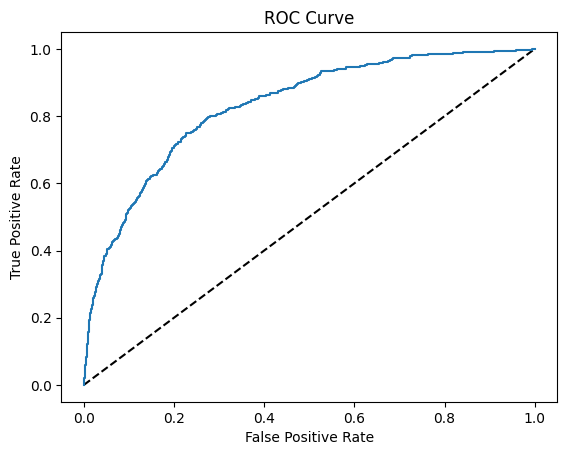

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(train[TARGET],oof_lgb)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr,label='LogisticRegression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

7. 提出

In [ ]:
# submit_sample.csvを読み込みます。
submit = pd.read_csv("/content/sample_submit.csv", header=None)
submit.head(1)

,0,1
0,3489,0.119451


In [ ]:
# テストデータを用いて予測します。
predict0 = models[0].predict(test)
predict1 = models[1].predict(test)
predict2 = models[2].predict(test)
predict = (predict0 + predict1 + predict2) / 3
submit[1] = predict

In [ ]:
# 提出
submit.to_csv("submission.csv", index=False, header=None)